In [876]:
from copy import deepcopy
from time import time
from itertools import zip_longest

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize, root_scalar, differential_evolution

from sklearn.cluster import DBSCAN, KMeans, MeanShift, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors as nn
from sklearn.metrics import (pairwise_distances, 
                             calinski_harabaz_score, silhouette_score, davies_bouldin_score)
from sklearn.metrics.pairwise import paired_distances

import sklearn

## Many useful functions

In [769]:
def reader(file_name, skip_lines=0, commos2points=False):
    '''
    read only 3 coords
    return np.array

    '''

    list_obj = list()
    with open(file_name, 'r') as fd_file:
        for line in fd_file:
            if skip_lines:
                skip_lines -= 1
                continue
            if commos2points:
                line = line.replace(',', '.')
            line = line.split()
            coords = np.zeros(shape=(3,))
            coords[0] = float(line[0])
            coords[1] = float(line[1])
            coords[2] = float(line[2])
            list_obj.append(coords)
    return np.array(list_obj)

def get_cone(array, ra, dec, offset=1.5):
    mask = ((array[:,0] > ra - offset) & (array[:, 0] < ra + offset) &
            (array[:,1] > dec - offset) & (array[:,1] < dec + offset))
    return array[mask]


def left_right_regions(points_ra_dec):
    array = points_ra_dec
    mask_right = (((array[:,0] < 60) | (array[:,0] > 306)) &
                  (array[:, 1] > -12) & (array[:, 1] < 37))
    mask_left = ((array[:,0] > 102) & (array[:,0] < 270) & 
                 (array[:,1] > -4) & (array[:,1] < 69))
    
    return array[mask_left], array[mask_right]

def do_scan(points_xyz, n_neighbors, eps, verbose=False):
    num_clusters_inter = 4
    
    dbscan = DBSCAN(eps=eps, min_samples=n_neighbors+1).fit(points_xyz)
    cen_dbscan = points_xyz[dbscan.labels_==0].mean(axis=0)

    clusters = list()
    cen_clusters = list()

    labels, count_labels = np.unique(dbscan.labels_, return_counts=True)
    most_freq_labels = labels[np.argsort(count_labels)[::-1][:num_clusters_inter]]

    for lab in most_freq_labels:
        if lab == -1:
            continue
        clusters.append(points_xyz[dbscan.labels_==lab])    
        cen_clusters.append(clusters[-1].mean(axis=0))
        if verbose:
            print('for label', lab, 'there are', clusters[-1].shape[0], 'galaxies')
    
    noize = points_xyz[dbscan.labels_==-1]
    if verbose:
        print('noize num : ', noize.shape)

    return clusters, cen_clusters, noize, dbscan.labels_


def to_ra_dec_redshift(points_xyz):
    if points_xyz.shape == (3,):
        points_xyz = points_xyz.reshape((1,3)) 
    redshift = np.linalg.norm(points_xyz, axis=1)
    ra = np.arctan(points_xyz[:,1]/points_xyz[:,0]) * 180.0 / np.pi
    dec = (90.0 - np.arccos(
        points_xyz[:,2]/np.linalg.norm(points_xyz, axis=1)) * 180.0 / np.pi)
    
    mask_2_3 = (points_xyz[:,0] < 0)
    mask_4 = ((points_xyz[:,0] > 0) & (points_xyz[:,1] < 0))
    
    ra[mask_2_3] = 180 + ra[mask_2_3]
    ra[mask_4] = 360 + ra[mask_4]
    
    points_sphere = np.zeros_like(points_xyz)
    points_sphere[:,0] = ra
    points_sphere[:,1] = dec
    points_sphere[:,2] = redshift
    

    return points_sphere


def to_xyz(polar_points):
    points = polar_points
    if points.shape == (3,):
        points = points.reshape((1,3))
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    return points_xyz

def func_distr(points, n_neighbors):
    #calculate dist to n_neighbor and indecies
    nbrs = nn(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(points)
    dist, ind = nbrs.kneighbors(points)
    dist_to_nneighbor = dist[:,n_neighbors]   
    return dist, ind

def shuffle_coords(arr_clusters):
    list_coords_shuffled = list()
    for coord in arr_clusters.T:
        coord_to_shuffle = deepcopy(coord)
        np.random.shuffle(coord_to_shuffle)
        list_coords_shuffled.append(coord_to_shuffle)
    
    arr_clusters_shuffled = np.array(list_coords_shuffled).T
    return arr_clusters_shuffled


def get_hist(arr_clusters, num_bins, right_edge):
    pair_dist_clusters = pairwise_distances(arr_clusters)
    not_zero_pair = np.triu(pair_dist_clusters)
    not_zero_pair = not_zero_pair[not_zero_pair!=0]
    arr_clusters.shape

    #to_del = np.unique(np.argwhere((pair_dist_clusters<2) & (pair_dist_clusters>0)).flatten())
    #arr_clusters = np.delete(arr_clusters, to_del, 0)

    n1 = np.histogram(not_zero_pair, num_bins, [0, right_edge])
    return n1

 


'\ndef get_hist(arr_clusters, num_bins, right_edge):\n    r = nn(n_neighbors=9).fit(arr_clusters)\n    m = r.kneighbors(arr_clusters)[0]\n    m = m.ravel()\n    m = m[m!=0]\n    n1 = np.histogram(m, num_bins, [0, right_edge])\n    return n1\n'

In [3]:
class distr_red_shift(stats.rv_continuous):
    max_prob_distr = 1.02
    max_val_distr = 0.3
    
    def __init__(self, min_val=0., max_val=max_val_distr):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def _rvs(self):
        size = self._size[0]
        min_prob = self.cdf(self.min_val)
        max_prob = self.cdf(self.max_val)
        
        list_values = list()
        i = 0
        while i < size-1:
            prob = np.random.rand() * (max_prob - min_prob) + min_prob
            sol_eq = root_scalar(
                self.__make_equation_cdf, args=prob, bracket=[0, 0.3], method='brentq')
            if(sol_eq.converged):
                list_values.append(sol_eq.root)
                i+=1
        return np.array(list_values)        
    
    
    def _pdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 93.*x[x <= 0.075]
        res[(0.075 < x) & (x <= 0.09)] = 7
        res[(0.09 < x) & (x <= 0.14)]  = 5.8
        res[(0.14 < x) & (x <= 0.21)] = -50.*x[(0.14 < x) & (x <= 0.21)] + 12.
        res[(0.21 < x) & (x <= 0.3)] = 1.5
        return res
    
    def _cdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 46.5*x[x <= 0.075]**2
        res[(0.075 < x) & (x <= 0.09)] = 7.*x[(0.075 < x) & (x <= 0.09)] - 0.2625 
        res[(0.09 < x) & (x <= 0.14)] = 5.8*x[(0.09 < x) & (x <= 0.14)] - 0.1545 #0.522 + (0.2625 + 0.105)
        res[(0.14 < x) & (x <= 0.21)] = (-25.*x[(0.14 < x) & (x <= 0.21)]**2 
                                         + 12.*x[(0.14 < x) & (x <= 0.21)] - 0.5325)
        res[(0.21 < x) & (x <= 0.3)] = 1.5*x[(0.21 < x) & (x <= 0.3)] + 0.57
        res[x >= 0.3] = 1.02
        return res
    
    def __cdf_for_one(self, x):
        if x < 0:
            res = 0
        if x <= 0.075:
            res = 46.5*x**2
        if 0.075 < x <= 0.09:
            res = 7.*x - 0.2625 
        if 0.09 < x <= 0.14:
            res = 5.8 * x - 0.522 + (0.2625 + 0.105)
        if 0.14 < x <= 0.21:
            res = -25.*x**2 + 12.*x - 0.5325
        if 0.21 < x <= 0.3:
            res =  1.5*x + 0.57
        if x > 0.3:
            res = 1.02
        return res    
    
    def __make_equation_cdf(self, x, y):
        return self.__cdf_for_one(x) - y
    


In [4]:
def plot_distinguish(n1, n2):
    distinguish = n1[0] - n2[0]
    plt.errorbar(n2[1][1:], 
             np.zeros_like(n2[1][1:]), 
             yerr=[np.zeros_like(distinguish), distinguish], alpha=1)
    
def uniform_distr(points_xyz, in_polar):
    if in_polar:
        points = to_ra_dec_redshift(points_xyz)
    else:
        points = points_xyz
    new_coords = np.zeros_like(points)
    
    for i, coord in enumerate(points.T):
        max_ = np.max(coord)
        min_ = np.min(coord)
        if i==2 and in_polar:
            new_coords[:,i] = distr_red_shift(min_val=min_, max_val=max_).rvs(size=coord.shape[0]+1)
            continue   
        new_coord = np.random.rand(*coord.shape)*(max_ - min_) + min_
        new_coords[:,i] = new_coord
    if in_polar:
        return to_xyz(new_coords)
    return new_coords
        
def plot_results(array_clusters_xyz, 
                 num_bins, right_edge, 
                 mod_mix, 
                 save=False, name='all_diagrams'):
    '''
    mod_mix:
    1: mix red_shift
    2: mix all polar coords
    3: mix all xyz coords
    4: uniform polar coords
    5: uniform xyz coords
    '''
    
    mix_array_clusters_xyz = None
    mix_array_clusters_polar = None
    array_clusters_polar = to_ra_dec_redshift(array_clusters_xyz)
    
    
    if mod_mix==1:
        array_clusters_polar_mix = deepcopy(array_clusters_polar)
        array_clusters_polar_mix[:,2] = shuffle_coords(
            array_clusters_polar_mix[:,2].reshape(-1, 1)).reshape(-1,)

        mix_array_clusters_xyz = to_xyz(array_clusters_polar_mix)
    elif mod_mix==2:
        mix_array_clusters_xyz = to_xyz(shuffle_coords(array_clusters_polar))
    elif mod_mix==3:
        mix_array_clusters_xyz = shuffle_coords(array_clusters_xyz)
    elif mod_mix==4:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=True)
    elif mod_mix==5:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=False)
    
    mix_array_clusters_polar = to_ra_dec_redshift(mix_array_clusters_xyz)
    
    n1 = get_hist(array_clusters_xyz, num_bins, right_edge)           
    n2 = get_hist(mix_array_clusters_xyz, num_bins, right_edge)
    fig = plt.figure(figsize=(8, 20))
    plt.subplot(511)
    plt.scatter(n1[1][1:], n1[0], s=2)
    plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
    plt.xlim([0, right_edge])
    #plt.xticks(np.linspace(0, right_edge, 11))
    num_bao = round(right_edge/0.035)
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    plt.subplot(512)
    plot_distinguish(n1, n2)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    num_bins = 50
    plt.subplot(513)
    plt.title('ra')
    plt.hist(array_clusters_polar[:,0], num_bins)
    plt.hist(mix_array_clusters_polar[:,0], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(514)
    plt.title('dec')
    plt.hist(array_clusters_polar[:,1], num_bins)
    plt.hist(mix_array_clusters_polar[:,1], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(515)
    plt.title('redshift')
    plt.hist(array_clusters_polar[:,2], num_bins)
    plt.hist(mix_array_clusters_polar[:,2], num_bins, alpha=0.8)
    plt.grid(True)
    
    if save:
        name = name + '.png'
        fig.savefig(name)

In [965]:
def centers_by_labels(points_xyz, labels):
    all_labels = np.unique(labels)
    cen_clusters = list()
    for lab in all_labels[1:]: #don't need noize
        cen_clusters.append(points_xyz[labels==lab].mean(axis=0))
        
    return np.array(cen_clusters)

def get_squared_func_coefs(
    expected, offset, value_left, value_right):
    
    A = np.array([[expected**2, expected, 1], 
                  [(expected-offset)**2, (expected-offset), 1], 
                  [(expected+offset)**2, (expected+offset), 1]])
   
    b = np.array([0, value_left, value_right])
    return(np.linalg.solve(A, b))
    

def squared_func(x, coefs):
    return x**2*coefs[0] + x*coefs[1] + coefs[2]

def get_subareas(points_sphere, num_subareas):
    if num_subareas==1:
        return to_xyz(points_sphere)
    elif num_subareas == 4:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_mask =  (points_sphere[:,2] < 0.11)
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_mask]),
            to_xyz(points_sphere[~ra_mask & z_mask]),
            to_xyz(points_sphere[ra_mask & ~z_mask]),
            to_xyz(points_sphere[~ra_mask & ~z_mask])
        ])
        
    elif num_subareas == 6:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_01 = (points_sphere[:,2] < 0.1)
        z_02 = ((points_sphere[:,2] < 0.2) & (points_sphere[:,2] > 0.1))
        z_03 = ((points_sphere[:,2] < 0.3) & (points_sphere[:,2] > 0.2))
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_01]),
            to_xyz(points_sphere[~ra_mask & z_01]),
            to_xyz(points_sphere[ra_mask & z_02]),
            to_xyz(points_sphere[~ra_mask & z_02]),
            to_xyz(points_sphere[ra_mask & z_03]),
            to_xyz(points_sphere[~ra_mask & z_03]),
        ])
    
     
    elif num_subareas == 5:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_01 = (points_sphere[:,2] < 0.1)
        z_02 = ((points_sphere[:,2] < 0.2) & (points_sphere[:,2] > 0.1))
        z_03 = ((points_sphere[:,2] < 0.3) & (points_sphere[:,2] > 0.2))
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_01]),
            to_xyz(points_sphere[~ra_mask & z_01]),
            to_xyz(points_sphere[ra_mask & z_02]),
            to_xyz(points_sphere[~ra_mask & z_02]),
            to_xyz(points_sphere[z_03])
        ])
    return subareas
    
    
    
    
def loss_dbscan(eps, num_neighbors, 
                points_xyz, 
                c_num_galaxies_in_1, c_num_clusters, 
                threshold_small, throw_huge=True,
                verbose=True):
    
    start_time = time()
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    time_impl = time() - start_time
    
    labels_no_small, num_dep = small_to_noize(dbscan.labels_, threshold_small)
    if throw_huge:
        labels_ = huge_to_noize(labels_no_small, 20, 1500)
    else:
        labels_ = labels_no_small
    
    res = np.unique(labels_, return_counts=True)
    num_in_clusters = res[1][1:]
    num_clusters = len(res[0])-1
    
    loss_noize = 0 #(np.abs((num_in_clusters[0] / points_xyz.shape[0])-0.25)*50)**2
    
    if num_clusters == 0:
        loss_num_in_cl = 5000000.
        loss_num_clusters = 5000000.
    else:
        loss_num_in_cl = squared_func(num_in_clusters, c_num_galaxies_in_1).mean()
        loss_num_clusters = squared_func(num_clusters, c_num_clusters).mean()
        
    if time_impl < 5.*60:
        loss_time = 0
    else:
        loss_time = np.exp(np.abs(time_impl - 14.*60))
    
    
    
    loss = loss_num_in_cl + loss_num_clusters + loss_time + loss_noize
    
    if verbose:
        print('eps = {0:.5f}  num_neighbors = {1}'.format(eps, num_neighbors))
        
        print('time:', time_impl)
        
        print(loss_num_in_cl, 
              loss_num_clusters, 
              loss_noize, '\n')
        
        print('num clusters =', num_clusters, 
              'num without dropping =', num_dep+num_clusters)
        
        print(loss)
        
        print('------------------------------------------\n')
              
    return loss

def loss_func(args_alg, *args):
      
    points_xyz = args[0]
    c_num_galaxies_in_1 = args[1]
    c_num_clusters = args[2]
    threshold_small = args[3]
    throw_huge = args[4]
    verbose = args[5]
    
    eps=args_alg[0]
    num_neighbors=round(args_alg[1])

    return loss_dbscan(
        eps, num_neighbors, points_xyz,
        c_num_galaxies_in_1, c_num_clusters, 
        threshold_small, throw_huge, verbose)  
                
def apply_dbscan(points_xyz, eps, num_neighbors):
    '''
    return: (labels, num of uniq labels)
    '''
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    uniq = np.unique(dbscan.labels_, return_counts=True)
    return [dbscan.labels_, uniq[1]]
    

def concat_results(xyz_subareas, subareas_labels):
    '''
    return (all points xyz, all labels) as np.ndarrays
    
    '''
    
    cen_cl_list = list()
    labels_list = list()
    area_list = list()
    max_cur_lab = 0
    
    for subarea, lab in zip_longest(xyz_subareas, subareas_labels):   
        mask_noize = (lab == -1)
        labels_list.append(lab[~mask_noize] + max_cur_lab)
        labels_list.append(lab[mask_noize]) # add noize as noize
        
        area_list.append(subarea[~mask_noize])
        area_list.append(subarea[mask_noize])
        max_cur_lab += max(lab)+1
        
    all_labels = np.concatenate((labels_list))
    area = np.concatenate(area_list)
    
    return area, all_labels


def eval_dif_evol(xyz_subareas, result):
    labels_list = list()
    num_in_clusters_list = list()
    for xyz_subarea, res in zip_longest(xyz_subareas, result):
        labels, num_in_cl = apply_dbscan(xyz_subarea, res.x[0], round(res.x[1])) 
        labels_list.append(labels)
        num_in_clusters_list.append(num_in_cl)
    
    
    return labels_list, num_in_clusters_list
  



In [607]:
def small_to_noize(labels, small_number):
    lab, counts = np.unique(labels, return_counts=True)
    mask_small = (counts < small_number)
    small_num_labels = lab[mask_small]
    new_labels = deepcopy(labels)
    new_labels[np.in1d(labels, small_num_labels)] = -1    
    
    return new_labels, len(small_num_labels)
        
def detect_huge_clusters(labels, num_hugest, threshold):
    lab, counts = np.unique(labels, return_counts=True)
    num_hugest = np.argsort(counts)[-2:-num_hugest-2:-1]
    
    lab_hugest = lab[num_hugest]
    counts_hugest = counts[num_hugest]
    list_hugest = list()
    
    #print(counts_hugest, num_hugest)
    
    for i, counts_cur in zip_longest(lab_hugest, counts_hugest):
        if counts_cur < threshold:
            break
        list_hugest.append(i)
    
    return np.array(list_hugest)
    
    
    
def huge_to_noize(labels, num_hugest, threshold):
    new_labels = deepcopy(labels)
    new_labels[np.in1d(labels, detect_huge_clusters(labels, num_hugest, threshold))] = -1    
        
    return new_labels
    



In [908]:
def dif_evol_on_subareas(xyz_subareas, num_galaxies_at_all, 
                         fine_num_galaxies_in1cl, 
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small, throw_huge,
                         max_iter, pop_size, verbose=True):
    
    expected_num_gal_in1cl = fine_num_galaxies_in1cl['expected']
    offset = fine_num_galaxies_in1cl['offset']
    left_fine = fine_num_galaxies_in1cl['left_fine']
    right_fine = fine_num_galaxies_in1cl['right_fine']
    solve_num_galaxies_in1cl = get_squared_func_coefs(
        expected_num_gal_in1cl, offset, left_fine, right_fine)

    
    result = list()
    for i, xyz_subarea in enumerate(xyz_subareas):
        if verbose:
            print('\n\n\nsubarea_BB {0} !!!'.format(i))
        
        if fine_num_clusters:
            expected_clusters_this_area = round(
                fine_num_clusters['num_clusters'] * xyz_subarea.shape[0] / num_galaxies_at_all)
            offset = round(fine_num_clusters['offset'] * xyz_subarea.shape[0] / num_galaxies_at_all) + 1
            left_fine = fine_num_clusters['left_fine']
            right_fine = fine_num_clusters['right_fine']
        
       
            solve_num_cl = squared_func_coefs_num_clusters(
                expected_clusters_this_area, offset, left_fine, right_fine)
            if verbose:
                print('expected clusters', expected_clusters_this_area)
        else:
            solve_num_cl = np.zeros((3,))
        
        
        result_ = differential_evolution(loss_func,
                                    [bounds_eps, bounds_neighbors], 
                                    (xyz_subarea, solve_num_galaxies_in1cl, solve_num_cl, 
                                     threshold_small, throw_huge, verbose),
                                    maxiter=max_iter, popsize=pop_size)
        result.append(result_)
        if verbose and fine_num_clusters:
            print('expected clusters were', expected_clusters_this_area)
    
    print('End learning')
    return result
    



In [919]:
def final_res(xyz_subareas, result, threshold_small, recount_huge,
              num_hugest=10, threshold_huge=1500):
    labels_list = eval_dif_evol(xyz_subareas, result)[0]
    all_area, all_labels = concat_results(xyz_subareas, labels_list)

    labels_no_small = small_to_noize(all_labels, threshold_small)[0]
    
    if recount_huge:
        labels_huge = detect_huge_clusters(labels_no_small, num_hugest, threshold_huge)
        list_huge_areas = [all_area[all_labels==i] for i in labels_huge]

        result_huge = dif_evol_on_subareas(list_huge_areas, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=threshold_small, throw_huge=False, 
                         max_iter=10, pop_size=10)
        
        mask_huge = np.in1d(labels_no_small, labels_huge)
        area_without_huge = all_area[~mask_huge]
        labels_without_huge = labels_no_small[~mask_huge]
        area_huge, labels_recounted_huge= final_res(
            list_huge_areas, result_huge, threshold_small, False)
        
        all_area, labels = concat_results([area_without_huge, area_huge], 
                                          [labels_without_huge, labels_recounted_huge])
    
    else:
        labels = labels_no_small
    
    return all_area, labels



def silhouette_no_noize(points_xyz, labels_with_noize):
    mask_noize = (labels_with_noize==-1)
    labels_no_noize = labels_with_noize[~mask_noize]
    points_xyz_no_noize = points_xyz[~mask_noize]
    start_time = time()
    res = silhouette_score(points_xyz_no_noize, labels_no_noize)
    time_impl = time() - start_time
    
    return res, time_impl

def estimate_res(points_xyz, labels):
    mask_noize = (labels==-1)
    labels_without_noize = labels[~mask_noize]
    points_xyz_without_noize = points_xyz[~mask_noize]
    
    sil = silhouette_score(
        points_xyz_without_noize, labels_without_noize)
    
    cal_har = calinski_harabaz_score(
        points_xyz_without_noize, labels_without_noize)
    
    dav_bol = davies_bouldin_score(
        points_xyz_without_noize, labels_without_noize)
    
    
    return sil, cal_har, dav_bol

def show_learned_params(result):
    for a in result:
        print(a.x[0], a.x[1])
        print(a.fun)
        print()    

def visual_estimate(labels):
    uniq_lab, counts = np.unique(labels, return_counts=True)
    num_clusters = uniq_lab.shape[0]
    num_hugest_clusters = np.argsort(counts)[:-10:-1]
    
    hugest_clusters = counts[num_hugest_clusters]
    
    mask_more_regular = counts > 250
    num_more_regular = (mask_more_regular).sum()
    
    mask_less_regular = counts < 50
    num_less_regular = (mask_less_regular).sum()
    
    regular_lab = uniq_lab[~mask_more_regular&~mask_less_regular]
    regular_labels = labels[np.in1d(labels, regular_lab)]
    
    not_big_labels = labels[np.in1d(labels, uniq_lab[~mask_more_regular])]
    
    plt.hist(np.unique(not_big_labels, return_counts=True)[1], bins=50)
    plt.plot()
    
    # plt.hist(np.unique(regular_labels, return_counts=True)[1], bins=50)
    #plt.plot()
    
    print('Total num clusters is', num_clusters)
    print('Hugest clusters have', hugest_clusters[1:])
    print('More than 250 galaxies have', num_more_regular, 'clusters')
    print('Less than 50 galaxies have', num_less_regular, 'clusters')
    
        
    
    return num_clusters, hugest_clusters[1:], num_more_regular, num_less_regular, regular_labels  
    

In [382]:
all_gal = reader('data/0_03_Space.txt')
all_gal = all_gal[all_gal[:,2]>10e-4]
left_area, right_area = left_right_regions(all_gal)
xyz_subareas = get_subareas(left_area, 4)

In [890]:
xyz_subareas_4 = get_subareas(left_area, 4)
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1300,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_4_bad_areas = dif_evol_on_subareas(xyz_subareas_4, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




subarea_BB 0 !!!
expected clusters 329
eps = 0.00032  num_neighbors = 32.0
time: 2.827375888824463
11.5981 972.241071429 0 

num clusters = 2 num without dropping = 5
983.839171429
------------------------------------------

eps = 0.00002  num_neighbors = 23.0
time: 2.4715793132781982
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00010  num_neighbors = 40.0
time: 2.704447031021118
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 37.0
time: 3.1611855030059814
4.86387368421 424.241071429 0 

num clusters = 114 num without dropping = 143
429.104945113
------------------------------------------

eps = 0.00058  num_neighbors = 11.0
time: 7.436880111694336
4.59972258065 386.205357143 0 

num clusters = 124 num without dropping = 1033
390.805079723
------------------------------------------

eps = 0.00006  

eps = 0.00041  num_neighbors = 22.0
time: 2.268693685531616
3.70785 960.491071429 0 

num clusters = 4 num without dropping = 21
964.198921429
------------------------------------------

eps = 0.00052  num_neighbors = 14.0
time: 2.418611764907837
9.3257884058 617.5 0 

num clusters = 69 num without dropping = 365
626.825788406
------------------------------------------

eps = 0.00099  num_neighbors = 13.0
time: 3.457383155822754
16.8313192661 0.142857142857 0 

num clusters = 327 num without dropping = 1358
16.9741764089
------------------------------------------

eps = 0.00096  num_neighbors = 9.0
time: 3.2911124229431152
38.736323839 0.642857142857 0 

num clusters = 323 num without dropping = 2163
39.3791809819
------------------------------------------

eps = 0.00097  num_neighbors = 6.0
time: 3.469011068344116
24.9162288889 34.2410714286 0 

num clusters = 270 num without dropping = 3159
59.1573003175
------------------------------------------

eps = 0.00100  num_neighbors = 16.0


eps = 0.00074  num_neighbors = 16.0
time: 3.047250270843506
5.15610899471 182.5 0 

num clusters = 189 num without dropping = 695
187.656108995
------------------------------------------

eps = 0.00082  num_neighbors = 27.0
time: 3.358074426651001
4.660003125 371.491071429 0 

num clusters = 128 num without dropping = 214
376.151074554
------------------------------------------

eps = 0.00044  num_neighbors = 10.0
time: 2.9173243045806885
5.59514693878 715.0 0 

num clusters = 49 num without dropping = 612
720.595146939
------------------------------------------

eps = 0.00086  num_neighbors = 16.0
time: 3.426034927368164
12.3437275591 54.2410714286 0 

num clusters = 254 num without dropping = 835
66.5847989876
------------------------------------------

eps = 0.00074  num_neighbors = 16.0
time: 3.0942437648773193
5.15610899471 182.5 0 

num clusters = 189 num without dropping = 695
187.656108995
------------------------------------------

eps = 0.00100  num_neighbors = 37.0
time: 3.8

eps = 0.00087  num_neighbors = 11.0
time: 3.467007875442505
11.3165719064 9.64285714286 0 

num clusters = 299 num without dropping = 1687
20.9594290492
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 3.5559558868408203
11.3403323263 -0.0714285714284 0 

num clusters = 331 num without dropping = 1343
11.2689037549
------------------------------------------

eps = 0.00087  num_neighbors = 15.0
time: 3.6443674564361572
14.8808515385 46.2053571429 0 

num clusters = 260 num without dropping = 962
61.0862086813
------------------------------------------

eps = 0.00086  num_neighbors = 8.0
time: 4.3241612911224365
19.0226756757 -0.0714285714284 0 

num clusters = 333 num without dropping = 2698
18.9512471042
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 4.035776615142822
11.5458628399 -0.0714285714284 0 

num clusters = 331 num without dropping = 1352
11.4744342685
------------------------------------------

eps =

eps = 0.00098  num_neighbors = 10.0
time: 3.888767719268799
32.7490592593 0.491071428572 0 

num clusters = 324 num without dropping = 1886
33.2401306878
------------------------------------------

eps = 0.00095  num_neighbors = 15.0
time: 3.6429078578948975
11.9446627451 5.95535714286 0 

num clusters = 306 num without dropping = 1055
17.900019888
------------------------------------------

eps = 0.00096  num_neighbors = 14.0
time: 3.8837900161743164
11.4548124224 0.8125 0 

num clusters = 322 num without dropping = 1220
12.2673124224
------------------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 3.7228620052337646
13.5495691358 0.491071428572 0 

num clusters = 324 num without dropping = 1504
14.0406405644
------------------------------------------

eps = 0.00085  num_neighbors = 11.0
time: 3.5969364643096924
21.8977130435 9.64285714286 0 

num clusters = 299 num without dropping = 1677
31.5405701863
------------------------------------------

eps = 0.00095  nu

eps = 0.00091  num_neighbors = 13.0
time: 3.469008207321167
15.1329488525 6.42857142857 0 

num clusters = 305 num without dropping = 1311
21.561520281
------------------------------------------

eps = 0.00093  num_neighbors = 12.0
time: 3.620919704437256
12.5755702128 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1502
12.5755702128
------------------------------------------

eps = 0.00099  num_neighbors = 15.0
time: 3.7148666381835938
12.1703091483 1.92857142857 0 

num clusters = 317 num without dropping = 1077
14.0988805768
------------------------------------------

eps = 0.00095  num_neighbors = 12.0
time: 3.5339741706848145
14.7601156923 0.357142857143 0 

num clusters = 325 num without dropping = 1507
15.1172585495
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 3.4840023517608643
10.8810603077 0.357142857143 0 

num clusters = 325 num without dropping = 1337
11.2382031648
------------------------------------------

eps = 0

eps = 0.00093  num_neighbors = 12.0
time: 4.778255939483643
12.2935743902 0.0625000000002 0 

num clusters = 328 num without dropping = 1494
12.3560743902
------------------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 3.428971767425537
13.1004012195 0.0625000000002 0 

num clusters = 328 num without dropping = 1501
13.1629012195
------------------------------------------

eps = 0.00093  num_neighbors = 12.0
time: 3.59294056892395
12.5808193939 -0.0446428571425 0 

num clusters = 330 num without dropping = 1502
12.5361765368
------------------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 3.6219396591186523
13.5553 0.491071428572 0 

num clusters = 324 num without dropping = 1504
14.0463714286
------------------------------------------

eps = 0.00096  num_neighbors = 13.0
time: 3.676887035369873
12.7772209877 0.491071428572 0 

num clusters = 324 num without dropping = 1340
13.2682924162
------------------------------------------

eps = 0.0009

eps = 0.00093  num_neighbors = 12.0
time: 3.764057159423828
12.2592024316 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1494
12.2592024316
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 3.7849931716918945
11.3368169184 -0.0714285714284 0 

num clusters = 331 num without dropping = 1341
11.265388347
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 3.76497220993042
11.1301908815 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1301908815
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 3.915618419647217
11.1378506098 0.0625000000002 0 

num clusters = 328 num without dropping = 1341
11.2003506098
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 3.750781297683716
10.9138506173 0.491071428572 0 

num clusters = 324 num without dropping = 1336
11.4049220459
------------------------------------------

ep

eps = 0.00094  num_neighbors = 13.0
time: 2.8901610374450684
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 3.504179000854492
11.1658024615 0.357142857143 0 

num clusters = 325 num without dropping = 1334
11.5229453187
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 3.267611026763916
11.1654153846 0.357142857143 0 

num clusters = 325 num without dropping = 1334
11.5225582418
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.751422643661499
11.1720510638 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1338
11.1720510638
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 2.862356185913086
11.1615116564 0.241071428572 0 

num clusters = 326 num without dropping = 1335
11.402583085
------------------------------------------

eps 

eps = 0.00060  num_neighbors = 33.0
time: 2.748406171798706
30.6846769231 822.142011834 0 

num clusters = 26 num without dropping = 33
852.826688757
------------------------------------------

eps = 0.00050  num_neighbors = 28.0
time: 2.6564743518829346
23.1661529412 875.50295858 0 

num clusters = 17 num without dropping = 26
898.669111521
------------------------------------------

eps = 0.00003  num_neighbors = 37.0
time: 2.055819034576416
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00056  num_neighbors = 23.0
time: 2.6844611167907715
26.6969526316 753.603550296 0 

num clusters = 38 num without dropping = 93
780.300502927
------------------------------------------

eps = 0.00040  num_neighbors = 9.0
time: 2.4905714988708496
20.9272318182 720.452662722 0 

num clusters = 44 num without dropping = 699
741.37989454
------------------------------------------

eps = 0.00087  num_neighbors = 14.0
time: 

eps = 0.00037  num_neighbors = 6.0
time: 1.9368853569030762
19.8473461538 677.411242604 0 

num clusters = 52 num without dropping = 2121
697.258588757
------------------------------------------

eps = 0.00013  num_neighbors = 12.0
time: 1.6870489120483398
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00030  num_neighbors = 20.0
time: 1.8329448699951172
4.49985 955.541420118 0 

num clusters = 4 num without dropping = 12
960.041270118
------------------------------------------

eps = 0.00037  num_neighbors = 5.0
time: 1.9458825588226318
19.1383253731 600.281065089 0 

num clusters = 67 num without dropping = 3531
619.419390462
------------------------------------------

eps = 0.00086  num_neighbors = 26.0
time: 2.448591947555542
19.1120930818 229.150887574 0 

num clusters = 159 num without dropping = 272
248.262980656
------------------------------------------

eps = 0.00065  num_neighbors = 33.0
time: 

eps = 0.00096  num_neighbors = 20.0
time: 2.8573787212371826
15.2399280374 91.0 0 

num clusters = 214 num without dropping = 552
106.239928037
------------------------------------------

eps = 0.00080  num_neighbors = 3.0
time: 2.9023404121398926
39.0888934959 39.449704142 0 

num clusters = 246 num without dropping = 7746
78.5385976379
------------------------------------------

eps = 0.00083  num_neighbors = 8.0
time: 2.8653740882873535
21.218254918 42.050295858 0 

num clusters = 244 num without dropping = 2244
63.268550776
------------------------------------------

eps = 0.00096  num_neighbors = 16.0
time: 2.8743700981140137
19.759200885 69.1834319527 0 

num clusters = 226 num without dropping = 748
88.9426328376
------------------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.845365285873413
60.3759925926 43.3816568047 0 

num clusters = 243 num without dropping = 1710
103.757649397
------------------------------------------

eps = 0.00068  num_neighbors =

eps = 0.00080  num_neighbors = 34.0
time: 2.3676400184631348
29.5978246914 532.49704142 0 

num clusters = 81 num without dropping = 113
562.094866111
------------------------------------------

eps = 0.00096  num_neighbors = 9.0
time: 2.8403689861297607
33.1366620968 36.9319526627 0 

num clusters = 248 num without dropping = 1697
70.0686147595
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.5155575275421143
13.4070511811 29.875739645 0 

num clusters = 254 num without dropping = 3522
43.2827908261
------------------------------------------

eps = 0.00065  num_neighbors = 8.0
time: 2.2387168407440186
13.4149064815 87.1568047337 0 

num clusters = 216 num without dropping = 2169
100.571711215
------------------------------------------

eps = 0.00075  num_neighbors = 9.0
time: 2.4955663681030273
11.5817973094 74.3579881657 0 

num clusters = 223 num without dropping = 1850
85.9397854751
------------------------------------------

eps = 0.00072  num

eps = 0.00076  num_neighbors = 6.0
time: 3.5559580326080322
19.7573328185 24.5650887574 0 

num clusters = 259 num without dropping = 3494
44.3224215759
------------------------------------------

eps = 0.00055  num_neighbors = 5.0
time: 2.88234543800354
20.4774560748 91.0 0 

num clusters = 214 num without dropping = 4910
111.477456075
------------------------------------------

eps = 0.00071  num_neighbors = 4.0
time: 2.6055047512054443
22.0708448 34.4970414201 0 

num clusters = 250 num without dropping = 6367
56.5678862201
------------------------------------------

eps = 0.00072  num_neighbors = 5.0
time: 2.583535671234131
19.854131746 32.1449704142 0 

num clusters = 252 num without dropping = 4736
51.9991021602
------------------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 2.6144959926605225
24.8891180077 22.5857988166 0 

num clusters = 261 num without dropping = 4573
47.4749168242
------------------------------------------

eps = 0.00067  num_neighbors = 

eps = 0.00070  num_neighbors = 8.0
time: 2.4625844955444336
14.7577662222 70.8875739645 0 

num clusters = 225 num without dropping = 2221
85.6453401867
------------------------------------------

eps = 0.00068  num_neighbors = 4.0
time: 2.5155551433563232
17.5459732794 38.1804733728 0 

num clusters = 247 num without dropping = 6651
55.7264466521
------------------------------------------

eps = 0.00074  num_neighbors = 6.0
time: 2.4535892009735107
15.5086776 34.4970414201 0 

num clusters = 250 num without dropping = 3513
50.0057190201
------------------------------------------

eps = 0.00080  num_neighbors = 7.0
time: 2.6314857006073
22.3183360656 42.050295858 0 

num clusters = 244 num without dropping = 2717
64.3686319236
------------------------------------------

eps = 0.00076  num_neighbors = 6.0
time: 2.569525957107544
19.1211409449 29.875739645 0 

num clusters = 254 num without dropping = 3491
48.9968805899
------------------------------------------

eps = 0.00082  num_neigh

eps = 0.00079  num_neighbors = 6.0
time: 2.6494786739349365
25.721947451 28.7721893491 0 

num clusters = 255 num without dropping = 3406
54.4941368001
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 2.5735223293304443
14.4084545455 44.7337278107 0 

num clusters = 242 num without dropping = 2813
59.1421823561
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 2.58251953125
17.0678619835 44.7337278107 0 

num clusters = 242 num without dropping = 2804
61.8015897941
------------------------------------------

eps = 0.00078  num_neighbors = 5.0
time: 2.6325082778930664
31.0083494071 31.0 0 

num clusters = 253 num without dropping = 4408
62.0083494071
------------------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 2.596525192260742
21.8027945736 25.5857988166 0 

num clusters = 258 num without dropping = 4606
47.3885933902
------------------------------------------

eps = 0.00075  num_neighbors = 

eps = 0.00073  num_neighbors = 6.0
time: 2.5375635623931885
12.955497619 32.1449704142 0 

num clusters = 252 num without dropping = 3524
45.1004680332
------------------------------------------

eps = 0.00079  num_neighbors = 6.0
time: 2.641486406326294
29.072985214 26.6272189349 0 

num clusters = 257 num without dropping = 3373
55.7002041489
------------------------------------------

eps = 0.00080  num_neighbors = 6.0
time: 2.6574766635894775
32.1829556452 36.9319526627 0 

num clusters = 248 num without dropping = 3336
69.1149083079
------------------------------------------

eps = 0.00078  num_neighbors = 8.0
time: 2.4695842266082764
13.1709099174 44.7337278107 0 

num clusters = 242 num without dropping = 2296
57.904637728
------------------------------------------

eps = 0.00072  num_neighbors = 6.0
time: 2.542559862136841
10.7585895582 35.7041420118 0 

num clusters = 249 num without dropping = 3520
46.4627315701
------------------------------------------

eps = 0.00081  num_n

eps = 0.00075  num_neighbors = 7.0
time: 3.3210930824279785
17.2850674897 43.3816568047 0 

num clusters = 243 num without dropping = 2812
60.6667242944
------------------------------------------

eps = 0.00080  num_neighbors = 8.0
time: 2.639504909515381
15.9425940928 51.8047337278 0 

num clusters = 237 num without dropping = 2274
67.7473278206
------------------------------------------

eps = 0.00078  num_neighbors = 7.0
time: 2.6314873695373535
20.3862752066 44.7337278107 0 

num clusters = 242 num without dropping = 2783
65.1200030173
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.5365641117095947
12.9095354331 29.875739645 0 

num clusters = 254 num without dropping = 3526
42.785275078
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.4386208057403564
12.8935286275 28.7721893491 0 

num clusters = 255 num without dropping = 3526
41.6657179766
------------------------------------------

eps = 0.00072  num

eps = 0.00082  num_neighbors = 35.0
time: 2.2087512016296387
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00010  num_neighbors = 20.0
time: 1.9189167022705078
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00002  num_neighbors = 4.0
time: 1.8639297485351562
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00069  num_neighbors = 32.0
time: 2.1187832355499268
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 6.0
time: 2.2747137546539307
4.93764835165 580.5 0 

num clusters = 91 num without dropping = 2685
585.437648352
------------------------------------------

eps = 0.00017  num_neighbors = 40.0
time: 1.9248948097229004
5000000.0 5000000.0 0 



eps = 0.00010  num_neighbors = 23.0
time: 1.9238979816436768
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00085  num_neighbors = 17.0
time: 2.2027366161346436
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 21
10000000.0
------------------------------------------

eps = 0.00009  num_neighbors = 29.0
time: 1.8969078063964844
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00082  num_neighbors = 9.0
time: 2.2067320346832275
5.86225714286 953.864444444 0 

num clusters = 14 num without dropping = 531
959.726701587
------------------------------------------

eps = 0.00065  num_neighbors = 9.0
time: 2.114778757095337
7.0 1026.0 0 

num clusters = 1 num without dropping = 168
1033.0
------------------------------------------

eps = 0.00018  num_neighbors = 6.0
time: 1.9318933486938477
5000000.0 5000000.0 0 

num c

eps = 0.00080  num_neighbors = 4.0
time: 2.296701192855835
4.85310689655 729.22 0 

num clusters = 58 num without dropping = 5908
734.073106897
------------------------------------------

eps = 0.00022  num_neighbors = 32.0
time: 1.9578759670257568
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 11.0
time: 2.257704019546509
5.27843636364 853.164444444 0 

num clusters = 33 num without dropping = 472
858.442880808
------------------------------------------

eps = 0.00083  num_neighbors = 8.0
time: 2.210750102996826
5.63665217391 905.464444444 0 

num clusters = 23 num without dropping = 861
911.101096618
------------------------------------------

eps = 0.00043  num_neighbors = 9.0
time: 2.0228359699249268
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 9
10000000.0
------------------------------------------

eps = 0.00009  num_neighbors = 13.0
time: 1.8929128646850586

eps = 0.00095  num_neighbors = 4.0
time: 2.437600612640381
4.94043884892 394.42 0 

num clusters = 139 num without dropping = 6967
399.360438849
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 2.1817498207092285
6.01702105263 926.82 0 

num clusters = 19 num without dropping = 1077
932.837021053
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.165757894515991
5.78261111111 932.197777778 0 

num clusters = 18 num without dropping = 1659
937.980388889
------------------------------------------

eps = 0.00097  num_neighbors = 4.0
time: 2.312671661376953
4.74713108108 363.52 0 

num clusters = 148 num without dropping = 7107
368.267131081
------------------------------------------

eps = 0.00081  num_neighbors = 5.0
time: 2.2157466411590576
5.27764313725 762.944444444 0 

num clusters = 51 num without dropping = 3401
768.222087582
------------------------------------------

eps = 0.00081  num_neighbors = 7.0
time: 2

eps = 0.00087  num_neighbors = 4.0
time: 2.28570818901062
4.53748 584.757777778 0 

num clusters = 90 num without dropping = 6470
589.295257778
------------------------------------------

eps = 0.00098  num_neighbors = 7.0
time: 2.3956246376037598
5.18722222222 584.757777778 0 

num clusters = 90 num without dropping = 1969
589.945
------------------------------------------

eps = 0.00056  num_neighbors = 27.0
time: 2.070812225341797
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.4166102409362793
5.76384785276 314.82 0 

num clusters = 163 num without dropping = 12934
320.583847853
------------------------------------------

eps = 0.00022  num_neighbors = 4.0
time: 2.000851631164551
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 86
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 4.0
time: 2.4425978660583496
4.5274619

eps = 0.00088  num_neighbors = 6.0
time: 2.365640878677368
4.96317288136 724.464444444 0 

num clusters = 59 num without dropping = 2405
729.427617326
------------------------------------------

eps = 0.00047  num_neighbors = 4.0
time: 2.0528178215026855
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2018
10000000.0
------------------------------------------

eps = 0.00036  num_neighbors = 34.0
time: 1.9948537349700928
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 20.0
time: 2.2517030239105225
6.47585 1009.12 0 

num clusters = 4 num without dropping = 32
1015.59585
------------------------------------------

eps = 0.00100  num_neighbors = 38.0
time: 2.254704236984253
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.331679344177246
4.92147027027 363.52

eps = 0.00006  num_neighbors = 24.0
time: 1.8889355659484863
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00041  num_neighbors = 3.0
time: 2.0508410930633545
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 4502
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.94730806350708
5.73024938272 317.957777778 0 

num clusters = 162 num without dropping = 12950
323.68802716
------------------------------------------

eps = 0.00097  num_neighbors = 4.0
time: 3.0332558155059814
4.81216621622 363.52 0 

num clusters = 148 num without dropping = 7069
368.332166216
------------------------------------------

eps = 0.00016  num_neighbors = 3.0
time: 1.9449036121368408
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 197
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 4.0
time: 2.1927413940429688
5.559 

eps = 0.00014  num_neighbors = 5.0
time: 1.938887119293213
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 27.0
time: 2.262700080871582
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 13.0
time: 2.2846879959106445
5.15981428571 879.12 0 

num clusters = 28 num without dropping = 291
884.279814286
------------------------------------------

eps = 0.00098  num_neighbors = 36.0
time: 2.2597014904022217
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 6.0
time: 1.875924825668335
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.3356587886810303
4.90963624161 360.164444444 

eps = 0.00095  num_neighbors = 3.0
time: 2.471581220626831
5.31150897436 337.111111111 0 

num clusters = 156 num without dropping = 12869
342.422620085
------------------------------------------

eps = 0.00096  num_neighbors = 3.0
time: 2.479576587677002
5.6478916129 340.357777778 0 

num clusters = 155 num without dropping = 12883
346.005669391
------------------------------------------

eps = 0.00071  num_neighbors = 23.0
time: 2.1567635536193848
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00065  num_neighbors = 3.0
time: 2.1727705001831055
4.84992857143 953.864444444 0 

num clusters = 14 num without dropping = 9773
958.714373016
------------------------------------------

eps = 0.00097  num_neighbors = 34.0
time: 2.254703998565674
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00057  num_neighbors = 31.0
time: 2.1127

eps = 0.00080  num_neighbors = 29.0
time: 1.8469362258911133
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00030  num_neighbors = 7.0
time: 1.656069040298462
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 36.0
time: 1.8119566440582275
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00054  num_neighbors = 31.0
time: 1.912921667098999
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00045  num_neighbors = 16.0
time: 1.7290089130401611
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 11.0
time: 1.8249540328979492
6.1261 955.541420118 0 

num clu

eps = 0.00079  num_neighbors = 36.0
time: 1.858952522277832
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00070  num_neighbors = 5.0
time: 1.8529384136199951
5.55966666667 869.49112426 0 

num clusters = 18 num without dropping = 2033
875.050790927
------------------------------------------

eps = 0.00047  num_neighbors = 7.0
time: 1.7469937801361084
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 92
10000000.0
------------------------------------------

eps = 0.00048  num_neighbors = 35.0
time: 1.7519969940185547
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 13.0
time: 1.9268949031829834
3.965875 881.535502959 0 

num clusters = 16 num without dropping = 178
885.501377959
------------------------------------------

eps = 0.00097  num_neighbors = 20.0
time: 1.8979103565216064
5.1105 9

eps = 0.00078  num_neighbors = 5.0
time: 2.4545905590057373
6.61476521739 839.74260355 0 

num clusters = 23 num without dropping = 2554
846.357368768
------------------------------------------

eps = 0.00095  num_neighbors = 6.0
time: 2.305696487426758
8.82134901961 682.718934911 0 

num clusters = 51 num without dropping = 2219
691.540283931
------------------------------------------

eps = 0.00016  num_neighbors = 7.0
time: 1.6190879344940186
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 22.0
time: 1.9039056301116943
4.86004 949.26035503 0 

num clusters = 5 num without dropping = 17
954.12039503
------------------------------------------

eps = 0.00087  num_neighbors = 22.0
time: 1.8609302043914795
5.9984 974.50887574 0 

num clusters = 1 num without dropping = 6
980.50727574
------------------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 1.943901538848877


eps = 0.00096  num_neighbors = 5.0
time: 1.9968726634979248
16.780425 615.334319527 0 

num clusters = 64 num without dropping = 3565
632.114744527
------------------------------------------

eps = 0.00094  num_neighbors = 20.0
time: 1.876920223236084
4.5489 955.541420118 0 

num clusters = 4 num without dropping = 17
960.090320118
------------------------------------------

eps = 0.00060  num_neighbors = 9.0
time: 1.7749824523925781
6.7424 974.50887574 0 

num clusters = 1 num without dropping = 83
981.25127574
------------------------------------------

eps = 0.00096  num_neighbors = 8.0
time: 1.9069039821624756
6.22525882353 776.118343195 0 

num clusters = 34 num without dropping = 990
782.343602019
------------------------------------------

eps = 0.00096  num_neighbors = 38.0
time: 1.898930311203003
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00095  num_neighbors = 19.0
time: 1.906904935836792
5.

eps = 0.00093  num_neighbors = 37.0
time: 1.8789393901824951
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 9.0
time: 1.9388887882232666
6.02733125 787.5 0 

num clusters = 32 num without dropping = 782
793.52733125
------------------------------------------

eps = 0.00098  num_neighbors = 31.0
time: 1.9099030494689941
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 3.0
time: 1.9548771381378174
10.2981578947 651.183431953 0 

num clusters = 57 num without dropping = 10406
661.481589847
------------------------------------------

eps = 0.00097  num_neighbors = 33.0
time: 1.898909091949463
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 29.0
time: 1.8999083042144775
7.5296 974.508

eps = 0.00099  num_neighbors = 4.0
time: 2.389647960662842
21.5137741935 477.627218935 0 

num clusters = 93 num without dropping = 5918
499.140993128
------------------------------------------

eps = 0.00098  num_neighbors = 34.0
time: 2.5565319061279297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 2.745438575744629
19.0521216216 565.881656805 0 

num clusters = 74 num without dropping = 3683
584.933778426
------------------------------------------

eps = 0.00084  num_neighbors = 7.0
time: 1.973886251449585
4.57232 827.98816568 0 

num clusters = 25 num without dropping = 1074
832.56048568
------------------------------------------

eps = 0.00078  num_neighbors = 4.0
time: 1.9059083461761475
6.289456 827.98816568 0 

num clusters = 25 num without dropping = 4729
834.27762168
------------------------------------------

eps = 0.00047  num_neighbors = 4.0
time: 1.728009223

eps = 0.00009  num_neighbors = 29.0
time: 1.588089942932129
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00048  num_neighbors = 4.0
time: 1.7200126647949219
7.3954 974.50887574 0 

num clusters = 1 num without dropping = 1671
981.90427574
------------------------------------------

eps = 0.00065  num_neighbors = 17.0
time: 1.8429441452026367
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.098797559738159
20.3225517857 396.849112426 0 

num clusters = 112 num without dropping = 10975
417.171664212
------------------------------------------

eps = 0.00096  num_neighbors = 3.0
time: 2.1727519035339355
21.7461612245 455.644970414 0 

num clusters = 98 num without dropping = 10938
477.391131639
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.03885006904602

eps = 0.00100  num_neighbors = 3.0
time: 2.207749605178833
12.8857147541 357.337278107 0 

num clusters = 122 num without dropping = 11056
370.222992861
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.0958144664764404
20.7907061224 455.644970414 0 

num clusters = 98 num without dropping = 5926
476.435676537
------------------------------------------

eps = 0.00006  num_neighbors = 9.0
time: 1.5990819931030273
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.084800958633423
12.8982066116 361.195266272 0 

num clusters = 121 num without dropping = 11045
374.093472884
------------------------------------------

eps = 0.00052  num_neighbors = 11.0
time: 1.8349437713623047
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00027  num_neighbors = 30.0
time: 1.769

eps = 0.00100  num_neighbors = 37.0
time: 3.4400269985198975
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00085  num_neighbors = 6.0
time: 2.2696948051452637
6.35438461538 822.142011834 0 

num clusters = 26 num without dropping = 1792
828.49639645
------------------------------------------

eps = 0.00049  num_neighbors = 3.0
time: 2.9033334255218506
6.4393 968.165680473 0 

num clusters = 2 num without dropping = 5200
974.604980473
------------------------------------------

eps = 0.00063  num_neighbors = 28.0
time: 3.436027765274048
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 12.0
time: 2.3686392307281494
4.22695454545 845.650887574 0 

num clusters = 22 num without dropping = 282
849.877842119
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.101791143417358

In [ ]:
xyz_subareas_4 = get_subareas(left_area, 4)
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1572,
    'offset': 50,
    'left_fine': 4,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_last = dif_evol_on_subareas([to_xyz(left_area)], left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)

## Expirements (untidy)


In [969]:
result__1 = final_res([to_xyz(left_area)], result_4_bad_areas, threshold_small=45, recount_huge=False)




Total num clusters is 702
Hugest clusters have [117536  14698   3787   2578   1777   1691   1335   1201]
More than 250 galaxies have 66 clusters
Less than 50 galaxies have 95 clusters


(702,
 array([117536,  14698,   3787,   2578,   1777,   1691,   1335,   1201], dtype=int64),
 66,
 95,
 array([   28,    30,    28, ..., 37266, 37266, 37266], dtype=int64))

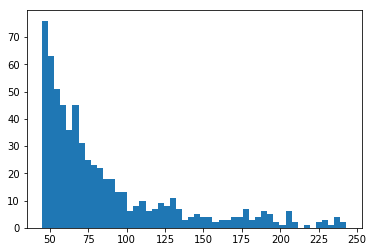

In [980]:
visual_estimate(result__1[1])

In [973]:
a, b, c = estimate_res(*result__1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [974]:
print(a, b, c)

-0.301316292207 1027.28897274 0.840141006184


In [975]:
result__1_nh = final_res([to_xyz(left_area)], result_4_bad_areas, threshold_small=45, num_hugest=20, recount_huge=True)

a, b, c = estimate_res(*result__1_nh)
print(a, b, c)




subarea_BB 0 !!!
expected clusters 246
eps = 0.00031  num_neighbors = 32.0
time: 1.2383067607879639
16.9599 1285.43827161 0 

num clusters = 4 num without dropping = 6
1302.39817161
------------------------------------------

eps = 0.00046  num_neighbors = 5.0
time: 1.5530900955200195
67.9039991416 4.73456790123 0 

num clusters = 233 num without dropping = 3915
72.6385670429
------------------------------------------

eps = 0.00065  num_neighbors = 39.0
time: 1.5031559467315674
142.27445 1007.25308642 0 

num clusters = 32 num without dropping = 46
1149.52753642
------------------------------------------

eps = 0.00082  num_neighbors = 37.0
time: 1.6870312690734863
86.1981369231 300.382716049 0 

num clusters = 130 num without dropping = 164
386.580852972
------------------------------------------

eps = 0.00002  num_neighbors = 29.0
time: 1.004422664642334
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps =

eps = 0.00082  num_neighbors = 25.0
time: 1.731003761291504
98.3539082969 7.66049382716 0 

num clusters = 229 num without dropping = 402
106.014402124
------------------------------------------

eps = 0.00035  num_neighbors = 4.0
time: 1.4411754608154297
43.7581138211 337.111111111 0 

num clusters = 123 num without dropping = 5730
380.869224932
------------------------------------------

eps = 0.00064  num_neighbors = 7.0
time: 1.8259525299072266
448.425288476 9.51234567901 0 

num clusters = 269 num without dropping = 1977
457.937634155
------------------------------------------

eps = 0.00062  num_neighbors = 16.0
time: 1.5740957260131836
62.054565 49.5493827161 0 

num clusters = 200 num without dropping = 637
111.603947716
------------------------------------------

eps = 0.00061  num_neighbors = 18.0
time: 1.5870740413665771
50.57884375 166.956790123 0 

num clusters = 160 num without dropping = 454
217.535633873
------------------------------------------

eps = 0.00063  num_nei

eps = 0.00030  num_neighbors = 35.0
time: 1.1863179206848145
23.085 1306.60493827 0 

num clusters = 2 num without dropping = 4
1329.68993827
------------------------------------------

eps = 0.00035  num_neighbors = 22.0
time: 1.2192997932434082
72.6393 1222.97530864 0 

num clusters = 10 num without dropping = 28
1295.61460864
------------------------------------------

eps = 0.00035  num_neighbors = 11.0
time: 1.2432861328125
82.7199741935 1016.60493827 0 

num clusters = 31 num without dropping = 370
1099.32491247
------------------------------------------

eps = 0.00045  num_neighbors = 26.0
time: 1.30926513671875
133.528635294 1152.06790123 0 

num clusters = 17 num without dropping = 38
1285.59653653
------------------------------------------

eps = 0.00040  num_neighbors = 32.0
time: 1.2732698917388916
98.1258888889 1233.27777778 0 

num clusters = 9 num without dropping = 12
1331.40366667
------------------------------------------

eps = 0.00062  num_neighbors = 16.0
time: 1.5

eps = 0.00038  num_neighbors = 19.0
time: 1.265270471572876
96.46182 1122.32716049 0 

num clusters = 20 num without dropping = 63
1218.78898049
------------------------------------------

eps = 0.00052  num_neighbors = 8.0
time: 1.4451711177825928
62.9247365217 6.86419753086 0 

num clusters = 230 num without dropping = 1975
69.7889340526
------------------------------------------

eps = 0.00044  num_neighbors = 5.0
time: 1.5091331005096436
63.1569816514 19.2716049383 0 

num clusters = 218 num without dropping = 3961
82.4285865896
------------------------------------------

eps = 0.00029  num_neighbors = 24.0
time: 1.188338279724121
19.75605 1285.43827161 0 

num clusters = 4 num without dropping = 10
1305.19432161
------------------------------------------

eps = 0.00016  num_neighbors = 14.0
time: 1.0863962173461914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 9
10000000.0
------------------------------------------

eps = 0.00046  num_neighbors = 8.0
time: 1.3662

eps = 0.00058  num_neighbors = 39.0
time: 1.4291799068450928
153.642290909 1102.71604938 0 

num clusters = 22 num without dropping = 26
1256.35834029
------------------------------------------

eps = 0.00043  num_neighbors = 3.0
time: 1.5411145687103271
66.980702521 2.04938271605 0 

num clusters = 238 num without dropping = 8089
69.0300852371
------------------------------------------

eps = 0.00056  num_neighbors = 13.0
time: 1.438190221786499
49.6491648352 93.8271604938 0 

num clusters = 182 num without dropping = 819
143.476325329
------------------------------------------

eps = 0.00056  num_neighbors = 10.0
time: 1.4631407260894775
63.0836412556 13.3456790123 0 

num clusters = 223 num without dropping = 1374
76.429320268
------------------------------------------

eps = 0.00050  num_neighbors = 7.0
time: 1.5241329669952393
62.4392365957 3.53086419753 0 

num clusters = 235 num without dropping = 2414
65.9701007933
------------------------------------------

eps = 0.00041  num_

eps = 0.00046  num_neighbors = 5.0
time: 1.4281768798828125
67.7071387234 3.53086419753 0 

num clusters = 235 num without dropping = 3917
71.2380029209
------------------------------------------

eps = 0.00043  num_neighbors = 3.0
time: 1.540116786956787
66.2604305785 0.679012345679 0 

num clusters = 242 num without dropping = 8052
66.9394429242
------------------------------------------

eps = 0.00048  num_neighbors = 7.0
time: 1.4251813888549805
47.106859633 19.2716049383 0 

num clusters = 218 num without dropping = 2382
66.3784645713
------------------------------------------

eps = 0.00044  num_neighbors = 4.0
time: 1.513143539428711
61.4995746032 0.277777777778 0 

num clusters = 252 num without dropping = 5370
61.777352381
------------------------------------------

eps = 0.00047  num_neighbors = 5.0
time: 1.5311379432678223
65.8776184739 -0.0555555555554 0 

num clusters = 249 num without dropping = 3907
65.8220629183
------------------------------------------

eps = 0.00039 

eps = 0.00082  num_neighbors = 10.0
time: 0.17290759086608887
22.960293617 106.0 0 

num clusters = 47 num without dropping = 170
128.960293617
------------------------------------------

eps = 0.00084  num_neighbors = 21.0
time: 0.16090631484985352
4.71024848485 1.0 0 

num clusters = 33 num without dropping = 76
5.71024848485
------------------------------------------

eps = 0.00076  num_neighbors = 22.0
time: 0.14991140365600586
5.0515125 104.0625 0 

num clusters = 16 num without dropping = 46
109.1140125
------------------------------------------

eps = 0.00081  num_neighbors = 16.0
time: 0.15491151809692383
4.57678181818 69.0625 0 

num clusters = 44 num without dropping = 135
73.6392818182
------------------------------------------

eps = 0.00056  num_neighbors = 20.0
time: 0.14391684532165527
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00080  num_neighbors = 14.0
time: 0.15492606163024902
4.995

eps = 0.00098  num_neighbors = 28.0
time: 0.17290258407592773
4.89588205128 25.0 0 

num clusters = 39 num without dropping = 46
29.8958820513
------------------------------------------

eps = 0.00074  num_neighbors = 22.0
time: 0.14091825485229492
5.48983076923 148.5 0 

num clusters = 13 num without dropping = 39
153.989830769
------------------------------------------

eps = 0.00080  num_neighbors = 19.0
time: 0.1608901023864746
4.50055757576 1.0 0 

num clusters = 33 num without dropping = 89
5.50055757576
------------------------------------------

eps = 0.00070  num_neighbors = 27.0
time: 0.14390826225280762
6.5861 378.8125 0 

num clusters = 2 num without dropping = 11
385.3986
------------------------------------------

eps = 0.00075  num_neighbors = 20.0
time: 0.14991307258605957
4.86821666667 24.0625 0 

num clusters = 24 num without dropping = 56
28.9307166667
------------------------------------------

eps = 0.00080  num_neighbors = 21.0
time: 0.1619267463684082
4.300457142

eps = 0.00094  num_neighbors = 25.0
time: 0.17589831352233887
4.42908205128 25.0 0 

num clusters = 39 num without dropping = 58
29.4290820513
------------------------------------------

eps = 0.00094  num_neighbors = 25.0
time: 0.15891122817993164
4.42908205128 25.0 0 

num clusters = 39 num without dropping = 58
29.4290820513
------------------------------------------

eps = 0.00082  num_neighbors = 20.0
time: 0.1559295654296875
4.72122857143 5.5 0 

num clusters = 35 num without dropping = 83
10.2212285714
------------------------------------------

eps = 0.00078  num_neighbors = 17.0
time: 0.1479344367980957
5.017725 32.0625 0 

num clusters = 40 num without dropping = 110
37.080225
------------------------------------------

eps = 0.00078  num_neighbors = 20.0
time: 0.14691567420959473
4.51660740741 8.5 0 

num clusters = 27 num without dropping = 64
13.0166074074
------------------------------------------

eps = 0.00085  num_neighbors = 20.0
time: 0.15093278884887695
4.8421897435

eps = 0.00088  num_neighbors = 25.0
time: 0.17190289497375488
4.56299285714 5.0625 0 

num clusters = 28 num without dropping = 47
9.62549285714
------------------------------------------

eps = 0.00075  num_neighbors = 28.0
time: 0.14291596412658691
6.19453333333 353.5 0 

num clusters = 3 num without dropping = 14
359.694533333
------------------------------------------

eps = 0.00069  num_neighbors = 17.0
time: 0.14393401145935059
5.16602727273 38.8125 0 

num clusters = 22 num without dropping = 71
43.9785272727
------------------------------------------

eps = 0.00067  num_neighbors = 23.0
time: 0.13793587684631348
5.7805 378.8125 0 

num clusters = 2 num without dropping = 20
384.593
------------------------------------------

eps = 0.00084  num_neighbors = 19.0
time: 0.15690255165100098
4.67715121951 40.0 0 

num clusters = 41 num without dropping = 101
44.6771512195
------------------------------------------

eps = 0.00091  num_neighbors = 26.0
time: 0.15492987632751465
4.33457

eps = 0.00063  num_neighbors = 10.0
time: 0.15093541145324707
4.4362125 0.0625 0 

num clusters = 32 num without dropping = 231
4.4987125
------------------------------------------

eps = 0.00077  num_neighbors = 17.0
time: 0.15189719200134277
4.81566666667 9.0625 0 

num clusters = 36 num without dropping = 105
13.8781666667
------------------------------------------

eps = 0.00076  num_neighbors = 17.0
time: 0.15292930603027344
4.3542625 0.0625 0 

num clusters = 32 num without dropping = 99
4.4167625
------------------------------------------

eps = 0.00076  num_neighbors = 17.0
time: 0.14591598510742188
4.3542625 0.0625 0 

num clusters = 32 num without dropping = 99
4.4167625
------------------------------------------

eps = 0.00076  num_neighbors = 17.0
time: 0.14893269538879395
4.3542625 0.0625 0 

num clusters = 32 num without dropping = 99
4.4167625
------------------------------------------

expected clusters were 31



subarea_BB 2 !!!
expected clusters 8
eps = 0.00093  num_

eps = 0.00069  num_neighbors = 19.0
time: 0.029982566833496094
1.6352 67.5 0 

num clusters = 2 num without dropping = 5
69.1352
------------------------------------------

eps = 0.00100  num_neighbors = 19.0
time: 0.0399777889251709
4.07882857143 58.5 0 

num clusters = 14 num without dropping = 32
62.5788285714
------------------------------------------

eps = 0.00063  num_neighbors = 11.0
time: 0.03098130226135254
4.28568 18.0 0 

num clusters = 5 num without dropping = 46
22.28568
------------------------------------------

eps = 0.00063  num_neighbors = 19.0
time: 0.02800297737121582
3.64 91.0 0 

num clusters = 1 num without dropping = 6
94.64
------------------------------------------

eps = 0.00036  num_neighbors = 6.0
time: 0.025003433227539062
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 61
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 13.0
time: 0.031002283096313477
4.03285714286 2.5 0 

num clusters = 7 num without 

eps = 0.00084  num_neighbors = 21.0
time: 0.033982276916503906
3.29823333333 8.5 0 

num clusters = 6 num without dropping = 20
11.7982333333
------------------------------------------

eps = 0.00057  num_neighbors = 16.0
time: 0.03200173377990723
4.9634 91.0 0 

num clusters = 1 num without dropping = 6
95.9634
------------------------------------------

eps = 0.00075  num_neighbors = 10.0
time: 0.03200244903564453
4.84141538462 40.0 0 

num clusters = 13 num without dropping = 65
44.8414153846
------------------------------------------

eps = 0.00087  num_neighbors = 16.0
time: 0.03300070762634277
4.136 5.5 0 

num clusters = 10 num without dropping = 36
9.636
------------------------------------------

eps = 0.00080  num_neighbors = 13.0
time: 0.032001495361328125
4.35276363636 13.5 0 

num clusters = 11 num without dropping = 48
17.8527636364
------------------------------------------

eps = 0.00087  num_neighbors = 14.0
time: 0.03299856185913086
5.48363529412 135.0 0 

num cluster

eps = 0.00090  num_neighbors = 19.0
time: 0.03298139572143555
3.93062222222 1.0 0 

num clusters = 9 num without dropping = 30
4.93062222222
------------------------------------------

eps = 0.00087  num_neighbors = 16.0
time: 0.04297494888305664
4.1663 5.5 0 

num clusters = 10 num without dropping = 36
9.6663
------------------------------------------

eps = 0.00090  num_neighbors = 19.0
time: 0.036978721618652344
3.91073333333 1.0 0 

num clusters = 9 num without dropping = 30
4.91073333333
------------------------------------------

eps = 0.00089  num_neighbors = 19.0
time: 0.032999277114868164
3.463675 0.0 0 

num clusters = 8 num without dropping = 30
3.463675
------------------------------------------

eps = 0.00087  num_neighbors = 11.0
time: 0.03298044204711914
4.49387777778 167.5 0 

num clusters = 18 num without dropping = 55
171.993877778
------------------------------------------

eps = 0.00082  num_neighbors = 22.0
time: 0.03298139572143555
3.45316 18.0 0 

num clusters =

eps = 0.00054  num_neighbors = 9.0
time: 0.02898120880126953
3.85015 2.5 0 

num clusters = 4 num without dropping = 32
6.35015
------------------------------------------

eps = 0.00092  num_neighbors = 33.0
time: 0.0319821834564209
6.6108 8.5 0 

num clusters = 3 num without dropping = 5
15.1108
------------------------------------------

eps = 0.00011  num_neighbors = 6.0
time: 0.01899099349975586
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 16.0
time: 0.023984193801879883
1.74246666667 8.5 0 

num clusters = 3 num without dropping = 15
10.2424666667
------------------------------------------

eps = 0.00005  num_neighbors = 7.0
time: 0.015989303588867188
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 39.0
time: 0.022986650466918945
5.6937 18.0 0 

num clusters = 2 num without

eps = 0.00047  num_neighbors = 12.0
time: 0.019987821578979492
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 5
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 11.0
time: 0.027983903884887695
13.25688 7.1054273576e-15 0 

num clusters = 5 num without dropping = 33
13.25688
------------------------------------------

eps = 0.00020  num_neighbors = 14.0
time: 0.0159912109375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 18.0
time: 0.024004220962524414
6.8305 1.0 0 

num clusters = 6 num without dropping = 16
7.8305
------------------------------------------

eps = 0.00050  num_neighbors = 12.0
time: 0.01898813247680664
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 10
10000000.0
------------------------------------------

eps = 0.00060  num_neighbors = 17.0
time: 0.0199887752532959
5.2976 31.0 0 

num clusters = 

eps = 0.00075  num_neighbors = 18.0
time: 0.0219876766204834
7.19776 7.1054273576e-15 0 

num clusters = 5 num without dropping = 15
7.19776
------------------------------------------

eps = 0.00072  num_neighbors = 14.0
time: 0.03099536895751953
8.3894 7.1054273576e-15 0 

num clusters = 5 num without dropping = 24
8.3894
------------------------------------------

eps = 0.00082  num_neighbors = 22.0
time: 0.026984214782714844
7.21893333333 1.0 0 

num clusters = 6 num without dropping = 13
8.21893333333
------------------------------------------

eps = 0.00080  num_neighbors = 20.0
time: 0.023975849151611328
7.21223333333 1.0 0 

num clusters = 6 num without dropping = 14
8.21223333333
------------------------------------------

eps = 0.00064  num_neighbors = 22.0
time: 0.020987272262573242
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00078  num_neighbors = 20.0
time: 0.02297687530517578
7.63563333333

eps = 0.00062  num_neighbors = 10.0
time: 0.025982379913330078
8.73624 7.1054273576e-15 0 

num clusters = 5 num without dropping = 33
8.73624
------------------------------------------

eps = 0.00060  num_neighbors = 12.0
time: 0.026968002319335938
3.5597 2.5 0 

num clusters = 4 num without dropping = 21
6.0597
------------------------------------------

eps = 0.00058  num_neighbors = 18.0
time: 0.023999691009521484
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00064  num_neighbors = 13.0
time: 0.023987770080566406
6.70625 2.5 0 

num clusters = 4 num without dropping = 21
9.20625
------------------------------------------

eps = 0.00052  num_neighbors = 7.0
time: 0.021005630493164062
3.4523 2.5 0 

num clusters = 4 num without dropping = 49
5.9523
------------------------------------------

eps = 0.00047  num_neighbors = 9.0
time: 0.01900625228881836
5.1545 18.0 0 

num clusters = 2 num without droppi

eps = 0.00046  num_neighbors = 4.0
time: 0.020006895065307617
6.2955 2.5 0 

num clusters = 4 num without dropping = 130
8.7955
------------------------------------------

eps = 0.00049  num_neighbors = 7.0
time: 0.023986101150512695
2.8974 8.5 0 

num clusters = 3 num without dropping = 56
11.3974
------------------------------------------

eps = 0.00059  num_neighbors = 10.0
time: 0.022006988525390625
4.40273333333 1.0 0 

num clusters = 6 num without dropping = 32
5.40273333333
------------------------------------------

eps = 0.00056  num_neighbors = 11.0
time: 0.0200040340423584
3.42753333333 8.5 0 

num clusters = 3 num without dropping = 25
11.9275333333
------------------------------------------

eps = 0.00072  num_neighbors = 8.0
time: 0.026003599166870117
17.7303333333 1.0 0 

num clusters = 6 num without dropping = 34
18.7303333333
------------------------------------------

eps = 0.00084  num_neighbors = 11.0
time: 0.026985883712768555
20.2663142857 5.5 0 

num clusters = 7

eps = 0.00096  num_neighbors = 32.0
time: 0.01897144317626953
12.7008 2.5 0 

num clusters = 3 num without dropping = 4
15.2008
------------------------------------------

eps = 0.00085  num_neighbors = 22.0
time: 0.018007516860961914
13.8314666667 2.5 0 

num clusters = 3 num without dropping = 6
16.3314666667
------------------------------------------

eps = 0.00018  num_neighbors = 36.0
time: 0.009993553161621094
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 34.0
time: 0.015010595321655273
10.2378666667 2.5 0 

num clusters = 3 num without dropping = 4
12.7378666667
------------------------------------------

eps = 0.00012  num_neighbors = 32.0
time: 0.00999307632446289
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00092  num_neighbors = 29.0
time: 0.014009952545166016
11.9304666667 2.5 0 

num cl


num clusters = 1 num without dropping = 29
21.6714
------------------------------------------

eps = 0.00061  num_neighbors = 15.0
time: 0.01800680160522461
3.2144 18.0 0 

num clusters = 1 num without dropping = 5
21.2144
------------------------------------------

eps = 0.00081  num_neighbors = 32.0
time: 0.01501154899597168
4.3616 18.0 0 

num clusters = 1 num without dropping = 1
22.3616
------------------------------------------

eps = 0.00057  num_neighbors = 14.0
time: 0.013991832733154297
1.3216 18.0 0 

num clusters = 1 num without dropping = 4
19.3216
------------------------------------------

eps = 0.00057  num_neighbors = 11.0
time: 0.014991044998168945
2.5456 18.0 0 

num clusters = 1 num without dropping = 11
20.5456
------------------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 0.017987728118896484
1407.56 18.0 0 

num clusters = 1 num without dropping = 5
1425.56
------------------------------------------

eps = 0.00069  num_neighbors = 13.0
time

eps = 0.00055  num_neighbors = 17.0
time: 0.012010574340820312
0.0546 18.0 0 

num clusters = 1 num without dropping = 2
18.0546
------------------------------------------

eps = 0.00060  num_neighbors = 9.0
time: 0.018009662628173828
9.51746666667 2.5 0 

num clusters = 3 num without dropping = 25
12.0174666667
------------------------------------------

eps = 0.00054  num_neighbors = 7.0
time: 0.013993024826049805
9.52646666667 2.5 0 

num clusters = 3 num without dropping = 35
12.0264666667
------------------------------------------

eps = 0.00051  num_neighbors = 6.0
time: 0.014011383056640625
9.0724 2.5 0 

num clusters = 3 num without dropping = 48
11.5724
------------------------------------------

eps = 0.00063  num_neighbors = 16.0
time: 0.012010812759399414
2.625 18.0 0 

num clusters = 1 num without dropping = 5
20.625
------------------------------------------

eps = 0.00073  num_neighbors = 21.0
time: 0.013010025024414062
5.0 18.0 0 

num clusters = 1 num without dropping 

eps = 0.00054  num_neighbors = 5.0
time: 0.012992620468139648
12.95895 0.0 0 

num clusters = 4 num without dropping = 70
12.95895
------------------------------------------

eps = 0.00050  num_neighbors = 3.0
time: 0.015988588333129883
14.24435 0.0 0 

num clusters = 4 num without dropping = 124
14.24435
------------------------------------------

eps = 0.00047  num_neighbors = 6.0
time: 0.015011072158813477
7.087 8.5 0 

num clusters = 2 num without dropping = 44
15.587
------------------------------------------

eps = 0.00081  num_neighbors = 26.0
time: 0.01300954818725586
9.2834 18.0 0 

num clusters = 1 num without dropping = 3
27.2834
------------------------------------------

eps = 0.00081  num_neighbors = 26.0
time: 0.014984369277954102
9.2834 18.0 0 

num clusters = 1 num without dropping = 3
27.2834
------------------------------------------

eps = 0.00041  num_neighbors = 5.0
time: 0.011991500854492188
1.885 18.0 0 

num clusters = 1 num without dropping = 60
19.885
-------

eps = 0.00092  num_neighbors = 5.0
time: 0.022005558013916016
472.0085 8.5 0 

num clusters = 2 num without dropping = 4
480.5085
------------------------------------------

eps = 0.00088  num_neighbors = 4.0
time: 0.0180051326751709
515.9658 8.5 0 

num clusters = 2 num without dropping = 3
524.4658
------------------------------------------

eps = 0.00054  num_neighbors = 16.0
time: 0.010993719100952148
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00074  num_neighbors = 33.0
time: 0.011010169982910156
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00032  num_neighbors = 6.0
time: 0.009011983871459961
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 8
10000000.0
------------------------------------------

eps = 0.00069  num_neighbors = 8.0
time: 0.01200723648071289
5.590825 25.0 0 

num clusters = 8 num wit

eps = 0.00058  num_neighbors = 38.0
time: 0.01199197769165039
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00029  num_neighbors = 23.0
time: 0.012990474700927734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 15.0
time: 0.011993169784545898
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00023  num_neighbors = 16.0
time: 0.011012792587280273
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00028  num_neighbors = 23.0
time: 0.010010957717895508
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00059  num_neighbors = 11.0
time: 0.012011051177978516
5000000.0 5000000.

eps = 0.00076  num_neighbors = 12.0
time: 0.016009092330932617
5.16646666667 5.5 0 

num clusters = 6 num without dropping = 21
10.6664666667
------------------------------------------

eps = 0.00059  num_neighbors = 8.0
time: 0.01401209831237793
5.70413333333 2.5 0 

num clusters = 3 num without dropping = 39
8.20413333333
------------------------------------------

eps = 0.00072  num_neighbors = 9.0
time: 0.012010335922241211
5.1295 25.0 0 

num clusters = 8 num without dropping = 33
30.1295
------------------------------------------

eps = 0.00066  num_neighbors = 10.0
time: 0.012011528015136719
5.41986666667 2.5 0 

num clusters = 3 num without dropping = 25
7.91986666667
------------------------------------------

eps = 0.00074  num_neighbors = 13.0
time: 0.012010335922241211
6.14193333333 5.5 0 

num clusters = 6 num without dropping = 17
11.6419333333
------------------------------------------

eps = 0.00077  num_neighbors = 12.0
time: 0.012011528015136719
5.10217142857 13.5 0 


eps = 0.00058  num_neighbors = 6.0
time: 0.012009143829345703
4.70726666667 2.5 0 

num clusters = 3 num without dropping = 46
7.20726666667
------------------------------------------

eps = 0.00050  num_neighbors = 38.0
time: 0.01600790023803711
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00050  num_neighbors = 3.0
time: 0.01299285888671875
4.703 2.5 0 

num clusters = 3 num without dropping = 147
7.203
------------------------------------------

eps = 0.00042  num_neighbors = 32.0
time: 0.011995553970336914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00053  num_neighbors = 4.0
time: 0.012986898422241211
4.42346666667 2.5 0 

num clusters = 3 num without dropping = 89
6.92346666667
------------------------------------------

eps = 0.00059  num_neighbors = 6.0
time: 0.012991666793823242
5.3569 0.0 0 

num clusters = 4 

7.5082
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.014980554580688477
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.01699042320251465
5.05532 1.0 0 

num clusters = 5 num without dropping = 61
6.05532
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.013993501663208008
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
------------------------------------------

eps = 0.00001  num_neighbors = 5.0
time: 0.009014606475830078
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 5.0
time: 0.008993864059448242
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 5.0
time: 0.008974790573120117
500

eps = 0.00058  num_neighbors = 5.0
time: 0.010992765426635742
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.013992547988891602
5.05532 1.0 0 

num clusters = 5 num without dropping = 61
6.05532
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.0159909725189209
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.010993719100952148
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.01099395751953125
5.05532 1.0 0 

num clusters = 5 num without dropping = 61
6.05532
------------------------------------------

eps = 0.00058  num_neighbors = 5.0
time: 0.010993719100952148
4.43675 0.0 0 

num clusters = 4 num without dropping = 62
4.43675
---------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [990]:
np.unique(result__1_nh[1], return_counts=True)[1][1:].mean()

122.85155466399198

Total num clusters is 998
Hugest clusters have [3518 3067 1447 1335 1201 1085  982  972]
More than 250 galaxies have 78 clusters
Less than 50 galaxies have 127 clusters


(998,
 array([3518, 3067, 1447, 1335, 1201, 1085,  982,  972], dtype=int64),
 78,
 127,
 array([   28,    30,    28, ..., 43112, 43112, 43112], dtype=int64))

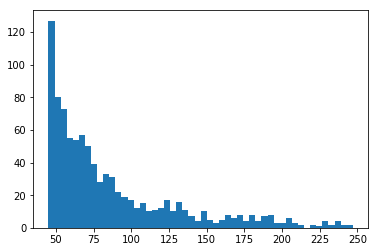

In [991]:
visual_estimate(result__1_nh[1])

In [966]:
xyz_subareas_4 = get_subareas(left_area, 4)
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1572,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_4_bad_areas = dif_evol_on_subareas([to_xyz(left_area)], left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




subarea_BB 0 !!!
expected clusters 1572
eps = 0.00003  num_neighbors = 5.0
time: 8.984841585159302
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00029  num_neighbors = 37.0
time: 9.837348937988281
5.9052 1679.39100346 0 

num clusters = 3 num without dropping = 4
1685.29620346
------------------------------------------

eps = 0.00036  num_neighbors = 7.0
time: 9.810367345809937
12.6978222222 1517.65570934 0 

num clusters = 81 num without dropping = 2420
1530.35353156
------------------------------------------

eps = 0.00018  num_neighbors = 26.0
time: 9.268677711486816
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00065  num_neighbors = 12.0
time: 10.354052782058716
6.61605797101 1030.99134948 0 

num clusters = 345 num without dropping = 2037
1037.60740745
------------------------------------------

eps = 0.00058  num

eps = 0.00042  num_neighbors = 17.0
time: 9.251687288284302
17.2546758621 1624.56958862 0 

num clusters = 29 num without dropping = 155
1641.82426448
------------------------------------------

eps = 0.00075  num_neighbors = 24.0
time: 10.64991044998169
14.689845 1213.3183391 0 

num clusters = 240 num without dropping = 483
1228.0081841
------------------------------------------

eps = 0.00078  num_neighbors = 6.0
time: 11.203565120697021
17.6827955485 612.170511342 0 

num clusters = 629 num without dropping = 10773
629.85330689
------------------------------------------

eps = 0.00044  num_neighbors = 5.0
time: 9.901334047317505
11.0902967742 1198.90465206 0 

num clusters = 248 num without dropping = 9857
1209.99494883
------------------------------------------

eps = 0.00100  num_neighbors = 30.0
time: 12.124820947647095
9.27965546218 1011.09861592 0 

num clusters = 357 num without dropping = 538
1020.37827138
------------------------------------------

eps = 0.00072  num_neighb

eps = 0.00091  num_neighbors = 12.0
time: 15.148303747177124
16.013616609 679.386197616 0 

num clusters = 578 num without dropping = 3156
695.399814225
------------------------------------------

eps = 0.00098  num_neighbors = 29.0
time: 11.661303281784058
7.88316077348 1002.86716647 0 

num clusters = 362 num without dropping = 569
1010.75032725
------------------------------------------

eps = 0.00051  num_neighbors = 3.0
time: 11.623345375061035
7.35588650964 837.777777778 0 

num clusters = 467 num without dropping = 38957
845.133664287
------------------------------------------

eps = 0.00072  num_neighbors = 4.0
time: 11.390458583831787
16.9763306184 569.30449827 0 

num clusters = 663 num without dropping = 22960
586.280828888
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 12.023096323013306
17.0079412969 668.611111111 0 

num clusters = 586 num without dropping = 8032
685.619052408
------------------------------------------

eps = 0.00055 

eps = 0.00083  num_neighbors = 3.0
time: 12.545924425125122
12.5979665198 547.240484429 0 

num clusters = 681 num without dropping = 37793
559.838450949
------------------------------------------

eps = 0.00072  num_neighbors = 24.0
time: 10.474522113800049
11.7163629268 1277.39081123 0 

num clusters = 205 num without dropping = 426
1289.10717415
------------------------------------------

eps = 0.00074  num_neighbors = 13.0
time: 10.842795372009277
7.5692047619 909.84083045 0 

num clusters = 420 num without dropping = 2043
917.410035212
------------------------------------------

eps = 0.00074  num_neighbors = 15.0
time: 10.515961408615112
6.36491472081 950.982506728 0 

num clusters = 394 num without dropping = 1514
957.347421449
------------------------------------------

eps = 0.00082  num_neighbors = 3.0
time: 12.009634017944336
12.5394791604 564.363706267 0 

num clusters = 667 num without dropping = 38015
576.903185427
------------------------------------------

eps = 0.00084

eps = 0.00089  num_neighbors = 6.0
time: 11.915895700454712
15.63975 598.131872357 0 

num clusters = 640 num without dropping = 11024
613.771622357
------------------------------------------

eps = 0.00074  num_neighbors = 7.0
time: 11.293514490127563
17.7292618056 682.093425605 0 

num clusters = 576 num without dropping = 7925
699.822687411
------------------------------------------

eps = 0.00083  num_neighbors = 5.0
time: 11.515385627746582
17.4624100763 579.250672818 0 

num clusters = 655 num without dropping = 15191
596.713082894
------------------------------------------

eps = 0.00033  num_neighbors = 3.0
time: 9.52952527999878
11.7109305085 1443.79796232 0 

num clusters = 118 num without dropping = 27707
1455.50889283
------------------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 12.17201018333435
12.5097546269 560.672241446 0 

num clusters = 670 num without dropping = 36865
573.181996072
------------------------------------------

eps = 0.00092  num_

eps = 0.00088  num_neighbors = 3.0
time: 15.965143918991089
13.9589356083 555.769127259 0 

num clusters = 674 num without dropping = 36889
569.728062867
------------------------------------------

eps = 0.00072  num_neighbors = 3.0
time: 13.980597496032715
17.3816604993 547.240484429 0 

num clusters = 681 num without dropping = 39627
564.622144928
------------------------------------------

eps = 0.00079  num_neighbors = 20.0
time: 13.16907000541687
5.87145341246 1044.36082276 0 

num clusters = 337 num without dropping = 872
1050.23227617
------------------------------------------

eps = 0.00087  num_neighbors = 3.0
time: 14.829277038574219
12.80226 560.672241446 0 

num clusters = 670 num without dropping = 37049
573.474501446
------------------------------------------

eps = 0.00086  num_neighbors = 3.0
time: 15.716974020004272
13.3469907601 559.444444444 0 

num clusters = 671 num without dropping = 37233
572.791435204
------------------------------------------

eps = 0.00084  nu

eps = 0.00079  num_neighbors = 3.0
time: 14.76751971244812
16.3841661808 541.188965782 0 

num clusters = 686 num without dropping = 38687
557.573131963
------------------------------------------

eps = 0.00090  num_neighbors = 3.0
time: 14.624604225158691
14.0754420896 560.672241446 0 

num clusters = 670 num without dropping = 36490
574.747683535
------------------------------------------

eps = 0.00083  num_neighbors = 18.0
time: 13.581201791763306
7.15845566502 931.881007305 0 

num clusters = 406 num without dropping = 1201
939.03946297
------------------------------------------

eps = 0.00088  num_neighbors = 4.0
time: 15.002928972244263
11.6853996937 581.750672818 0 

num clusters = 653 num without dropping = 22139
593.436072512
------------------------------------------

eps = 0.00087  num_neighbors = 30.0
time: 13.36896300315857
5.04775801527 1173.88792772 0 

num clusters = 262 num without dropping = 389
1178.93568574
------------------------------------------

eps = 0.00081 

eps = 0.00087  num_neighbors = 4.0
time: 12.098053216934204
12.8887450382 579.250672818 0 

num clusters = 655 num without dropping = 22153
592.139417856
------------------------------------------

eps = 0.00089  num_neighbors = 35.0
time: 10.881752490997314
13.7525490909 1249.72933487 0 

num clusters = 220 num without dropping = 298
1263.48188396
------------------------------------------

eps = 0.00087  num_neighbors = 4.0
time: 11.95813274383545
13.221740458 579.250672818 0 

num clusters = 655 num without dropping = 22154
592.472413276
------------------------------------------

eps = 0.00096  num_neighbors = 3.0
time: 13.31435251235962
13.0113121439 564.363706267 0 

num clusters = 667 num without dropping = 35112
577.375018411
------------------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 12.98953890800476
13.2424354354 565.596885813 0 

num clusters = 666 num without dropping = 36773
578.839321249
------------------------------------------

eps = 0.00080  

eps = 0.00083  num_neighbors = 4.0
time: 11.50939130783081
14.3867736364 573.024221453 0 

num clusters = 660 num without dropping = 22569
587.41099509
------------------------------------------

eps = 0.00085  num_neighbors = 3.0
time: 12.962555885314941
12.5181832612 532.773356401 0 

num clusters = 693 num without dropping = 37399
545.291539663
------------------------------------------

eps = 0.00075  num_neighbors = 3.0
time: 11.480406999588013
21.9672843049 561.901384083 0 

num clusters = 669 num without dropping = 39214
583.868668388
------------------------------------------

eps = 0.00085  num_neighbors = 3.0
time: 11.948136568069458
12.35878557 532.773356401 0 

num clusters = 693 num without dropping = 37425
545.132141971
------------------------------------------

eps = 0.00085  num_neighbors = 3.0
time: 12.921579599380493
12.8628610951 531.576509035 0 

num clusters = 694 num without dropping = 37454
544.43937013
------------------------------------------

eps = 0.00090  

eps = 0.00072  num_neighbors = 3.0
time: 11.891168594360352
16.5979670103 549.670511342 0 

num clusters = 679 num without dropping = 39693
566.268478352
------------------------------------------

eps = 0.00084  num_neighbors = 3.0
time: 12.20750617980957
11.5608180233 538.777777778 0 

num clusters = 688 num without dropping = 37626
550.338595801
------------------------------------------

eps = 0.00085  num_neighbors = 3.0
time: 14.04291582107544
12.3617355491 533.971549404 0 

num clusters = 692 num without dropping = 37423
546.333284953
------------------------------------------

eps = 0.00084  num_neighbors = 3.0
time: 12.525805711746216
11.5527523948 537.57420223 0 

num clusters = 689 num without dropping = 37642
549.126954625
------------------------------------------

eps = 0.00086  num_neighbors = 3.0
time: 12.72169303894043
13.208985 548.454825067 0 

num clusters = 680 num without dropping = 37268
561.663810067
------------------------------------------

eps = 0.00084  num

In [911]:
xyz_subareas_5 = get_subareas(left_area, 5)
fine_num_gal_in1cl = {
    'expected': 70,
    'offset': 20,
    'left_fine': 3,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 6400,
    'offset': 150,
    'left_fine': 2.5,
    'right_fine': 2.5
}



bounds_eps = (0.00001, 0.003)
bounds_neighbors = (3, 40)

result_5 = dif_evol_on_subareas(xyz_subareas_5, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=20, throw_huge=True, 
                         max_iter=15, pop_size=12)




subarea_BB 0 !!!
expected clusters 1420
eps = 0.00005  num_neighbors = 25.0
time: 2.266695976257324
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00229  num_neighbors = 8.0
time: 6.378337621688843
16898069.6981 4311.73010381 0 

num clusters = 8 num without dropping = 40
16902381.4282
------------------------------------------

eps = 0.00113  num_neighbors = 18.0
time: 3.6638941764831543
98.3681847134 1356.53979239 0 

num clusters = 628 num without dropping = 743
1454.9079771
------------------------------------------

eps = 0.00220  num_neighbors = 7.0
time: 5.182024240493774
12248136.6541 4293.42776817 0 

num clusters = 11 num without dropping = 60
12252430.0819
------------------------------------------

eps = 0.00032  num_neighbors = 28.0
time: 2.3346588611602783
63.413125 4311.73010381 0 

num clusters = 8 num without dropping = 8
4375.14322881
------------------------------------------

eps = 

eps = 0.00108  num_neighbors = 31.0
time: 2.710463762283325
80.540017301 2766.3516436 0 

num clusters = 289 num without dropping = 290
2846.8916609
------------------------------------------

eps = 0.00077  num_neighbors = 18.0
time: 2.229722023010254
23.5678433735 2184.31012111 0 

num clusters = 415 num without dropping = 515
2207.87796448
------------------------------------------

eps = 0.00116  num_neighbors = 25.0
time: 2.8064095973968506
69.7086561265 1806.65224914 0 

num clusters = 506 num without dropping = 515
1876.36090526
------------------------------------------

eps = 0.00103  num_neighbors = 15.0
time: 2.8263747692108154
76.2538377193 1171.48788927 0 

num clusters = 684 num without dropping = 980
1247.74172699
------------------------------------------

eps = 0.00098  num_neighbors = 32.0
time: 2.568526029586792
49.3276521739 3062.5 0 

num clusters = 230 num without dropping = 230
3111.82765217
------------------------------------------

eps = 0.00183  num_neighbors

eps = 0.00085  num_neighbors = 12.0
time: 3.119229316711426
66.0906567797 1096.33217993 0 

num clusters = 708 num without dropping = 1317
1162.42283671
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 3.0192673206329346
74.1181757656 967.908737024 0 

num clusters = 751 num without dropping = 2889
1042.02691279
------------------------------------------

eps = 0.00040  num_neighbors = 4.0
time: 2.0398294925689697
27.2606937173 2330.11245675 0 

num clusters = 382 num without dropping = 6762
2357.37315046
------------------------------------------

eps = 0.00090  num_neighbors = 10.0
time: 2.5305635929107666
67.4554784367 994.126297578 0 

num clusters = 742 num without dropping = 1684
1061.58177601
------------------------------------------

eps = 0.00059  num_neighbors = 28.0
time: 2.0887982845306396
35.1993396226 4041.28243945 0 

num clusters = 53 num without dropping = 53
4076.48177907
------------------------------------------

eps = 0.00063  n

eps = 0.00069  num_neighbors = 14.0
time: 2.121782064437866
19.370172043 1972.37240484 0 

num clusters = 465 num without dropping = 775
1991.74257689
------------------------------------------

eps = 0.00055  num_neighbors = 28.0
time: 1.9608759880065918
36.6908974359 4124.48313149 0 

num clusters = 39 num without dropping = 39
4161.17402892
------------------------------------------

eps = 0.00071  num_neighbors = 5.0
time: 2.417614459991455
65.6785123457 804.714532872 0 

num clusters = 810 num without dropping = 4720
870.393045218
------------------------------------------

eps = 0.00059  num_neighbors = 20.0
time: 2.0102295875549316
28.104701087 3303.84083045 0 

num clusters = 184 num without dropping = 189
3331.94553154
------------------------------------------

eps = 0.00050  num_neighbors = 32.0
time: 1.9269139766693115
4.19791666667 4287.33564014 0 

num clusters = 12 num without dropping = 12
4291.53355681
------------------------------------------

eps = 0.00039  num_neig

eps = 0.00080  num_neighbors = 13.0
time: 2.310673952102661
40.9307769231 1282.22318339 0 

num clusters = 650 num without dropping = 1084
1323.15396031
------------------------------------------

eps = 0.00060  num_neighbors = 38.0
time: 2.0168423652648926
31.4695833333 4287.33564014 0 

num clusters = 12 num without dropping = 12
4318.80522347
------------------------------------------

eps = 0.00061  num_neighbors = 20.0
time: 2.033832311630249
27.537960199 3213.58347751 0 

num clusters = 201 num without dropping = 204
3241.12143771
------------------------------------------

eps = 0.00040  num_neighbors = 12.0
time: 1.8229553699493408
14.180625 3836.98961938 0 

num clusters = 88 num without dropping = 238
3851.17024438
------------------------------------------

eps = 0.00071  num_neighbors = 12.0
time: 2.187744140625
28.5429342327 1479.08520761 0 

num clusters = 593 num without dropping = 1125
1507.62814185
------------------------------------------

eps = 0.00081  num_neighbor

eps = 0.00063  num_neighbors = 22.0
time: 2.332660436630249
30.678121547 3319.8983564 0 

num clusters = 181 num without dropping = 185
3350.57647795
------------------------------------------

eps = 0.00063  num_neighbors = 3.0
time: 2.3616435527801514
65.3247531573 651.818771626 0 

num clusters = 871 num without dropping = 10442
717.143524784
------------------------------------------

eps = 0.00051  num_neighbors = 5.0
time: 2.125779390335083
18.9998837209 1447.06747405 0 

num clusters = 602 num without dropping = 5069
1466.06735777
------------------------------------------

eps = 0.00080  num_neighbors = 4.0
time: 2.559547185897827
77.8660041841 1068.79108997 0 

num clusters = 717 num without dropping = 5301
1146.65709415
------------------------------------------

eps = 0.00063  num_neighbors = 4.0
time: 2.4316046237945557
59.0857821901 750.261678201 0 

num clusters = 831 num without dropping = 7078
809.347460391
------------------------------------------

eps = 0.00047  num_

eps = 0.00052  num_neighbors = 3.0
time: 2.208728551864624
27.1183666191 1117.99524221 0 

num clusters = 701 num without dropping = 12277
1145.11360883
------------------------------------------

eps = 0.00069  num_neighbors = 4.0
time: 2.4376180171966553
61.4222452607 717.508650519 0 

num clusters = 844 num without dropping = 6552
778.93089578
------------------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 2.4666008949279785
75.2544303797 858.347750865 0 

num clusters = 790 num without dropping = 4502
933.602181245
------------------------------------------

eps = 0.00051  num_neighbors = 13.0
time: 1.9368884563446045
23.9363924051 3026.57655709 0 

num clusters = 237 num without dropping = 447
3050.5129495
------------------------------------------

eps = 0.00076  num_neighbors = 38.0
time: 2.187743902206421
80.3883928571 4023.56401384 0 

num clusters = 56 num without dropping = 56
4103.9524067
------------------------------------------

eps = 0.00061  num_ne

eps = 0.00051  num_neighbors = 38.0
time: 1.9179012775421143
1165.733125 4311.73010381 0 

num clusters = 8 num without dropping = 8
5477.46322881
------------------------------------------

eps = 0.00062  num_neighbors = 3.0
time: 2.457608699798584
61.5077517162 644.714532872 0 

num clusters = 874 num without dropping = 10598
706.222284588
------------------------------------------

eps = 0.00067  num_neighbors = 9.0
time: 2.1447691917419434
34.5655683564 1278.89489619 0 

num clusters = 651 num without dropping = 1903
1313.46046455
------------------------------------------

eps = 0.00064  num_neighbors = 3.0
time: 2.3746390342712402
52.5081120092 663.745674741 0 

num clusters = 866 num without dropping = 10123
716.25378675
------------------------------------------

eps = 0.00063  num_neighbors = 5.0
time: 2.3036797046661377
44.3381282051 885.813148789 0 

num clusters = 780 num without dropping = 5162
930.151276994
------------------------------------------

eps = 0.00069  num_ne

eps = 0.00058  num_neighbors = 4.0
time: 2.4755802154541016
40.047132732 896.920415225 0 

num clusters = 776 num without dropping = 7458
936.967547957
------------------------------------------

eps = 0.00058  num_neighbors = 8.0
time: 3.2901110649108887
19.2246858169 1610.65960208 0 

num clusters = 557 num without dropping = 2126
1629.88428789
------------------------------------------

eps = 0.00063  num_neighbors = 4.0
time: 2.6784603595733643
57.098153753 763.053633218 0 

num clusters = 826 num without dropping = 7059
820.151786971
------------------------------------------

eps = 0.00060  num_neighbors = 35.0
time: 2.098792791366577
57.6704761905 4232.70112457 0 

num clusters = 21 num without dropping = 21
4290.37160076
------------------------------------------

eps = 0.00064  num_neighbors = 3.0
time: 2.5485360622406006
73.9264450867 666.144031142 0 

num clusters = 865 num without dropping = 10158
740.070476229
------------------------------------------

eps = 0.00062  num_

eps = 0.00062  num_neighbors = 3.0
time: 2.785402536392212
58.9674713959 644.714532872 0 

num clusters = 874 num without dropping = 10667
703.682004268
------------------------------------------

eps = 0.00062  num_neighbors = 3.0
time: 2.447596549987793
58.9674713959 644.714532872 0 

num clusters = 874 num without dropping = 10667
703.682004268
------------------------------------------

expected clusters were 1420



subarea_BB 1 !!!
expected clusters 1337
eps = 0.00252  num_neighbors = 18.0
time: 5.805664539337158
4701308.94104 4208.90869141 0 

num clusters = 24 num without dropping = 41
4705517.84973
------------------------------------------

eps = 0.00205  num_neighbors = 21.0
time: 4.632360935211182
644294.120485 3533.22509766 0 

num clusters = 134 num without dropping = 143
647827.345583
------------------------------------------

eps = 0.00031  num_neighbors = 26.0
time: 1.776982307434082
14.29375 4338.10791016 0 

num clusters = 4 num without dropping = 4
4352.40166016
--

eps = 0.00199  num_neighbors = 15.0
time: 4.282537937164307
947883.434901 3729.7265625 0 

num clusters = 101 num without dropping = 168
951613.161463
------------------------------------------

eps = 0.00079  num_neighbors = 18.0
time: 2.190762758255005
88.1375817757 2017.28759766 0 

num clusters = 428 num without dropping = 538
2105.42517943
------------------------------------------

eps = 0.00113  num_neighbors = 32.0
time: 3.2131543159484863
201.580205224 2789.94384766 0 

num clusters = 268 num without dropping = 268
2991.52405288
------------------------------------------

eps = 0.00075  num_neighbors = 20.0
time: 2.317671775817871
69.2681752874 2387.99072266 0 

num clusters = 348 num without dropping = 363
2457.25889794
------------------------------------------

eps = 0.00121  num_neighbors = 39.0
time: 3.2411386966705322
145.812941176 3134.00634766 0 

num clusters = 204 num without dropping = 204
3279.81928883
------------------------------------------

eps = 0.00034  num_

eps = 0.00163  num_neighbors = 26.0
time: 3.613924503326416
109551.728298 2717.34619141 0 

num clusters = 282 num without dropping = 283
112269.074489
------------------------------------------

eps = 0.00181  num_neighbors = 25.0
time: 4.4554595947265625
199144.133192 3024.33837891 0 

num clusters = 224 num without dropping = 235
202168.471571
------------------------------------------

eps = 0.00178  num_neighbors = 19.0
time: 3.9917256832122803
351475.326086 3167.28759766 0 

num clusters = 198 num without dropping = 239
354642.613684
------------------------------------------

eps = 0.00036  num_neighbors = 5.0
time: 1.7230298519134521
50.5895258621 2981.01806641 0 

num clusters = 232 num without dropping = 3196
3031.60759227
------------------------------------------

eps = 0.00188  num_neighbors = 24.0
time: 4.123651742935181
327467.8245 3156.17431641 0 

num clusters = 200 num without dropping = 206
330623.998816
------------------------------------------

eps = 0.00008  num_

eps = 0.00073  num_neighbors = 7.0
time: 2.310675621032715
62.4534384615 1152.26806641 0 

num clusters = 650 num without dropping = 2533
1214.72150487
------------------------------------------

eps = 0.00059  num_neighbors = 32.0
time: 1.932908058166504
243.168484848 4151.40625 0 

num clusters = 33 num without dropping = 33
4394.57473485
------------------------------------------

eps = 0.00067  num_neighbors = 17.0
time: 2.347651720046997
117.987034884 2407.34619141 0 

num clusters = 344 num without dropping = 426
2525.33322629
------------------------------------------

eps = 0.00051  num_neighbors = 5.0
time: 2.058838129043579
64.4763878327 1605.76416016 0 

num clusters = 526 num without dropping = 4427
1670.24054799
------------------------------------------

eps = 0.00065  num_neighbors = 7.0
time: 2.098815441131592
56.5853146259 1369.63134766 0 

num clusters = 588 num without dropping = 2587
1426.21666228
------------------------------------------

eps = 0.00052  num_neighb

eps = 0.00076  num_neighbors = 8.0
time: 2.332681179046631
60.913789557 1213.43994141 0 

num clusters = 632 num without dropping = 2103
1274.35373096
------------------------------------------

eps = 0.00087  num_neighbors = 5.0
time: 2.5655364990234375
31267.6272008 1637.60009766 0 

num clusters = 518 num without dropping = 3137
32905.2272984
------------------------------------------

eps = 0.00039  num_neighbors = 23.0
time: 1.7220110893249512
50.6655555556 4189.69726562 0 

num clusters = 27 num without dropping = 28
4240.36282118
------------------------------------------

eps = 0.00105  num_neighbors = 9.0
time: 3.1381967067718506
42540.196748 1743.22509766 0 

num clusters = 492 num without dropping = 1332
44283.4218456
------------------------------------------

eps = 0.00066  num_neighbors = 18.0
time: 2.795414924621582
103.703987138 2570.00976562 0 

num clusters = 311 num without dropping = 390
2673.71375276
------------------------------------------

eps = 0.00063  num_ne

eps = 0.00036  num_neighbors = 30.0
time: 1.7070224285125732
15.7385714286 4318.60351562 0 

num clusters = 7 num without dropping = 7
4334.34208705
------------------------------------------

eps = 0.00070  num_neighbors = 4.0
time: 2.347651243209839
71.0485349854 1034.67041016 0 

num clusters = 686 num without dropping = 5453
1105.71894514
------------------------------------------

eps = 0.00049  num_neighbors = 22.0
time: 1.925893783569336
102.072890625 3956.36962891 0 

num clusters = 64 num without dropping = 64
4058.44251953
------------------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 2.128777503967285
60.4126945245 1009.39697266 0 

num clusters = 694 num without dropping = 4288
1069.80966718
------------------------------------------

eps = 0.00070  num_neighbors = 6.0
time: 2.2886857986450195
53.3841021898 1037.8515625 0 

num clusters = 685 num without dropping = 3143
1091.23566469
------------------------------------------

eps = 0.00059  num_neighb

eps = 0.00066  num_neighbors = 5.0
time: 2.23673677444458
46.1702669553 1012.5390625 0 

num clusters = 693 num without dropping = 4330
1058.70932946
------------------------------------------

eps = 0.00070  num_neighbors = 6.0
time: 2.266698122024536
55.156744868 1047.42431641 0 

num clusters = 682 num without dropping = 3169
1102.58106127
------------------------------------------

eps = 0.00067  num_neighbors = 6.0
time: 2.2237441539764404
60.0968174962 1109.07226562 0 

num clusters = 663 num without dropping = 3249
1169.16908312
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.1028106212615967
50.1888277512 1230.71289062 0 

num clusters = 627 num without dropping = 3267
1280.90171838
------------------------------------------

eps = 0.00071  num_neighbors = 5.0
time: 2.318686008453369
64.0648746313 1060.25634766 0 

num clusters = 678 num without dropping = 4146
1124.32122229
------------------------------------------

eps = 0.00067  num_ne

eps = 0.00063  num_neighbors = 3.0
time: 2.397625207901001
67.389540146 1037.8515625 0 

num clusters = 685 num without dropping = 9153
1105.24110265
------------------------------------------

eps = 0.00059  num_neighbors = 3.0
time: 2.405639171600342
64.2481432749 1041.03759766 0 

num clusters = 684 num without dropping = 9647
1105.28574093
------------------------------------------

eps = 0.00063  num_neighbors = 5.0
time: 2.237717866897583
59.0002515244 1132.22900391 0 

num clusters = 656 num without dropping = 4374
1191.22925543
------------------------------------------

eps = 0.00063  num_neighbors = 5.0
time: 2.217744827270508
57.4233231707 1132.22900391 0 

num clusters = 656 num without dropping = 4379
1189.65232708
------------------------------------------

eps = 0.00065  num_neighbors = 4.0
time: 2.2617223262786865
57.6012134503 1041.03759766 0 

num clusters = 684 num without dropping = 5984
1098.63881111
------------------------------------------

eps = 0.00061  num_ne

eps = 0.00066  num_neighbors = 5.0
time: 2.2497079372406006
49.6393266476 996.877441406 0 

num clusters = 698 num without dropping = 4303
1046.51676805
------------------------------------------

eps = 0.00064  num_neighbors = 5.0
time: 2.225724458694458
57.7982840237 1066.70166016 0 

num clusters = 676 num without dropping = 4369
1124.49994418
------------------------------------------

eps = 0.00068  num_neighbors = 5.0
time: 2.2886853218078613
45.2259722222 1041.03759766 0 

num clusters = 684 num without dropping = 4263
1086.26356988
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.4555935859680176
52.1108561151 1006.25976562 0 

num clusters = 695 num without dropping = 4299
1058.37062174
------------------------------------------

eps = 0.00067  num_neighbors = 4.0
time: 2.3576457500457764
62.2473985507 1021.99462891 0 

num clusters = 690 num without dropping = 5745
1084.24202746
------------------------------------------

eps = 0.00066  n

eps = 0.00066  num_neighbors = 5.0
time: 2.2437102794647217
49.6366189112 996.877441406 0 

num clusters = 698 num without dropping = 4302
1046.51406032
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.2407333850860596
49.6370272206 996.877441406 0 

num clusters = 698 num without dropping = 4304
1046.51446863
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.1357736587524414
49.6370272206 996.877441406 0 

num clusters = 698 num without dropping = 4304
1046.51446863
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.5175724029541016
49.6366189112 996.877441406 0 

num clusters = 698 num without dropping = 4302
1046.51406032
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.2607016563415527
49.6370272206 996.877441406 0 

num clusters = 698 num without dropping = 4304
1046.51446863
------------------------------------------

eps = 0.00066  

eps = 0.00198  num_neighbors = 14.0
time: 2.904332399368286
183.342802594 1158.78892734 0 

num clusters = 694 num without dropping = 1010
1342.13172993
------------------------------------------

eps = 0.00252  num_neighbors = 26.0
time: 3.617943048477173
224.093704955 2085.47577855 0 

num clusters = 444 num without dropping = 452
2309.5694835
------------------------------------------

eps = 0.00150  num_neighbors = 40.0
time: 2.113787889480591
7.22386363636 4130.45847751 0 

num clusters = 44 num without dropping = 44
4137.68234114
------------------------------------------

eps = 0.00022  num_neighbors = 21.0
time: 1.5201268196105957
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00054  num_neighbors = 24.0
time: 1.684034824371338
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00207  num_neighbors = 17.0
time: 2.5615313

eps = 0.00119  num_neighbors = 11.0
time: 2.054821014404297
20.5088811881 1834.43122837 0 

num clusters = 505 num without dropping = 1195
1854.94010956
------------------------------------------

eps = 0.00078  num_neighbors = 5.0
time: 1.8309669494628906
10.1386292835 2640.625 0 

num clusters = 321 num without dropping = 3965
2650.76362928
------------------------------------------

eps = 0.00030  num_neighbors = 8.0
time: 1.5990791320800781
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00177  num_neighbors = 6.0
time: 2.6884655952453613
24.189940273 1525.95155709 0 

num clusters = 586 num without dropping = 2797
1550.14149737
------------------------------------------

eps = 0.00129  num_neighbors = 25.0
time: 2.052821397781372
7.9838317757 3762.45891003 0 

num clusters = 107 num without dropping = 108
3770.44274181
------------------------------------------

eps = 0.00094  num_neighbors = 4.0
time

eps = 0.00145  num_neighbors = 7.0
time: 3.1442155838012695
73.2290105541 965.017301038 0 

num clusters = 758 num without dropping = 2908
1038.24631159
------------------------------------------

eps = 0.00178  num_neighbors = 17.0
time: 2.3926448822021484
58.8084831461 1394.48313149 0 

num clusters = 623 num without dropping = 792
1453.29161463
------------------------------------------

eps = 0.00054  num_neighbors = 5.0
time: 1.786971092224121
11.1393877551 4100.625 0 

num clusters = 49 num without dropping = 1675
4111.76438775
------------------------------------------

eps = 0.00157  num_neighbors = 18.0
time: 2.3176894187927246
32.5112403101 1790.87370242 0 

num clusters = 516 num without dropping = 615
1823.38494273
------------------------------------------

eps = 0.00149  num_neighbors = 10.0
time: 2.3426554203033447
53.7096831956 1059.68858131 0 

num clusters = 726 num without dropping = 1729
1113.39826451
------------------------------------------

eps = 0.00085  num_ne

eps = 0.00112  num_neighbors = 20.0
time: 1.9698688983917236
8.97527777778 3654.84429066 0 

num clusters = 126 num without dropping = 126
3663.81956844
------------------------------------------

eps = 0.00093  num_neighbors = 40.0
time: 1.8939094543457031
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 36.0
time: 1.7599856853485107
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00127  num_neighbors = 5.0
time: 2.276712656021118
62.2857569975 885.813148789 0 

num clusters = 786 num without dropping = 4870
948.098905786
------------------------------------------

eps = 0.00181  num_neighbors = 8.0
time: 2.5720183849334717
72.8415341812 1373.72188581 0 

num clusters = 629 num without dropping = 2001
1446.56341999
------------------------------------------

eps = 0.00151  num_neighbors = 4.0
time: 2.461

eps = 0.00127  num_neighbors = 4.0
time: 3.079252243041992
89.869683313 791.576557093 0 

num clusters = 821 num without dropping = 6734
881.446240406
------------------------------------------

eps = 0.00122  num_neighbors = 15.0
time: 2.3886282444000244
13.4191880342 2499.18901384 0 

num clusters = 351 num without dropping = 580
2512.60820187
------------------------------------------

eps = 0.00137  num_neighbors = 18.0
time: 2.116783857345581
20.6321832884 2407.06098616 0 

num clusters = 371 num without dropping = 450
2427.69316945
------------------------------------------

eps = 0.00053  num_neighbors = 25.0
time: 1.7000236511230469
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00108  num_neighbors = 28.0
time: 1.9568769931793213
6.29282608696 4256.93987889 0 

num clusters = 23 num without dropping = 23
4263.23270498
------------------------------------------

eps = 0.00137  num_neighbors = 3.0


eps = 0.00203  num_neighbors = 15.0
time: 2.543541193008423
162.374111748 1146.15916955 0 

num clusters = 698 num without dropping = 958
1308.5332813
------------------------------------------

eps = 0.00118  num_neighbors = 4.0
time: 2.2593882083892822
44.2381495564 877.528114187 0 

num clusters = 789 num without dropping = 7069
921.766263743
------------------------------------------

eps = 0.00105  num_neighbors = 34.0
time: 2.0248382091522217
5.7675 4385.32871972 0 

num clusters = 2 num without dropping = 2
4391.09621972
------------------------------------------

eps = 0.00091  num_neighbors = 34.0
time: 1.8799381256103516
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00147  num_neighbors = 13.0
time: 2.3906455039978027
48.4256867284 1309.00519031 0 

num clusters = 648 num without dropping = 1085
1357.43087704
------------------------------------------

eps = 0.00104  num_neighbors = 4.0
time: 2

eps = 0.00131  num_neighbors = 4.0
time: 2.7054648399353027
88.6756834975 815.302768166 0 

num clusters = 812 num without dropping = 6610
903.978451664
------------------------------------------

eps = 0.00108  num_neighbors = 6.0
time: 2.724433660507202
24.611121643 1359.96756055 0 

num clusters = 633 num without dropping = 3624
1384.5786822
------------------------------------------

eps = 0.00149  num_neighbors = 33.0
time: 3.374063491821289
8.66157894737 3941.39273356 0 

num clusters = 76 num without dropping = 76
3950.05431251
------------------------------------------

eps = 0.00142  num_neighbors = 31.0
time: 2.641484022140503
7.60441558442 3935.55579585 0 

num clusters = 77 num without dropping = 77
3943.16021143
------------------------------------------

eps = 0.00124  num_neighbors = 4.0
time: 2.2097513675689697
74.114095941 812.649221453 0 

num clusters = 813 num without dropping = 6846
886.763317394
------------------------------------------

eps = 0.00112  num_neighb

eps = 0.00113  num_neighbors = 11.0
time: 2.0208585262298584
17.9433698031 2030.625 0 

num clusters = 457 num without dropping = 1103
2048.5683698
------------------------------------------

eps = 0.00118  num_neighbors = 5.0
time: 2.15775728225708
50.4020861373 1008.84299308 0 

num clusters = 743 num without dropping = 5047
1059.24507922
------------------------------------------

eps = 0.00157  num_neighbors = 11.0
time: 2.4006221294403076
58.4282098765 1050.625 0 

num clusters = 729 num without dropping = 1512
1109.05320988
------------------------------------------

eps = 0.00130  num_neighbors = 3.0
time: 2.355647087097168
112.805475309 820.62283737 0 

num clusters = 810 num without dropping = 9872
933.428312679
------------------------------------------

eps = 0.00153  num_neighbors = 7.0
time: 2.2926836013793945
145.823918011 1005.89100346 0 

num clusters = 744 num without dropping = 2738
1151.71492147
------------------------------------------

eps = 0.00127  num_neighbors

eps = 0.00120  num_neighbors = 3.0
time: 2.310673475265503
68.8434439083 770.780709343 0 

num clusters = 829 num without dropping = 10706
839.624153251
------------------------------------------

eps = 0.00121  num_neighbors = 3.0
time: 2.706446647644043
89.7735992692 791.576557093 0 

num clusters = 821 num without dropping = 10563
881.350156363
------------------------------------------

eps = 0.00131  num_neighbors = 6.0
time: 2.8303754329681396
49.8823963731 924.991349481 0 

num clusters = 772 num without dropping = 3743
974.873745854
------------------------------------------

eps = 0.00122  num_neighbors = 3.0
time: 2.5195538997650146
95.6555792683 794.19550173 0 

num clusters = 820 num without dropping = 10527
889.851080998
------------------------------------------

eps = 0.00114  num_neighbors = 3.0
time: 2.2557051181793213
51.9926283619 799.446366782 0 

num clusters = 818 num without dropping = 11127
851.438995144
------------------------------------------

eps = 0.00126 

eps = 0.00119  num_neighbors = 3.0
time: 2.2956840991973877
64.6203799759 770.780709343 0 

num clusters = 829 num without dropping = 10750
835.401089318
------------------------------------------

eps = 0.00001  num_neighbors = 3.0
time: 1.4721558094024658
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 3.0
time: 1.4771506786346436
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 3.0
time: 1.4681556224822998
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 2.2986972332000732
63.6234038694 775.953719723 0 

num clusters = 827 num without dropping = 10796
839.577123593
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 2.283686876296997
63

eps = 0.00119  num_neighbors = 3.0
time: 2.2846884727478027
64.6203799759 770.780709343 0 

num clusters = 829 num without dropping = 10750
835.401089318
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 2.2906851768493652
64.6203799759 770.780709343 0 

num clusters = 829 num without dropping = 10750
835.401089318
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 2.74642276763916
64.7029408213 773.365051903 0 

num clusters = 828 num without dropping = 10749
838.067992724
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 3.0742347240448
64.6203799759 770.780709343 0 

num clusters = 829 num without dropping = 10750
835.401089318
------------------------------------------

eps = 0.00119  num_neighbors = 3.0
time: 2.4805760383605957
64.6203799759 770.780709343 0 

num clusters = 829 num without dropping = 10750
835.401089318
------------------------------------------

eps = 0.00119  

eps = 0.00032  num_neighbors = 15.0
time: 1.340233564376831
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00092  num_neighbors = 6.0
time: 1.6010832786560059
22.7359047619 2317.74375743 0 

num clusters = 315 num without dropping = 2520
2340.47966219
------------------------------------------

eps = 0.00294  num_neighbors = 6.0
time: 2.9772894382476807
522796.849067 3365.32699168 0 

num clusters = 134 num without dropping = 640
526162.176059
------------------------------------------

eps = 0.00099  num_neighbors = 18.0
time: 1.6120736598968506
11.1563157895 3870.03864447 0 

num clusters = 57 num without dropping = 80
3881.19496026
------------------------------------------

eps = 0.00187  num_neighbors = 9.0
time: 2.2427220344543457
29.1139089184 1338.40963139 0 

num clusters = 527 num without dropping = 1428
1367.52354031
------------------------------------------

eps = 0.00050  num_neighbors = 11.

eps = 0.00142  num_neighbors = 25.0
time: 1.8249495029449463
22.9743043478 3486.59036861 0 

num clusters = 115 num without dropping = 116
3509.56467296
------------------------------------------

eps = 0.00092  num_neighbors = 13.0
time: 1.6020801067352295
11.5308080808 3590.37158145 0 

num clusters = 99 num without dropping = 227
3601.90238953
------------------------------------------

eps = 0.00152  num_neighbors = 10.0
time: 2.034830331802368
76.9492956522 1153.77229489 0 

num clusters = 575 num without dropping = 1452
1230.72159054
------------------------------------------

eps = 0.00111  num_neighbors = 39.0
time: 1.6760365962982178
6.09125 4237.91914388 0 

num clusters = 4 num without dropping = 4
4244.01039388
------------------------------------------

eps = 0.00222  num_neighbors = 9.0
time: 2.4774296283721924
61248.4462908 2047.85969084 0 

num clusters = 368 num without dropping = 1163
63296.3059816
------------------------------------------

eps = 0.00226  num_neighbo

eps = 0.00110  num_neighbors = 10.0
time: 1.6850337982177734
24.1902649007 2386.49227111 0 

num clusters = 302 num without dropping = 935
2410.68253601
------------------------------------------

eps = 0.00168  num_neighbors = 6.0
time: 2.653496503829956
40.3301083032 1232.86563615 0 

num clusters = 554 num without dropping = 2612
1273.19574445
------------------------------------------

eps = 0.00116  num_neighbors = 15.0
time: 2.189744710922241
16.2060679612 2925.27942925 0 

num clusters = 206 num without dropping = 307
2941.48549721
------------------------------------------

eps = 0.00180  num_neighbors = 10.0
time: 2.2557249069213867
105.856517544 1172.36623068 0 

num clusters = 570 num without dropping = 1363
1278.22274822
------------------------------------------

eps = 0.00127  num_neighbors = 5.0
time: 1.973863124847412
54.1518026101 1017.3156956 0 

num clusters = 613 num without dropping = 4211
1071.46749821
------------------------------------------

eps = 0.00113  num

eps = 0.00253  num_neighbors = 20.0
time: 2.581517457962036
100.532171946 1698.97740785 0 

num clusters = 442 num without dropping = 479
1799.50957979
------------------------------------------

eps = 0.00125  num_neighbors = 8.0
time: 1.788989543914795
58.0483333333 1419.38466112 0 

num clusters = 507 num without dropping = 1937
1477.43299445
------------------------------------------

eps = 0.00216  num_neighbors = 6.0
time: 2.520573854446411
104277.396472 2260.35671819 0 

num clusters = 326 num without dropping = 1732
106537.753191
------------------------------------------

eps = 0.00164  num_neighbors = 38.0
time: 1.9198977947235107
31.4875806452 3836.19500594 0 

num clusters = 62 num without dropping = 62
3867.68258659
------------------------------------------

eps = 0.00106  num_neighbors = 7.0
time: 1.7230110168457031
42.2975746269 1883.5196195 0 

num clusters = 402 num without dropping = 2147
1925.81719413
------------------------------------------

eps = 0.00216  num_ne

eps = 0.00148  num_neighbors = 5.0
time: 2.066833019256592
70.8338687392 1139.00416171 0 

num clusters = 579 num without dropping = 3806
1209.83803045
------------------------------------------

eps = 0.00125  num_neighbors = 34.0
time: 1.7214770317077637
11.39825 4125.10107015 0 

num clusters = 20 num without dropping = 20
4136.49932015
------------------------------------------

eps = 0.00183  num_neighbors = 13.0
time: 2.0658342838287354
115.581537102 1187.34839477 0 

num clusters = 566 num without dropping = 981
1302.92993187
------------------------------------------

eps = 0.00104  num_neighbors = 6.0
time: 1.7750003337860107
45.7442533937 1698.97740785 0 

num clusters = 442 num without dropping = 2966
1744.72166124
------------------------------------------

eps = 0.00134  num_neighbors = 6.0
time: 1.831944227218628
74.9751207729 989.681926278 0 

num clusters = 621 num without dropping = 3188
1064.65704705
------------------------------------------

eps = 0.00247  num_neigh

eps = 0.00106  num_neighbors = 20.0
time: 1.626065731048584
11.7821333333 3748.89714625 0 

num clusters = 75 num without dropping = 76
3760.67927959
------------------------------------------

eps = 0.00131  num_neighbors = 4.0
time: 2.0148630142211914
44.5415506329 952.306777646 0 

num clusters = 632 num without dropping = 5713
996.848328278
------------------------------------------

eps = 0.00117  num_neighbors = 33.0
time: 1.6760377883911133
8.7859375 4153.16290131 0 

num clusters = 16 num without dropping = 16
4161.94883881
------------------------------------------

eps = 0.00125  num_neighbors = 3.0
time: 1.976860761642456
66.7663020031 895.960166468 0 

num clusters = 649 num without dropping = 9055
962.726468471
------------------------------------------

eps = 0.00109  num_neighbors = 3.0
time: 1.8889217376708984
37.6112857143 959.048751486 0 

num clusters = 630 num without dropping = 10043
996.660037201
------------------------------------------

eps = 0.00108  num_neigh

eps = 0.00113  num_neighbors = 4.0
time: 2.430602788925171
38.7858888889 959.048751486 0 

num clusters = 630 num without dropping = 6238
997.834640375
------------------------------------------

eps = 0.00110  num_neighbors = 3.0
time: 2.3206675052642822
44.509256651 928.897146254 0 

num clusters = 639 num without dropping = 9946
973.406402905
------------------------------------------

eps = 0.00095  num_neighbors = 15.0
time: 1.5681195259094238
11.4132894737 3742.2235434 0 

num clusters = 76 num without dropping = 151
3753.63683287
------------------------------------------

eps = 0.00113  num_neighbors = 3.0
time: 1.9139220714569092
57.3089708141 889.44411415 0 

num clusters = 651 num without dropping = 9751
946.753084964
------------------------------------------

eps = 0.00124  num_neighbors = 11.0
time: 1.738004446029663
48.7935218509 1945.54399524 0 

num clusters = 389 num without dropping = 958
1994.33751709
------------------------------------------

eps = 0.00130  num_ne

eps = 0.00104  num_neighbors = 3.0
time: 1.7330231666564941
32.0562561983 1045.32996433 0 

num clusters = 605 num without dropping = 10313
1077.38622053
------------------------------------------

eps = 0.00130  num_neighbors = 3.0
time: 2.0078468322753906
62.1176917178 886.195005945 0 

num clusters = 652 num without dropping = 8698
948.312697663
------------------------------------------

eps = 0.00111  num_neighbors = 3.0
time: 1.8929340839385986
44.3187636081 915.651010701 0 

num clusters = 643 num without dropping = 9936
959.96977431
------------------------------------------

eps = 0.00122  num_neighbors = 3.0
time: 1.9648926258087158
77.9926395173 850.847205707 0 

num clusters = 663 num without dropping = 9226
928.839845225
------------------------------------------

eps = 0.00122  num_neighbors = 4.0
time: 1.9358856678009033
51.6063538462 892.699167657 0 

num clusters = 650 num without dropping = 6029
944.305521504
------------------------------------------

eps = 0.00112  

eps = 0.00117  num_neighbors = 3.0
time: 1.914902925491333
59.198589939 873.258026159 0 

num clusters = 656 num without dropping = 9497
932.456616098
------------------------------------------

eps = 0.00115  num_neighbors = 4.0
time: 1.9239158630371094
44.6558346334 922.262187872 0 

num clusters = 641 num without dropping = 6205
966.918022505
------------------------------------------

eps = 0.00109  num_neighbors = 3.0
time: 1.8769252300262451
35.70835209 986.254458977 0 

num clusters = 622 num without dropping = 10096
1021.96281107
------------------------------------------

eps = 0.00117  num_neighbors = 3.0
time: 1.805962324142456
57.2096299094 854.030915577 0 

num clusters = 662 num without dropping = 9520
911.240545486
------------------------------------------

eps = 0.00118  num_neighbors = 3.0
time: 1.9519007205963135
60.3730923077 892.699167657 0 

num clusters = 650 num without dropping = 9472
953.072259965
------------------------------------------

eps = 0.00115  num_

eps = 0.00067  num_neighbors = 27.0
time: 1.031407356262207
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00251  num_neighbors = 33.0
time: 1.2492821216583252
1.0 4153.444 0 

num clusters = 1 num without dropping = 1
4154.444
------------------------------------------

eps = 0.00215  num_neighbors = 18.0
time: 1.1965789794921875
10.2734615385 3952.144 0 

num clusters = 26 num without dropping = 35
3962.41746154
------------------------------------------

eps = 0.00290  num_neighbors = 14.0
time: 1.2992560863494873
10.2141474654 2579.236 0 

num clusters = 217 num without dropping = 413
2589.45014747
------------------------------------------

eps = 0.00169  num_neighbors = 16.0
time: 1.1643309593200684
11.1408333333 4112.784 0 

num clusters = 6 num without dropping = 20
4123.92483333
------------------------------------------

eps = 0.00220  num_neighbors = 16.0
time: 1.2233169078826904
10.7834444444 

eps = 0.00251  num_neighbors = 28.0
time: 1.273287296295166
5.357 4120.9 0 

num clusters = 5 num without dropping = 5
4126.257
------------------------------------------

eps = 0.00170  num_neighbors = 10.0
time: 1.1633460521697998
11.2256944444 3873.024 0 

num clusters = 36 num without dropping = 169
3884.24969444
------------------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 1.0713677406311035
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00258  num_neighbors = 15.0
time: 1.2762870788574219
9.99785714286 3400.336 0 

num clusters = 98 num without dropping = 191
3410.33385714
------------------------------------------

eps = 0.00277  num_neighbors = 4.0
time: 1.3832063674926758
11.5141550279 369.664 0 

num clusters = 716 num without dropping = 6405
381.178155028
------------------------------------------

eps = 0.00253  num_neighbors = 27.0
time: 1.2962532043457031
4.0808333333

eps = 0.00255  num_neighbors = 24.0
time: 1.2672884464263916
7.41941176471 4024.036 0 

num clusters = 17 num without dropping = 17
4031.45541176
------------------------------------------

eps = 0.00261  num_neighbors = 6.0
time: 1.4281997680664062
10.4444602851 1119.364 0 

num clusters = 491 num without dropping = 3187
1129.80846029
------------------------------------------

eps = 0.00276  num_neighbors = 37.0
time: 1.2982714176177979
1.445 4145.296 0 

num clusters = 2 num without dropping = 2
4146.741
------------------------------------------

eps = 0.00282  num_neighbors = 13.0
time: 1.3092644214630127
10.2227252252 2547.216 0 

num clusters = 222 num without dropping = 504
2557.43872523
------------------------------------------

eps = 0.00177  num_neighbors = 5.0
time: 1.1893291473388672
11.1012272727 3312.4 0 

num clusters = 110 num without dropping = 2729
3323.50122727
------------------------------------------

eps = 0.00277  num_neighbors = 5.0
time: 1.3552181720733643
1

eps = 0.00274  num_neighbors = 27.0
time: 1.2912743091583252
6.411875 4032.064 0 

num clusters = 16 num without dropping = 16
4038.475875
------------------------------------------

eps = 0.00185  num_neighbors = 10.0
time: 1.1993112564086914
10.7963333333 3802.5 0 

num clusters = 45 num without dropping = 242
3813.29633333
------------------------------------------

eps = 0.00281  num_neighbors = 3.0
time: 1.6690428256988525
15.188716129 240.1 0 

num clusters = 775 num without dropping = 9208
255.288716129
------------------------------------------

eps = 0.00276  num_neighbors = 16.0
time: 1.293269395828247
10.1881496063 3189.796 0 

num clusters = 127 num without dropping = 200
3199.98414961
------------------------------------------

eps = 0.00273  num_neighbors = 33.0
time: 1.2902731895446777
2.27666666667 4137.156 0 

num clusters = 3 num without dropping = 3
4139.43266667
------------------------------------------

eps = 0.00279  num_neighbors = 8.0
time: 1.3352293968200684
9

eps = 0.00285  num_neighbors = 6.0
time: 1.3552374839782715
10.6231433225 659.344 0 

num clusters = 614 num without dropping = 3448
669.967143322
------------------------------------------

eps = 0.00283  num_neighbors = 4.0
time: 1.5061192512512207
13.0489398085 334.084 0 

num clusters = 731 num without dropping = 6334
347.132939808
------------------------------------------

eps = 0.00277  num_neighbors = 37.0
time: 1.3022708892822266
1.445 4145.296 0 

num clusters = 2 num without dropping = 2
4146.741
------------------------------------------

eps = 0.00280  num_neighbors = 37.0
time: 1.302262306213379
1.445 4145.296 0 

num clusters = 2 num without dropping = 2
4146.741
------------------------------------------

eps = 0.00284  num_neighbors = 5.0
time: 1.3762071132659912
11.3437390029 456.976 0 

num clusters = 682 num without dropping = 4642
468.319739003
------------------------------------------

eps = 0.00281  num_neighbors = 3.0
time: 1.5381362438201904
15.0448903226 240.

eps = 0.00290  num_neighbors = 36.0
time: 1.3126215934753418
2.54666666667 4137.156 0 

num clusters = 3 num without dropping = 3
4139.70266667
------------------------------------------

eps = 0.00289  num_neighbors = 3.0
time: 1.5521280765533447
18.9748664122 219.024 0 

num clusters = 786 num without dropping = 8969
237.998866412
------------------------------------------

eps = 0.00291  num_neighbors = 5.0
time: 1.3932206630706787
11.8973459384 374.544 0 

num clusters = 714 num without dropping = 4634
386.441345938
------------------------------------------

eps = 0.00287  num_neighbors = 7.0
time: 1.458179235458374
10.5913443831 910.116 0 

num clusters = 543 num without dropping = 2596
920.707344383
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.414207935333252
15.6764058355 283.024 0 

num clusters = 754 num without dropping = 6223
298.700405836
------------------------------------------

eps = 0.00299  num_neighbors = 15.0
time: 1.334248

eps = 0.00145  num_neighbors = 30.0
time: 1.151355504989624
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00297  num_neighbors = 13.0
time: 1.3302345275878906
10.3296028881 2208.196 0 

num clusters = 277 num without dropping = 590
2218.52560289
------------------------------------------

eps = 0.00175  num_neighbors = 11.0
time: 1.1723453998565674
11.1154545455 3896.676 0 

num clusters = 33 num without dropping = 124
3907.79145455
------------------------------------------

eps = 0.00295  num_neighbors = 3.0
time: 1.5871052742004395
20.5108406524 198.916 0 

num clusters = 797 num without dropping = 8764
219.426840652
------------------------------------------

eps = 0.00297  num_neighbors = 4.0
time: 1.419203758239746
16.9189675325 250.0 0 

num clusters = 770 num without dropping = 6140
266.918967532
------------------------------------------

eps = 0.00182  num_neighbors = 3.0
time: 1.35922050476074

eps = 0.00218  num_neighbors = 3.0
time: 1.3392326831817627
10.2130439815 1382.976 0 

num clusters = 432 num without dropping = 10238
1393.18904398
------------------------------------------

eps = 0.00299  num_neighbors = 3.0
time: 1.5700976848602295
22.22135 193.6 0 

num clusters = 800 num without dropping = 8626
215.82135
------------------------------------------

eps = 0.00296  num_neighbors = 4.0
time: 1.530123233795166
16.3037321196 252.004 0 

num clusters = 769 num without dropping = 6171
268.30773212
------------------------------------------

eps = 0.00295  num_neighbors = 3.0
time: 1.5710978507995605
20.4161982434 198.916 0 

num clusters = 797 num without dropping = 8768
219.332198243
------------------------------------------

eps = 0.00296  num_neighbors = 3.0
time: 1.5451123714447021
21.4013642053 195.364 0 

num clusters = 799 num without dropping = 8721
216.765364205
------------------------------------------

eps = 0.00154  num_neighbors = 36.0
time: 1.146342277526

eps = 0.00061  num_neighbors = 3.0
time: 1.0674047470092773
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1271
10000000.0
------------------------------------------

eps = 0.00299  num_neighbors = 3.0
time: 1.595102310180664
22.2398944099 184.9 0 

num clusters = 805 num without dropping = 8614
207.13989441
------------------------------------------

eps = 0.00290  num_neighbors = 3.0
time: 1.5591211318969727
19.3025608195 228.484 0 

num clusters = 781 num without dropping = 8946
247.786560819
------------------------------------------

eps = 0.00300  num_neighbors = 3.0
time: 1.4541816711425781
23.0372614622 181.476 0 

num clusters = 807 num without dropping = 8591
204.513261462
------------------------------------------

eps = 0.00161  num_neighbors = 3.0
time: 1.3232247829437256
10.6433823529 3370.896 0 

num clusters = 102 num without dropping = 8868
3381.53938235
------------------------------------------

eps = 0.00299  num_neighbors = 3.0
time: 1.778974533081

In [912]:
show_learned_params(result_5)

0.000616009342328 3.36730313535
703.682004268

0.000663892646555 4.75565828579
1046.51446863

0.00119255037834 3.04387173552
835.401089318

0.00115531163242 3.40411422338
903.633340048

0.00299387926408 3.14470981933
202.685678218



In [ ]:
result_4

In [934]:
show_learned_params(result_5)

0.000616009342328 3.36730313535
703.682004268

0.000663892646555 4.75565828579
1046.51446863

0.00119255037834 3.04387173552
835.401089318

0.00115531163242 3.40411422338
903.633340048

0.00299387926408 3.14470981933
202.685678218



In [923]:
show_learned_params(result_4_bad_areas)

0.000937784219576 13.114267473
11.1002741126

0.000731049143685 6.05385872879
41.6657179766

0.000999569845484 3.19992920957
272.672896586

0.000999855486579 3.00163254086
366.336663415



In [933]:
result_5

[     fun: 703.68200426788178
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 387
      nit: 15
  success: False
        x: array([  6.16009342e-04,   3.36730314e+00]),
      fun: 1046.5144686268145
  message: 'Optimization terminated successfully.'
     nfev: 417
      nit: 14
  success: True
        x: array([  6.63892647e-04,   4.75565829e+00]),
      fun: 835.40108931839859
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 447
      nit: 15
  success: False
        x: array([  1.19255038e-03,   3.04387174e+00]),
      fun: 903.63334004792364
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 387
      nit: 15
  success: False
        x: array([  1.15531163e-03,   3.40411422e+00]),
      fun: 202.68567821781483
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 387
      nit: 15
  success: False
        x: array([  2.99387926e-03,   3.14470982e+00])]

In [937]:
np.unique(result_3_labels, return_counts=True)[1].shape

(1510,)

In [938]:
show_learned_params(result_3)

0.000680638824288 3.18810908146
14.5447831871

0.000604433508665 3.72862088292
131.624975833

0.00124099223689 4.450125144
55.4962607755

0.00128588411335 3.82157190442
72.0539292887

0.00291090941865 4.20797500703
5.27859750135






subarea_BB 0 !!!
expected clusters 50
eps = 0.00091  num_neighbors = 36.0
time: 0.4927191734313965
88.7956 16.9444444444 0 

num clusters = 60 num without dropping = 77
105.740044444
------------------------------------------

eps = 0.00032  num_neighbors = 24.0
time: 0.2728416919708252
4.1028 441.277777778 0 

num clusters = 3 num without dropping = 7
445.380577778
------------------------------------------

eps = 0.00046  num_neighbors = 8.0
time: 0.3408033847808838
28.7255272727 45.7777777778 0 

num clusters = 66 num without dropping = 477
74.5033050505
------------------------------------------

eps = 0.00041  num_neighbors = 19.0
time: 0.29982662200927734
16.5033882353 220.0 0 

num clusters = 17 num without dropping = 48
236.503388235
------------------------------------------

eps = 0.00011  num_neighbors = 11.0
time: 0.23186159133911133
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00079  num

eps = 0.00064  num_neighbors = 22.0
time: 0.35979342460632324
33.5862730769 0.277777777778 0 

num clusters = 52 num without dropping = 111
33.8640508547
------------------------------------------

eps = 0.00072  num_neighbors = 32.0
time: 0.3987712860107422
34.6399782609 4.11111111111 0 

num clusters = 46 num without dropping = 56
38.751089372
------------------------------------------

eps = 0.00044  num_neighbors = 27.0
time: 0.3028287887573242
15.6665571429 261.0 0 

num clusters = 14 num without dropping = 23
276.666557143
------------------------------------------

eps = 0.00086  num_neighbors = 33.0
time: 0.41970276832580566
73.9579482759 10.4444444444 0 

num clusters = 58 num without dropping = 79
84.4023927203
------------------------------------------

eps = 0.00032  num_neighbors = 33.0
time: 0.27186036109924316
3.5466 479.111111111 0 

num clusters = 1 num without dropping = 1
482.657711111
------------------------------------------

eps = 0.00057  num_neighbors = 22.0
ti

eps = 0.00051  num_neighbors = 12.0
time: 0.38779640197753906
28.6701090909 3.61111111111 0 

num clusters = 55 num without dropping = 259
32.281220202
------------------------------------------

eps = 0.00033  num_neighbors = 34.0
time: 0.31383442878723145
1.5394 479.111111111 0 

num clusters = 1 num without dropping = 2
480.650511111
------------------------------------------

eps = 0.00060  num_neighbors = 22.0
time: 0.34781432151794434
32.857247619 14.4444444444 0 

num clusters = 42 num without dropping = 84
47.3016920635
------------------------------------------

eps = 0.00069  num_neighbors = 19.0
time: 0.48572444915771484
44.8108338028 80.5 0 

num clusters = 71 num without dropping = 172
125.310833803
------------------------------------------

eps = 0.00049  num_neighbors = 5.0
time: 0.33980464935302734
67.4410843373 203.5 0 

num clusters = 83 num without dropping = 657
270.941084337
------------------------------------------

eps = 0.00072  num_neighbors = 29.0
time: 0.37

eps = 0.00077  num_neighbors = 24.0
time: 0.40184688568115234
68.9822375 34.6111111111 0 

num clusters = 64 num without dropping = 116
103.593348611
------------------------------------------

eps = 0.00038  num_neighbors = 6.0
time: 0.41576170921325684
22.7401955556 6.11111111111 0 

num clusters = 45 num without dropping = 746
28.8513066667
------------------------------------------

eps = 0.00024  num_neighbors = 17.0
time: 0.2508738040924072
4.9634 479.111111111 0 

num clusters = 1 num without dropping = 3
484.074511111
------------------------------------------

eps = 0.00033  num_neighbors = 25.0
time: 0.2788562774658203
3.9412 441.277777778 0 

num clusters = 3 num without dropping = 5
445.218977778
------------------------------------------

eps = 0.00057  num_neighbors = 7.0
time: 0.36978626251220703
151.460208 115.277777778 0 

num clusters = 75 num without dropping = 372
266.737985778
------------------------------------------

eps = 0.00049  num_neighbors = 14.0
time: 0.3

eps = 0.00036  num_neighbors = 5.0
time: 0.3028099536895752
21.7745446809 2.5 0 

num clusters = 47 num without dropping = 992
24.2745446809
------------------------------------------

eps = 0.00040  num_neighbors = 9.0
time: 0.32181668281555176
23.2501459459 36.1111111111 0 

num clusters = 37 num without dropping = 341
59.3612570571
------------------------------------------

eps = 0.00019  num_neighbors = 9.0
time: 0.24585914611816406
4.3274 479.111111111 0 

num clusters = 1 num without dropping = 36
483.438511111
------------------------------------------

eps = 0.00068  num_neighbors = 27.0
time: 0.36478734016418457
36.4826933333 6.11111111111 0 

num clusters = 45 num without dropping = 75
42.5938044444
------------------------------------------

eps = 0.00040  num_neighbors = 8.0
time: 0.2988624572753906
23.2167609756 18.0 0 

num clusters = 41 num without dropping = 454
41.2167609756
------------------------------------------

eps = 0.00052  num_neighbors = 20.0
time: 0.329808

eps = 0.00049  num_neighbors = 17.0
time: 0.31783437728881836
21.8109081081 36.1111111111 0 

num clusters = 37 num without dropping = 103
57.9220192192
------------------------------------------

eps = 0.00066  num_neighbors = 25.0
time: 0.37979745864868164
35.3985659574 2.5 0 

num clusters = 47 num without dropping = 85
37.8985659574
------------------------------------------

eps = 0.00036  num_neighbors = 5.0
time: 0.3008439540863037
21.9463625 1.27777777778 0 

num clusters = 48 num without dropping = 973
23.2241402778
------------------------------------------

eps = 0.00036  num_neighbors = 5.0
time: 0.2958242893218994
21.9463625 1.27777777778 0 

num clusters = 48 num without dropping = 973
23.2241402778
------------------------------------------

eps = 0.00036  num_neighbors = 5.0
time: 0.29982900619506836
21.9463625 1.27777777778 0 

num clusters = 48 num without dropping = 973
23.2241402778
------------------------------------------

expected clusters were 50



subarea_BB 

eps = 0.00046  num_neighbors = 11.0
time: 0.3158149719238281
73.2746 13.5 0 

num clusters = 38 num without dropping = 195
86.7746
------------------------------------------

eps = 0.00003  num_neighbors = 15.0
time: 0.17290139198303223
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00040  num_neighbors = 20.0
time: 0.25984930992126465
202.019866667 305.5 0 

num clusters = 6 num without dropping = 30
507.519866667
------------------------------------------

eps = 0.00069  num_neighbors = 5.0
time: 0.4897189140319824
6045.0495 220.0 0 

num clusters = 10 num without dropping = 37
6265.0495
------------------------------------------

eps = 0.00055  num_neighbors = 19.0
time: 0.2308673858642578
87.1503625 0.0 0 

num clusters = 32 num without dropping = 91
87.1503625
------------------------------------------

eps = 0.00043  num_neighbors = 6.0
time: 0.2828373908996582
73.763852 135.0 0 

num clusters = 50 

eps = 0.00037  num_neighbors = 6.0
time: 0.33183884620666504
74.4257297297 9.0625 0 

num clusters = 37 num without dropping = 481
83.4882297297
------------------------------------------

eps = 0.00006  num_neighbors = 6.0
time: 0.13993406295776367
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00035  num_neighbors = 7.0
time: 0.19890117645263672
76.3037714286 8.5 0 

num clusters = 28 num without dropping = 361
84.8037714286
------------------------------------------

eps = 0.00021  num_neighbors = 5.0
time: 0.16292142868041992
11.6828444444 240.0625 0 

num clusters = 9 num without dropping = 352
251.745344444
------------------------------------------

eps = 0.00029  num_neighbors = 14.0
time: 0.17591309547424316
75.10244 329.0625 0 

num clusters = 5 num without dropping = 30
404.16494
------------------------------------------

eps = 0.00033  num_neighbors = 7.0
time: 0.18390750885009766
107.7095529

eps = 0.00020  num_neighbors = 31.0
time: 0.16790151596069336
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00059  num_neighbors = 7.0
time: 0.25784873962402344
178.435976471 150.8125 0 

num clusters = 51 num without dropping = 214
329.248476471
------------------------------------------

eps = 0.00054  num_neighbors = 4.0
time: 0.2528665065765381
304.044262222 69.0625 0 

num clusters = 45 num without dropping = 267
373.106762222
------------------------------------------

eps = 0.00036  num_neighbors = 18.0
time: 0.18490123748779297
132.274233333 305.5 0 

num clusters = 6 num without dropping = 28
437.774233333
------------------------------------------

eps = 0.00038  num_neighbors = 7.0
time: 0.31981587409973145
78.0714909091 0.0625000000001 0 

num clusters = 33 num without dropping = 371
78.1339909091
------------------------------------------

eps = 0.00063  num_neighbors = 4.0
time: 0.269858360

eps = 0.00036  num_neighbors = 28.0
time: 0.19090867042541504
107.39595 353.5 0 

num clusters = 4 num without dropping = 6
460.89595
------------------------------------------

eps = 0.00037  num_neighbors = 7.0
time: 0.1979060173034668
80.60182 2.5 0 

num clusters = 30 num without dropping = 361
83.10182
------------------------------------------

eps = 0.00038  num_neighbors = 7.0
time: 0.20588421821594238
79.59204375 0.0 0 

num clusters = 32 num without dropping = 371
79.59204375
------------------------------------------

eps = 0.00038  num_neighbors = 7.0
time: 0.20188236236572266
75.0918742857 2.8125 0 

num clusters = 35 num without dropping = 372
77.9043742857
------------------------------------------

eps = 0.00036  num_neighbors = 7.0
time: 0.19590306282043457
72.6088709677 0.8125 0 

num clusters = 31 num without dropping = 360
73.4213709677
------------------------------------------

eps = 0.00034  num_neighbors = 6.0
time: 0.19489288330078125
86.4908583333 31.0 0 

num

eps = 0.00036  num_neighbors = 7.0
time: 0.18891072273254395
72.6088709677 0.8125 0 

num clusters = 31 num without dropping = 360
73.4213709677
------------------------------------------

eps = 0.00036  num_neighbors = 7.0
time: 0.18989133834838867
72.6088709677 0.8125 0 

num clusters = 31 num without dropping = 360
73.4213709677
------------------------------------------

eps = 0.00036  num_neighbors = 7.0
time: 0.19190526008605957
72.6088709677 0.8125 0 

num clusters = 31 num without dropping = 360
73.4213709677
------------------------------------------

expected clusters were 32



subarea_BB 2 !!!
expected clusters 9
eps = 0.00017  num_neighbors = 4.0
time: 0.03697991371154785
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 63
10000000.0
------------------------------------------

eps = 0.00066  num_neighbors = 26.0
time: 0.0459747314453125
6.6235 47.5 0 

num clusters = 4 num without dropping = 12
54.1235
------------------------------------------

eps = 0.0008

eps = 0.00064  num_neighbors = 23.0
time: 0.0499722957611084
5.69534285714 8.5 0 

num clusters = 7 num without dropping = 16
14.1953428571
------------------------------------------

eps = 0.00014  num_neighbors = 27.0
time: 0.04097604751586914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00031  num_neighbors = 30.0
time: 0.03799724578857422
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 14.0
time: 0.04297828674316406
6.67085 47.5 0 

num clusters = 4 num without dropping = 28
54.17085
------------------------------------------

eps = 0.00068  num_neighbors = 31.0
time: 0.051967620849609375
6.83346666667 67.5 0 

num clusters = 3 num without dropping = 6
74.3334666667
------------------------------------------

eps = 0.00057  num_neighbors = 11.0
time: 0.05097079277038574
2.69476666667 13.5 0 

num 

eps = 0.00091  num_neighbors = 39.0
time: 0.06096053123474121
3.22824 1.0 0 

num clusters = 10 num without dropping = 12
4.22824
------------------------------------------

eps = 0.00004  num_neighbors = 10.0
time: 0.03198957443237305
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00084  num_neighbors = 36.0
time: 0.05398273468017578
3.82668888889 0.0 0 

num clusters = 9 num without dropping = 12
3.82668888889
------------------------------------------

eps = 0.00092  num_neighbors = 29.0
time: 0.05896449089050293
4.7272 80.5 0 

num clusters = 16 num without dropping = 26
85.2272
------------------------------------------

eps = 0.00095  num_neighbors = 8.0
time: 0.06798052787780762
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00083  num_neighbors = 34.0
time: 0.0569610595703125
3.66616363636 5.5 0 

num clusters = 11 n

eps = 0.00100  num_neighbors = 16.0
time: 0.07195806503295898
2323.4511 47.5 0 

num clusters = 4 num without dropping = 5
2370.9511
------------------------------------------

eps = 0.00005  num_neighbors = 35.0
time: 0.0339808464050293
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00095  num_neighbors = 39.0
time: 0.05596637725830078
3.03545454545 5.5 0 

num clusters = 11 num without dropping = 13
8.53545454545
------------------------------------------

eps = 0.00090  num_neighbors = 40.0
time: 0.05898642539978027
3.50508888889 0.0 0 

num clusters = 9 num without dropping = 10
3.50508888889
------------------------------------------

eps = 0.00089  num_neighbors = 38.0
time: 0.06196451187133789
3.37368 1.0 0 

num clusters = 10 num without dropping = 12
4.37368
------------------------------------------

eps = 0.00100  num_neighbors = 9.0
time: 0.06498026847839355
5000000.0 5000000.0 0 

num cluster

eps = 0.00004  num_neighbors = 10.0
time: 0.03098011016845703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00066  num_neighbors = 26.0
time: 0.05396866798400879
5.95052 31.0 0 

num clusters = 5 num without dropping = 11
36.95052
------------------------------------------

eps = 0.00011  num_neighbors = 14.0
time: 0.03197908401489258
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 18.0
time: 0.06698226928710938
888.609628571 8.5 0 

num clusters = 7 num without dropping = 14
897.109628571
------------------------------------------

eps = 0.00090  num_neighbors = 23.0
time: 0.06098127365112305
6.68230434783 332.5 0 

num clusters = 23 num without dropping = 32
339.182304348
------------------------------------------

eps = 0.00093  num_neighbors = 33.0
time: 0.0579838752746582
4.40241176471 106.0 0 

n

eps = 0.00021  num_neighbors = 7.0
time: 0.015991926193237305
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00085  num_neighbors = 10.0
time: 0.0379796028137207
3559.4416 31.0 0 

num clusters = 1 num without dropping = 4
3590.4416
------------------------------------------

eps = 0.00053  num_neighbors = 37.0
time: 0.021987438201904297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00045  num_neighbors = 20.0
time: 0.02000880241394043
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00060  num_neighbors = 25.0
time: 0.020990610122680664
4.4304 31.0 0 

num clusters = 1 num without dropping = 3
35.4304
------------------------------------------

eps = 0.00033  num_neighbors = 27.0
time: 0.01798844337463379
5000000.0 5000000.0 0 

num clusters = 

eps = 0.00068  num_neighbors = 23.0
time: 0.02300262451171875
4.27373333333 1.0 0 

num clusters = 6 num without dropping = 12
5.27373333333
------------------------------------------

eps = 0.00057  num_neighbors = 28.0
time: 0.030001163482666016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00075  num_neighbors = 22.0
time: 0.024985551834106445
3.96934 40.0 0 

num clusters = 10 num without dropping = 16
43.96934
------------------------------------------

eps = 0.00051  num_neighbors = 21.0
time: 0.02000594139099121
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00081  num_neighbors = 33.0
time: 0.025983572006225586
3.73065714286 5.5 0 

num clusters = 7 num without dropping = 10
9.23065714286
------------------------------------------

eps = 0.00030  num_neighbors = 40.0
time: 0.019008874893188477
5000000.0 5000000.0 0 

eps = 0.00067  num_neighbors = 24.0
time: 0.023984909057617188
4.90732 7.1054273576e-15 0 

num clusters = 5 num without dropping = 10
4.90732
------------------------------------------

eps = 0.00068  num_neighbors = 24.0
time: 0.027987241744995117
4.15072 7.1054273576e-15 0 

num clusters = 5 num without dropping = 12
4.15072
------------------------------------------

eps = 0.00064  num_neighbors = 23.0
time: 0.021987199783325195
4.72835 2.5 0 

num clusters = 4 num without dropping = 9
7.22835
------------------------------------------

eps = 0.00071  num_neighbors = 32.0
time: 0.0219879150390625
1.8624 31.0 0 

num clusters = 1 num without dropping = 4
32.8624
------------------------------------------

eps = 0.00077  num_neighbors = 29.0
time: 0.02398681640625
3.89425714286 5.5 0 

num clusters = 7 num without dropping = 11
9.39425714286
------------------------------------------

eps = 0.00058  num_neighbors = 19.0
time: 0.020987272262573242
3.2381 18.0 0 

num clusters = 2 num 

eps = 0.00064  num_neighbors = 25.0
time: 0.023005962371826172
2.4665 18.0 0 

num clusters = 2 num without dropping = 7
20.4665
------------------------------------------

eps = 0.00067  num_neighbors = 24.0
time: 0.029982566833496094
4.90732 7.1054273576e-15 0 

num clusters = 5 num without dropping = 10
4.90732
------------------------------------------

eps = 0.00069  num_neighbors = 27.0
time: 0.022982358932495117
4.87435 2.5 0 

num clusters = 4 num without dropping = 7
7.37435
------------------------------------------

eps = 0.00066  num_neighbors = 22.0
time: 0.02300405502319336
4.77806666667 1.0 0 

num clusters = 6 num without dropping = 13
5.77806666667
------------------------------------------

eps = 0.00065  num_neighbors = 22.0
time: 0.02199864387512207
3.98245 2.5 0 

num clusters = 4 num without dropping = 13
6.48245
------------------------------------------

eps = 0.00071  num_neighbors = 24.0
time: 0.02498483657836914
5.18668571429 5.5 0 

num clusters = 7 num with

eps = 0.00071  num_neighbors = 24.0
time: 0.024002790451049805
4.5933 1.0 0 

num clusters = 6 num without dropping = 10
5.5933
------------------------------------------

eps = 0.00069  num_neighbors = 24.0
time: 0.027982711791992188
3.37304 7.1054273576e-15 0 

num clusters = 5 num without dropping = 12
3.37304
------------------------------------------

eps = 0.00071  num_neighbors = 25.0
time: 0.024005889892578125
3.52553333333 1.0 0 

num clusters = 6 num without dropping = 11
4.52553333333
------------------------------------------

eps = 0.00071  num_neighbors = 24.0
time: 0.023003339767456055
4.00542857143 5.5 0 

num clusters = 7 num without dropping = 11
9.50542857143
------------------------------------------

eps = 0.00075  num_neighbors = 28.0
time: 0.02400374412536621
3.6382 1.0 0 

num clusters = 6 num without dropping = 11
4.6382
------------------------------------------

eps = 0.00069  num_neighbors = 24.0
time: 0.023004770278930664
3.60156 7.1054273576e-15 0 

num cl

eps = 0.00051  num_neighbors = 22.0
time: 0.010993242263793945
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00011  num_neighbors = 18.0
time: 0.013012886047363281
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00016  num_neighbors = 28.0
time: 0.00899815559387207
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.011989831924438477
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00079  num_neighbors = 7.0
time: 0.011990547180175781
5.58303333333 13.5 0 

num clusters = 6 num without dropping = 38
19.0830333333
------------------------------------------

eps = 0.00070  num_neighbors = 16.0
time: 0.011993646621704102
5000000.0 500000

eps = 0.00041  num_neighbors = 13.0
time: 0.011988162994384766
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00008  num_neighbors = 17.0
time: 0.008996009826660156
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 11.0
time: 0.01201319694519043
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 11
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 20.0
time: 0.01300954818725586
7.0773 2.5 0 

num clusters = 2 num without dropping = 7
9.5773
------------------------------------------

eps = 0.00073  num_neighbors = 21.0
time: 0.010012149810791016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00062  num_neighbors = 19.0
time: 0.010013341903686523
5000000.0 5000000.0 0 

num clu

eps = 0.00091  num_neighbors = 14.0
time: 0.012009859085083008
6.27576 5.5 0 

num clusters = 5 num without dropping = 12
11.77576
------------------------------------------

eps = 0.00081  num_neighbors = 13.0
time: 0.012990474700927734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 11
10000000.0
------------------------------------------

eps = 0.00069  num_neighbors = 12.0
time: 0.012991905212402344
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 8
10000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 18.0
time: 0.01201319694519043
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 18.0
time: 0.013010263442993164
5.76 8.5 0 

num clusters = 1 num without dropping = 9
14.26
------------------------------------------

eps = 0.00089  num_neighbors = 12.0
time: 0.011011600494384766
5.11776 5.5 0 

num clusters = 5 num witho

35.65272 5.5 0 

num clusters = 5 num without dropping = 35
41.15272
------------------------------------------

eps = 0.00073  num_neighbors = 13.0
time: 0.01300954818725586
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00079  num_neighbors = 11.0
time: 0.012990951538085938
7.3301 2.5 0 

num clusters = 2 num without dropping = 16
9.8301
------------------------------------------

eps = 0.00078  num_neighbors = 6.0
time: 0.01097416877746582
4.30208 5.5 0 

num clusters = 5 num without dropping = 49
9.80208
------------------------------------------

eps = 0.00098  num_neighbors = 9.0
time: 0.013992786407470703
3.37846666667 13.5 0 

num clusters = 6 num without dropping = 29
16.8784666667
------------------------------------------

eps = 0.00083  num_neighbors = 10.0
time: 0.011993646621704102
6.0104 1.0 0 

num clusters = 4 num without dropping = 20
7.0104
------------------------------------------

ep

5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00085  num_neighbors = 38.0
time: 0.01698780059814453
4.1947 5.5 0 

num clusters = 4 num without dropping = 5
9.6947
------------------------------------------

eps = 0.00056  num_neighbors = 40.0
time: 0.012011051177978516
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 22.0
time: 0.013006210327148438
115.0205 0.0 0 

num clusters = 2 num without dropping = 5
115.0205
------------------------------------------

eps = 0.00040  num_neighbors = 36.0
time: 0.009011030197143555
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 26.0
time: 0.013010025024414062
35.5435333333 1.0 0 

num clusters = 3 num without dropping = 4
36.5435333333
-------------------------

eps = 0.00072  num_neighbors = 5.0
time: 0.011008501052856445
700.6626 2.5 0 

num clusters = 1 num without dropping = 6
703.1626
------------------------------------------

eps = 0.00092  num_neighbors = 19.0
time: 0.01597142219543457
131.5233 0.0 0 

num clusters = 2 num without dropping = 6
131.5233
------------------------------------------

eps = 0.00068  num_neighbors = 39.0
time: 0.013012170791625977
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00071  num_neighbors = 7.0
time: 0.012010335922241211
163.8765 0.0 0 

num clusters = 2 num without dropping = 6
163.8765
------------------------------------------

eps = 0.00080  num_neighbors = 26.0
time: 0.011009454727172852
3.66646666667 25.0 0 

num clusters = 6 num without dropping = 8
28.6664666667
------------------------------------------

eps = 0.00085  num_neighbors = 31.0
time: 0.012984275817871094
3.02852 13.5 0 

num clusters = 5 num without

eps = 0.00068  num_neighbors = 39.0
time: 0.010010719299316406
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 39.0
time: 0.01699066162109375
4.72265 5.5 0 

num clusters = 4 num without dropping = 5
10.22265
------------------------------------------

eps = 0.00075  num_neighbors = 35.0
time: 0.011992692947387695
5.4114 2.5 0 

num clusters = 1 num without dropping = 2
7.9114
------------------------------------------

eps = 0.00076  num_neighbors = 37.0
time: 0.012010335922241211
5.8786 2.5 0 

num clusters = 1 num without dropping = 1
8.3786
------------------------------------------

eps = 0.00081  num_neighbors = 37.0
time: 0.011990547180175781
6.13513333333 1.0 0 

num clusters = 3 num without dropping = 4
7.13513333333
------------------------------------------

eps = 0.00080  num_neighbors = 17.0
time: 0.012010574340820312
8.18813333333 25.0 0 

num clusters = 6 num without d

eps = 0.00090  num_neighbors = 34.0
time: 0.01101374626159668
2.75112 13.5 0 

num clusters = 5 num without dropping = 7
16.25112
------------------------------------------

eps = 0.00073  num_neighbors = 28.0
time: 0.015990734100341797
5.106 1.0 0 

num clusters = 3 num without dropping = 6
6.106
------------------------------------------

eps = 0.00080  num_neighbors = 36.0
time: 0.013012409210205078
5.6128 0.0 0 

num clusters = 2 num without dropping = 4
5.6128
------------------------------------------

eps = 0.00077  num_neighbors = 37.0
time: 0.01101231575012207
5.76 2.5 0 

num clusters = 1 num without dropping = 1
8.26
------------------------------------------

eps = 0.00050  num_neighbors = 17.0
time: 0.01001119613647461
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00092  num_neighbors = 38.0
time: 0.011011600494384766
2.90588 13.5 0 

num clusters = 5 num without dropping = 7
16.40588
------

eps = 0.00034  num_neighbors = 33.0
time: 0.007993221282958984
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 18.0
time: 0.016010522842407227
1.6016 2.5 0 

num clusters = 1 num without dropping = 5
4.1016
------------------------------------------

eps = 0.00057  num_neighbors = 20.0
time: 0.01101374626159668
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00040  num_neighbors = 30.0
time: 0.007013797760009766
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00029  num_neighbors = 17.0
time: 0.008012533187866211
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00064  num_neighbors = 3.0
time: 0.010012626647949219
4.18952 13.5 0 

num clusters = 

time: 0.008992910385131836
3.6208 0.0 0 

num clusters = 2 num without dropping = 37
3.6208
------------------------------------------

eps = 0.00022  num_neighbors = 24.0
time: 0.008992671966552734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 27.0
time: 0.00999760627746582
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00044  num_neighbors = 18.0
time: 0.00899362564086914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00041  num_neighbors = 36.0
time: 0.008012056350708008
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 11.0
time: 0.010993719100952148
5.06365 5.5 0 

num clusters = 4 num without dropping = 18
10.56365

time: 0.01299142837524414
3.59713333333 1.0 0 

num clusters = 3 num without dropping = 11
4.59713333333
------------------------------------------

eps = 0.00096  num_neighbors = 16.0
time: 0.016985654830932617
3.1693 0.0 0 

num clusters = 2 num without dropping = 11
3.1693
------------------------------------------

eps = 0.00079  num_neighbors = 11.0
time: 0.018992185592651367
4.27246666667 1.0 0 

num clusters = 3 num without dropping = 18
5.27246666667
------------------------------------------

eps = 0.00100  num_neighbors = 20.0
time: 0.014991283416748047
3.44033333333 1.0 0 

num clusters = 3 num without dropping = 3
4.44033333333
------------------------------------------

eps = 0.00068  num_neighbors = 18.0
time: 0.0159912109375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 15.0
time: 0.012993335723876953
3.0097 0.0 0 

num clusters = 2 num without dropping = 10
3.0097
-

eps = 0.00087  num_neighbors = 30.0
time: 0.013993501663208008
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00079  num_neighbors = 10.0
time: 0.017989635467529297
3.49 1.0 0 

num clusters = 3 num without dropping = 20
4.49
------------------------------------------

eps = 0.00091  num_neighbors = 18.0
time: 0.01499176025390625
4.6022 0.0 0 

num clusters = 2 num without dropping = 5
4.6022
------------------------------------------

eps = 0.00096  num_neighbors = 15.0
time: 0.018988609313964844
3.5845 0.0 0 

num clusters = 2 num without dropping = 11
3.5845
------------------------------------------

eps = 0.00023  num_neighbors = 14.0
time: 0.017989635467529297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00085  num_neighbors = 17.0
time: 0.013991594314575195
3.7346 2.5 0 

num clusters = 1 num without dropping = 6
6.

eps = 0.00100  num_neighbors = 14.0
time: 0.011994123458862305
4.7149 5.5 0 

num clusters = 4 num without dropping = 14
10.2149
------------------------------------------

eps = 0.00099  num_neighbors = 16.0
time: 0.017989158630371094
2.8829 0.0 0 

num clusters = 2 num without dropping = 13
2.8829
------------------------------------------

eps = 0.00099  num_neighbors = 16.0
time: 0.014992713928222656
2.8829 0.0 0 

num clusters = 2 num without dropping = 13
2.8829
------------------------------------------

eps = 0.00099  num_neighbors = 16.0
time: 0.013993024826049805
2.8829 0.0 0 

num clusters = 2 num without dropping = 13
2.8829
------------------------------------------

expected clusters were 2



subarea_BB 7 !!!
expected clusters 2
eps = 0.00068  num_neighbors = 27.0
time: 0.009994268417358398
5.8786 2.5 0 

num clusters = 1 num without dropping = 2
8.3786
------------------------------------------

eps = 0.00042  num_neighbors = 38.0
time: 0.008995771408081055
5000000.0 50

eps = 0.00044  num_neighbors = 28.0
time: 0.008995771408081055
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00071  num_neighbors = 13.0
time: 0.013992071151733398
0.303533333333 1.0 0 

num clusters = 3 num without dropping = 16
1.30353333333
------------------------------------------

eps = 0.00063  num_neighbors = 24.0
time: 0.010993003845214844
7.2624 2.5 0 

num clusters = 1 num without dropping = 2
9.7624
------------------------------------------

eps = 0.00051  num_neighbors = 17.0
time: 0.013992071151733398
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00036  num_neighbors = 21.0
time: 0.010993719100952148
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00050  num_neighbors = 18.0
time: 0.012992382049560547
5000000.0 5000000.0 0 

num

eps = 0.00080  num_neighbors = 21.0
time: 0.009992837905883789
0.913666666667 1.0 0 

num clusters = 3 num without dropping = 8
1.91366666667
------------------------------------------

eps = 0.00094  num_neighbors = 25.0
time: 0.01199483871459961
3.47836666667 25.0 0 

num clusters = 6 num without dropping = 7
28.4783666667
------------------------------------------

eps = 0.00099  num_neighbors = 25.0
time: 0.011993646621704102
6.0197 25.0 0 

num clusters = 6 num without dropping = 7
31.0197
------------------------------------------

eps = 0.00008  num_neighbors = 35.0
time: 0.0070149898529052734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.010993003845214844
1.166 1.0 0 

num clusters = 3 num without dropping = 8
2.166
------------------------------------------

eps = 0.00024  num_neighbors = 26.0
time: 0.007994890213012695
5000000.0 5000000.0 0 

num clusters = 

num clusters = 4 num without dropping = 7
7.1099
------------------------------------------

eps = 0.00096  num_neighbors = 16.0
time: 0.02098846435546875
64.5512 0.0 0 

num clusters = 2 num without dropping = 6
64.5512
------------------------------------------

eps = 0.00084  num_neighbors = 23.0
time: 0.015993118286132812
1.1872 1.0 0 

num clusters = 3 num without dropping = 8
2.1872
------------------------------------------

eps = 0.00094  num_neighbors = 29.0
time: 0.016989469528198242
1.166 1.0 0 

num clusters = 3 num without dropping = 8
2.166
------------------------------------------

eps = 0.00080  num_neighbors = 21.0
time: 0.010993003845214844
0.859533333333 1.0 0 

num clusters = 3 num without dropping = 8
1.85953333333
------------------------------------------

eps = 0.00082  num_neighbors = 21.0
time: 0.009994268417358398
0.512333333333 1.0 0 

num clusters = 3 num without dropping = 9
1.51233333333
------------------------------------------

eps = 0.00068  num_neig

eps = 0.00091  num_neighbors = 15.0
time: 0.010013341903686523
36.09 1.0 0 

num clusters = 3 num without dropping = 7
37.09
------------------------------------------

eps = 0.00082  num_neighbors = 19.0
time: 0.011995553970336914
2.2079 5.5 0 

num clusters = 4 num without dropping = 11
7.7079
------------------------------------------

eps = 0.00081  num_neighbors = 28.0
time: 0.00999307632446289
4.03113333333 1.0 0 

num clusters = 3 num without dropping = 4
5.03113333333
------------------------------------------

eps = 0.00071  num_neighbors = 30.0
time: 0.009994745254516602
6.8317 0.0 0 

num clusters = 2 num without dropping = 2
6.8317
------------------------------------------

eps = 0.00091  num_neighbors = 24.0
time: 0.010014057159423828
3.75616666667 25.0 0 

num clusters = 6 num without dropping = 7
28.7561666667
------------------------------------------

eps = 0.00098  num_neighbors = 29.0
time: 0.012013673782348633
1.78935 5.5 0 

num clusters = 4 num without dropping =

eps = 0.00099  num_neighbors = 39.0
time: 0.011993885040283203
0.0354 2.5 0 

num clusters = 1 num without dropping = 3
2.5354
------------------------------------------

eps = 0.00096  num_neighbors = 35.0
time: 0.014995336532592773
3.1261 0.0 0 

num clusters = 2 num without dropping = 4
3.1261
------------------------------------------

eps = 0.00047  num_neighbors = 37.0
time: 0.009013175964355469
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00031  num_neighbors = 40.0
time: 0.007014751434326172
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 30.0
time: 0.011013269424438477
3.5901 0.0 0 

num clusters = 2 num without dropping = 4
3.5901
------------------------------------------

eps = 0.00051  num_neighbors = 23.0
time: 0.00801539421081543
5000000.0 5000000.0 0 

num clusters = 0 num without drop

eps = 0.00087  num_neighbors = 22.0
time: 0.009993314743041992
5.24996666667 25.0 0 

num clusters = 6 num without dropping = 10
30.2499666667
------------------------------------------

eps = 0.00085  num_neighbors = 38.0
time: 0.014991998672485352
6.6154 2.5 0 

num clusters = 1 num without dropping = 1
9.1154
------------------------------------------

eps = 0.00086  num_neighbors = 27.0
time: 0.010993719100952148
3.4481 0.0 0 

num clusters = 2 num without dropping = 5
3.4481
------------------------------------------

eps = 0.00090  num_neighbors = 36.0
time: 0.010993003845214844
1.0336 2.5 0 

num clusters = 1 num without dropping = 2
3.5336
------------------------------------------

eps = 0.00095  num_neighbors = 8.0
time: 0.012991189956665039
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00092  num_neighbors = 38.0
time: 0.011013269424438477
1.085 2.5 0 

num clusters = 1 num without dropping = 

eps = 0.00095  num_neighbors = 32.0
time: 0.010994434356689453
3.0045 0.0 0 

num clusters = 2 num without dropping = 6
3.0045
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.0139923095703125
2.2992 0.0 0 

num clusters = 2 num without dropping = 5
2.2992
------------------------------------------

eps = 0.00083  num_neighbors = 24.0
time: 0.01499176025390625
3.528 0.0 0 

num clusters = 2 num without dropping = 7
3.528
------------------------------------------

eps = 0.00093  num_neighbors = 15.0
time: 0.012993574142456055
85.5797 0.0 0 

num clusters = 2 num without dropping = 2
85.5797
------------------------------------------

eps = 0.00064  num_neighbors = 36.0
time: 0.009011268615722656
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 39.0
time: 0.010995626449584961
0.3136 2.5 0 

num clusters = 1 num without dropping = 2
2.8136
--------

eps = 0.00099  num_neighbors = 39.0
time: 0.015001773834228516
0.0354 2.5 0 

num clusters = 1 num without dropping = 3
2.5354
------------------------------------------

eps = 0.00097  num_neighbors = 32.0
time: 0.011993646621704102
2.4694 0.0 0 

num clusters = 2 num without dropping = 6
2.4694
------------------------------------------

eps = 0.00094  num_neighbors = 29.0
time: 0.01101064682006836
3.8724 1.0 0 

num clusters = 3 num without dropping = 7
4.8724
------------------------------------------

eps = 0.00098  num_neighbors = 33.0
time: 0.011988401412963867
2.8285 0.0 0 

num clusters = 2 num without dropping = 7
2.8285
------------------------------------------

eps = 0.00093  num_neighbors = 32.0
time: 0.01101231575012207
3.3402 0.0 0 

num clusters = 2 num without dropping = 4
3.3402
------------------------------------------

eps = 0.00099  num_neighbors = 31.0
time: 0.011992454528808594
4.56516 13.5 0 

num clusters = 5 num without dropping = 8
18.06516
----------------

eps = 0.00085  num_neighbors = 6.0
time: 0.007995128631591797
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00031  num_neighbors = 8.0
time: 0.006997346878051758
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00051  num_neighbors = 27.0
time: 0.007992982864379883
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00080  num_neighbors = 14.0
time: 0.010996103286743164
31.6809 1.0 0 

num clusters = 2 num without dropping = 3
32.6809
------------------------------------------

eps = 0.00071  num_neighbors = 30.0
time: 0.006016254425048828
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00042  num_neighbors = 35.0
time: 0.005016803741455078
5000000.0 5000000.0 0 

num cl

eps = 0.00068  num_neighbors = 19.0
time: 0.00797891616821289
4.1085 1.0 0 

num clusters = 2 num without dropping = 10
5.1085
------------------------------------------

eps = 0.00058  num_neighbors = 37.0
time: 0.00699615478515625
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00083  num_neighbors = 35.0
time: 0.009996891021728516
3.7346 0.0 0 

num clusters = 1 num without dropping = 2
3.7346
------------------------------------------

eps = 0.00079  num_neighbors = 28.0
time: 0.00701594352722168
3.6554 1.0 0 

num clusters = 2 num without dropping = 6
4.6554
------------------------------------------

eps = 0.00075  num_neighbors = 7.0
time: 0.007994890213012695
269.8346 0.0 0 

num clusters = 1 num without dropping = 2
269.8346
------------------------------------------

eps = 0.00069  num_neighbors = 7.0
time: 0.006012678146362305
40.7249 1.0 0 

num clusters = 2 num without dropping = 3
41.7249
---

eps = 0.00068  num_neighbors = 18.0
time: 0.00601649284362793
1.528 1.0 0 

num clusters = 2 num without dropping = 6
2.528
------------------------------------------

eps = 0.00067  num_neighbors = 20.0
time: 0.009994029998779297
3.4544 0.0 0 

num clusters = 1 num without dropping = 7
3.4544
------------------------------------------

eps = 0.00092  num_neighbors = 18.0
time: 0.008997917175292969
40.111 1.0 0 

num clusters = 2 num without dropping = 2
41.111
------------------------------------------

eps = 0.00065  num_neighbors = 16.0
time: 0.008996963500976562
1.6873 1.0 0 

num clusters = 2 num without dropping = 8
2.6873
------------------------------------------

eps = 0.00055  num_neighbors = 11.0
time: 0.006014347076416016
2.8522 1.0 0 

num clusters = 2 num without dropping = 10
3.8522
------------------------------------------

eps = 0.00069  num_neighbors = 18.0
time: 0.006998538970947266
1.2176 1.0 0 

num clusters = 2 num without dropping = 8
2.2176
--------------------

eps = 0.00065  num_neighbors = 15.0
time: 0.006016731262207031
5.9184 0.0 0 

num clusters = 1 num without dropping = 7
5.9184
------------------------------------------

eps = 0.00062  num_neighbors = 13.0
time: 0.008995294570922852
0.591 1.0 0 

num clusters = 2 num without dropping = 11
1.591
------------------------------------------

eps = 0.00064  num_neighbors = 14.0
time: 0.006998300552368164
0.6712 1.0 0 

num clusters = 2 num without dropping = 10
1.6712
------------------------------------------

eps = 0.00068  num_neighbors = 17.0
time: 0.007995367050170898
1.0909 1.0 0 

num clusters = 2 num without dropping = 7
2.0909
------------------------------------------

eps = 0.00072  num_neighbors = 17.0
time: 0.007015705108642578
8.67033333333 5.5 0 

num clusters = 3 num without dropping = 7
14.1703333333
------------------------------------------

eps = 0.00064  num_neighbors = 15.0
time: 0.0060138702392578125
0.9474 1.0 0 

num clusters = 2 num without dropping = 8
1.9474
---

eps = 0.00067  num_neighbors = 23.0
time: 0.006993770599365234
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00043  num_neighbors = 21.0
time: 0.008995771408081055
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00052  num_neighbors = 17.0
time: 0.005996227264404297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 4.0
time: 0.008996725082397461
244.6954 0.0 0 

num clusters = 1 num without dropping = 2
244.6954
------------------------------------------

eps = 0.00067  num_neighbors = 40.0
time: 0.0069925785064697266
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00036  num_neighbors = 38.0
time: 0.005997419357299805
5000000.0 5000000.0 0 

nu

time: 0.00501561164855957
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00029  num_neighbors = 38.0
time: 0.0070149898529052734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 38.0
time: 0.0069980621337890625
2.9264 0.0 0 

num clusters = 1 num without dropping = 3
2.9264
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 0.008994340896606445
31.4353 1.0 0 

num clusters = 2 num without dropping = 9
32.4353
------------------------------------------

eps = 0.00067  num_neighbors = 12.0
time: 0.0070154666900634766
5.2888 1.0 0 

num clusters = 2 num without dropping = 11
6.2888
------------------------------------------

eps = 0.00095  num_neighbors = 37.0
time: 0.00701451301574707
4.3292 5.5 0 

num clusters = 3 num without dropping = 4
9.8292
-------------------------

eps = 0.00098  num_neighbors = 19.0
time: 0.008013248443603516
26.8551333333 5.5 0 

num clusters = 3 num without dropping = 5
32.3551333333
------------------------------------------

eps = 0.00086  num_neighbors = 38.0
time: 0.009991884231567383
5.0736 0.0 0 

num clusters = 1 num without dropping = 1
5.0736
------------------------------------------

eps = 0.00085  num_neighbors = 35.0
time: 0.00799560546875
4.125 0.0 0 

num clusters = 1 num without dropping = 2
4.125
------------------------------------------

eps = 0.00097  num_neighbors = 29.0
time: 0.0099945068359375
10.2378666667 5.5 0 

num clusters = 3 num without dropping = 3
15.7378666667
------------------------------------------

eps = 0.00089  num_neighbors = 35.0
time: 0.007013082504272461
4.7597 1.0 0 

num clusters = 2 num without dropping = 4
5.7597
------------------------------------------

eps = 0.00096  num_neighbors = 25.0
time: 0.007994890213012695
11.0081333333 5.5 0 

num clusters = 3 num without dropping = 

eps = 0.00090  num_neighbors = 38.0
time: 0.007010221481323242
2.9264 0.0 0 

num clusters = 1 num without dropping = 2
2.9264
------------------------------------------

eps = 0.00079  num_neighbors = 30.0
time: 0.009012460708618164
3.0976 0.0 0 

num clusters = 1 num without dropping = 2
3.0976
------------------------------------------

eps = 0.00088  num_neighbors = 33.0
time: 0.009012937545776367
5.0388 5.5 0 

num clusters = 3 num without dropping = 4
10.5388
------------------------------------------

eps = 0.00094  num_neighbors = 3.0
time: 0.012010574340820312
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 40.0
time: 0.007015705108642578
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00071  num_neighbors = 37.0
time: 0.006016731262207031
5000000.0 5000000.0 0 

num clusters = 0 num without dro

eps = 0.00088  num_neighbors = 32.0
time: 0.00799417495727539
6.8814 5.5 0 

num clusters = 3 num without dropping = 3
12.3814
------------------------------------------

eps = 0.00043  num_neighbors = 36.0
time: 0.0049974918365478516
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00028  num_neighbors = 19.0
time: 0.006014347076416016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00038  num_neighbors = 32.0
time: 0.006994724273681641
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00037  num_neighbors = 22.0
time: 0.005011081695556641
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 31.0
time: 0.006014108657836914
1.2696 1.0 0 

num clusters =

eps = 0.00089  num_neighbors = 26.0
time: 0.005994319915771484
0.1893 1.0 0 

num clusters = 2 num without dropping = 3
1.1893
------------------------------------------

eps = 0.00088  num_neighbors = 27.0
time: 0.009996175765991211
0.301 1.0 0 

num clusters = 2 num without dropping = 2
1.301
------------------------------------------

eps = 0.00085  num_neighbors = 32.0
time: 0.0049974918365478516
7.5296 0.0 0 

num clusters = 1 num without dropping = 3
7.5296
------------------------------------------

eps = 0.00097  num_neighbors = 29.0
time: 0.007999897003173828
1.2185 1.0 0 

num clusters = 2 num without dropping = 2
2.2185
------------------------------------------

eps = 0.00093  num_neighbors = 6.0
time: 0.007014751434326172
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00083  num_neighbors = 28.0
time: 0.005999088287353516
6.28593333333 5.5 0 

num clusters = 3 num without dropping = 4
11.7859

eps = 0.00098  num_neighbors = 26.0
time: 0.0050144195556640625
1.9269 1.0 0 

num clusters = 2 num without dropping = 3
2.9269
------------------------------------------

eps = 0.00078  num_neighbors = 13.0
time: 0.008996725082397461
1.704 1.0 0 

num clusters = 2 num without dropping = 10
2.704
------------------------------------------

eps = 0.00097  num_neighbors = 31.0
time: 0.00701594352722168
0.8913 1.0 0 

num clusters = 2 num without dropping = 2
1.8913
------------------------------------------

eps = 0.00089  num_neighbors = 33.0
time: 0.007017850875854492
6.92573333333 5.5 0 

num clusters = 3 num without dropping = 3
12.4257333333
------------------------------------------

eps = 0.00084  num_neighbors = 28.0
time: 0.0069959163665771484
5.91893333333 5.5 0 

num clusters = 3 num without dropping = 4
11.4189333333
------------------------------------------

eps = 0.00088  num_neighbors = 29.0
time: 0.005992889404296875
5.79085 13.5 0 

num clusters = 4 num without dropping

eps = 0.00082  num_neighbors = 16.0
time: 0.008992671966552734
22.528 1.0 0 

num clusters = 2 num without dropping = 6
23.528
------------------------------------------

eps = 0.00089  num_neighbors = 31.0
time: 0.0059969425201416016
12.6896 0.0 0 

num clusters = 1 num without dropping = 1
12.6896
------------------------------------------

eps = 0.00059  num_neighbors = 24.0
time: 0.006997108459472656
2.365 0.0 0 

num clusters = 1 num without dropping = 2
2.365
------------------------------------------

eps = 0.00018  num_neighbors = 21.0
time: 0.004996776580810547
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00095  num_neighbors = 20.0
time: 0.00701451301574707
108.1634 0.0 0 

num clusters = 1 num without dropping = 2
108.1634
------------------------------------------

eps = 0.00078  num_neighbors = 27.0
time: 0.007014036178588867
5.4496 0.0 0 

num clusters = 1 num without dropping = 1
5.4496
-

22.9472 1.0 0 

num clusters = 2 num without dropping = 4
23.9472
------------------------------------------

eps = 0.00053  num_neighbors = 15.0
time: 0.0069963932037353516
0.2064 0.0 0 

num clusters = 1 num without dropping = 2
0.2064
------------------------------------------

eps = 0.00044  num_neighbors = 19.0
time: 0.008013486862182617
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00052  num_neighbors = 11.0
time: 0.004996538162231445
0.4176 0.0 0 

num clusters = 1 num without dropping = 6
0.4176
------------------------------------------

eps = 0.00004  num_neighbors = 36.0
time: 0.005014896392822266
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00057  num_neighbors = 23.0
time: 0.007975578308105469
3.2736 0.0 0 

num clusters = 1 num without dropping = 2
3.2736
------------------------------------------

eps = 0.

eps = 0.00049  num_neighbors = 15.0
time: 0.005014181137084961
4.64 0.0 0 

num clusters = 1 num without dropping = 3
4.64
------------------------------------------

eps = 0.00021  num_neighbors = 10.0
time: 0.005994081497192383
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00037  num_neighbors = 5.0
time: 0.0049991607666015625
3.6192 1.0 0 

num clusters = 2 num without dropping = 24
4.6192
------------------------------------------

eps = 0.00058  num_neighbors = 18.0
time: 0.005997419357299805
0.2666 0.0 0 

num clusters = 1 num without dropping = 1
0.2666
------------------------------------------

eps = 0.00048  num_neighbors = 19.0
time: 0.00601506233215332
6.7424 0.0 0 

num clusters = 1 num without dropping = 1
6.7424
------------------------------------------

eps = 0.00050  num_neighbors = 17.0
time: 0.0050160884857177734
3.5466 0.0 0 

num clusters = 1 num without dropping = 2
3.5466
--------

eps = 0.00050  num_neighbors = 25.0
time: 0.004996776580810547
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00048  num_neighbors = 13.0
time: 0.005997180938720703
1.36 0.0 0 

num clusters = 1 num without dropping = 3
1.36
------------------------------------------

eps = 0.00050  num_neighbors = 14.0
time: 0.007995367050170898
0.1386 0.0 0 

num clusters = 1 num without dropping = 2
0.1386
------------------------------------------

eps = 0.00065  num_neighbors = 27.0
time: 0.005999088287353516
0.5104 0.0 0 

num clusters = 1 num without dropping = 2
0.5104
------------------------------------------

eps = 0.00048  num_neighbors = 15.0
time: 0.006995201110839844
4.5346 0.0 0 

num clusters = 1 num without dropping = 3
4.5346
------------------------------------------

eps = 0.00041  num_neighbors = 39.0
time: 0.004994392395019531
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
1000000

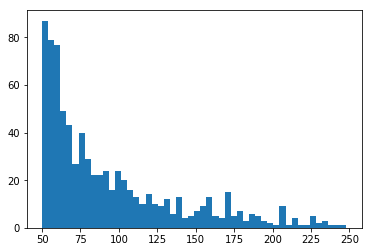

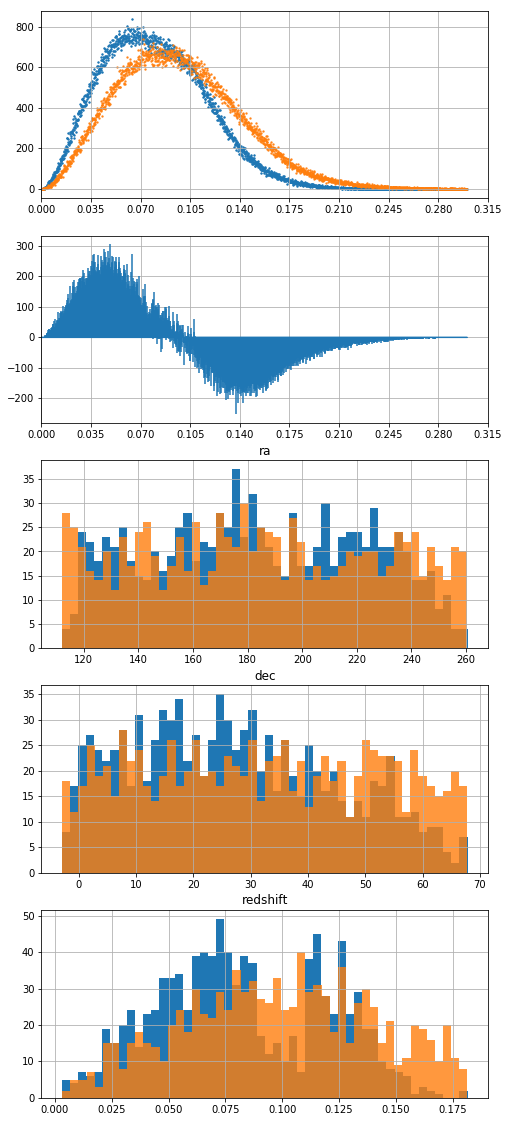

In [894]:
final_4_recounte_huge = final_res(xyz_subareas_4, result_4_bad_areas, 45, True, 15, 700)

result_4_area, result_4_labels = final_4_recounte_huge
result_4_center_clusters = centers_by_labels(result_4_area, result_4_labels)


#sil, cal_har, dav_bol = estimate_res(result_4_area, result_4_labels)
#print(sil, cal_har, dav_bol)

visual_estimate(result_4_labels);
plot_results(result_4_center_clusters, num_bins=2000, right_edge=0.3, mod_mix=4)


Total num clusters is 1510
Hugest clusters have [2218 1113 1047 1001  936  912  845  840]
More than 250 galaxies have 140 clusters
Less than 50 galaxies have 216 clusters


(1510,
 array([2218, 1113, 1047, 1001,  936,  912,  845,  840], dtype=int64),
 140,
 216,
 array([   13,    13,    15, ..., 35721, 35721, 35721], dtype=int64))

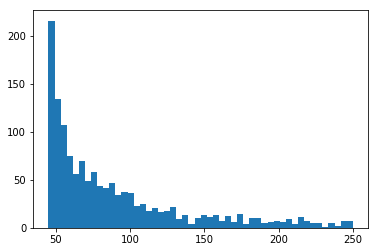

In [939]:
visual_estimate(result_3_labels)

In [895]:
sil, cal_har, dav_bol = estimate_res(result_4_area, result_4_labels)
print(sil, cal_har, dav_bol)

0.490548691814 59916.3866059 0.603462353711


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.139467887043 17726.8100226 0.775647695805
Total num clusters is 893
Hugest clusters have [28683 18634  4989  2713  1535  1366  1270  1151]
More than 250 galaxies have 79 clusters
Less than 50 galaxies have 125 clusters


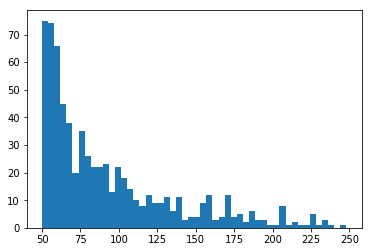

In [913]:
final_4_with_huge = final_res(xyz_subareas_4, result_4_bad_areas, 45, False)

sil, cal_har, dav_bol = estimate_res(final_3_with_huge[0], final_3_with_huge[1])
print(sil, cal_har, dav_bol)
visual_estimate(final_4_with_huge[1]);

Total num clusters is 1510
Hugest clusters have [2218 1113 1047 1001  936  912  845  840]
More than 250 galaxies have 140 clusters
Less than 50 galaxies have 216 clusters


(1510,
 array([2218, 1113, 1047, 1001,  936,  912,  845,  840], dtype=int64),
 140,
 216,
 array([   13,    13,    15, ..., 35721, 35721, 35721], dtype=int64))

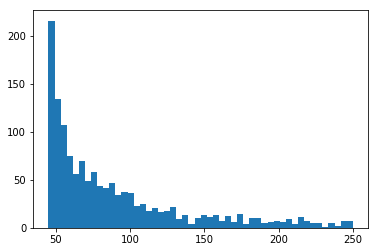

In [920]:
visual_estimate(result_3)

Total num clusters is 992
Hugest clusters have [2021  937  835  663  662  662  607  604]
More than 250 galaxies have 74 clusters
Less than 50 galaxies have 133 clusters


(992,
 array([2021,  937,  835,  663,  662,  662,  607,  604], dtype=int64),
 74,
 133,
 array([    0,     3,     3, ..., 30141, 30141, 30141], dtype=int64))

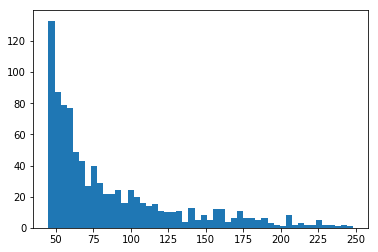

In [921]:
visual_estimate(result_4_labels)

In [903]:
sil, cal_har, dav_bol = estimate_res(*final_4_with_huge)
print(sil, cal_har, dav_bol)

0.083389295489 5854.59481584 0.675256531783


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [610]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1300,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_1 = dif_evol_on_subareas(xyz_subareas, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




 subarea_BB 0 !!!
expected clusters 329
eps = 0.00033  num_neighbors = 10.0
time: 2.258702039718628
4.72638333333 914.205357143 0 

num clusters = 12 num without dropping = 256
918.931740476
------------------------------------------

eps = 0.00093  num_neighbors = 35.0
time: 3.003272771835327
5.2806859375 371.491071429 0 

num clusters = 128 num without dropping = 170
376.771757366
------------------------------------------

eps = 0.00066  num_neighbors = 32.0
time: 2.4615862369537354
8.97403125 803.491071429 0 

num clusters = 32 num without dropping = 49
812.465102679
------------------------------------------

eps = 0.00074  num_neighbors = 15.0
time: 2.5215494632720947
6.16838979592 165.0625 0 

num clusters = 196 num without dropping = 779
171.230889796
------------------------------------------

eps = 0.00024  num_neighbors = 38.0
time: 2.2896862030029297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

e

eps = 0.00060  num_neighbors = 39.0
time: 2.8819265365600586
5.50268888889 931.428571429 0 

num clusters = 9 num without dropping = 10
936.931260317
------------------------------------------

eps = 0.00073  num_neighbors = 23.0
time: 2.843463897705078
4.83958761062 428.142857143 0 

num clusters = 113 num without dropping = 250
432.982444753
------------------------------------------

eps = 0.00036  num_neighbors = 24.0
time: 2.4395978450775146
84.02044 954.642857143 0 

num clusters = 5 num without dropping = 8
1038.66329714
------------------------------------------

eps = 0.00084  num_neighbors = 21.0
time: 3.2961080074310303
6.54289583333 174.919642857 0 

num clusters = 192 num without dropping = 453
181.46253869
------------------------------------------

eps = 0.00071  num_neighbors = 19.0
time: 2.500563859939575
4.7440608 382.5 0 

num clusters = 125 num without dropping = 368
387.2440608
------------------------------------------

eps = 0.00076  num_neighbors = 3.0
time: 3.2

eps = 0.00083  num_neighbors = 10.0
time: 3.755841016769409
23.790780198 7.42857142857 0 

num clusters = 303 num without dropping = 1908
31.2193516266
------------------------------------------

eps = 0.00082  num_neighbors = 14.0
time: 2.9363317489624023
15.8455229508 69.0625 0 

num clusters = 244 num without dropping = 1023
84.9080229508
------------------------------------------

eps = 0.00060  num_neighbors = 14.0
time: 2.317666530609131
14.2305596491 424.241071429 0 

num clusters = 114 num without dropping = 539
438.471631078
------------------------------------------

eps = 0.00093  num_neighbors = 25.0
time: 2.710461139678955
7.60542797927 172.428571429 0 

num clusters = 193 num without dropping = 360
180.033999408
------------------------------------------

eps = 0.00068  num_neighbors = 7.0
time: 2.5625011920928955
18.3918072727 28.9285714286 0 

num clusters = 275 num without dropping = 3367
47.3203787013
------------------------------------------

eps = 0.00063  num_neig

eps = 0.00025  num_neighbors = 22.0
time: 1.9249036312103271
7.22066666667 966.357142857 0 

num clusters = 3 num without dropping = 5
973.577809524
------------------------------------------

eps = 0.00097  num_neighbors = 6.0
time: 3.0242629051208496
23.6534162362 33.1428571429 0 

num clusters = 271 num without dropping = 3174
56.796273379
------------------------------------------

eps = 0.00030  num_neighbors = 23.0
time: 2.847365379333496
23.7944 972.241071429 0 

num clusters = 2 num without dropping = 10
996.035471429
------------------------------------------

eps = 0.00087  num_neighbors = 4.0
time: 4.919177532196045
26.272288968 23.1428571429 0 

num clusters = 281 num without dropping = 5605
49.4151461108
------------------------------------------

eps = 0.00076  num_neighbors = 13.0
time: 2.5165562629699707
7.75154585153 94.6428571429 0 

num clusters = 229 num without dropping = 1066
102.394402994
------------------------------------------

eps = 0.00021  num_neighbors = 

eps = 0.00076  num_neighbors = 6.0
time: 2.7834041118621826
21.6645487805 0.0625000000002 0 

num clusters = 328 num without dropping = 4147
21.7270487805
------------------------------------------

eps = 0.00097  num_neighbors = 17.0
time: 2.8843438625335693
9.53404657534 14.2053571429 0 

num clusters = 292 num without dropping = 865
23.7394037182
------------------------------------------

eps = 0.00099  num_neighbors = 18.0
time: 2.816375732421875
9.63562526316 19.6428571429 0 

num clusters = 285 num without dropping = 792
29.278482406
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 3.071237802505493
17945.6379138 77.1428571429 0 

num clusters = 239 num without dropping = 3611
18022.780771
------------------------------------------

eps = 0.00009  num_neighbors = 15.0
time: 1.7929701805114746
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 1

eps = 0.00018  num_neighbors = 8.0
time: 1.8889148235321045
5.8765 972.241071429 0 

num clusters = 2 num without dropping = 46
978.117571429
------------------------------------------

eps = 0.00038  num_neighbors = 25.0
time: 2.059816837310791
178.56475 960.491071429 0 

num clusters = 4 num without dropping = 12
1139.05582143
------------------------------------------

eps = 0.00090  num_neighbors = 10.0
time: 2.7963943481445312
16.5396219512 0.0625000000002 0 

num clusters = 328 num without dropping = 1960
16.6021219512
------------------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 2.774409532546997
12.9959442424 -0.0446428571425 0 

num clusters = 330 num without dropping = 1504
12.9513013853
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 2.8153860569000244
10.2962285714 5.0625 0 

num clusters = 308 num without dropping = 1175
15.3587285714
------------------------------------------

eps = 0.00058  num_neighbors = 11.

eps = 0.00094  num_neighbors = 12.0
time: 2.8593554496765137
13.823968323 0.8125 0 

num clusters = 322 num without dropping = 1501
14.636468323
------------------------------------------

eps = 0.00089  num_neighbors = 9.0
time: 2.7594153881073
16.8607504532 -0.0714285714284 0 

num clusters = 331 num without dropping = 2220
16.7893218817
------------------------------------------

eps = 0.00096  num_neighbors = 14.0
time: 2.857361078262329
10.9361993769 1.0 0 

num clusters = 321 num without dropping = 1214
11.9361993769
------------------------------------------

eps = 0.00096  num_neighbors = 14.0
time: 2.7993929386138916
10.7806532915 1.42857142857 0 

num clusters = 319 num without dropping = 1213
12.2092247201
------------------------------------------

eps = 0.00093  num_neighbors = 12.0
time: 2.8353919982910156
12.5231400612 0.142857142857 0 

num clusters = 327 num without dropping = 1496
12.665997204
------------------------------------------

eps = 0.00093  num_neighbors = 

eps = 0.00094  num_neighbors = 12.0
time: 3.322110652923584
13.0262030395 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1507
13.0262030395
------------------------------------------

eps = 0.00093  num_neighbors = 12.0
time: 2.8423898220062256
12.5875264438 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1502
12.5875264438
------------------------------------------

eps = 0.00096  num_neighbors = 14.0
time: 2.804409980773926
11.515763354 0.8125 0 

num clusters = 322 num without dropping = 1222
12.328263354
------------------------------------------

eps = 0.00097  num_neighbors = 14.0
time: 2.879347562789917
13.9315708978 0.642857142857 0 

num clusters = 323 num without dropping = 1220
14.5744280407
------------------------------------------

eps = 0.00093  num_neighbors = 14.0
time: 2.7824018001556396
10.1539907895 6.91964285714 0 

num clusters = 304 num without dropping = 1170
17.0736336466
------------------------------------------

eps = 0.00094

eps = 0.00095  num_neighbors = 14.0
time: 2.7943954467773438
10.4225610224 3.14285714286 0 

num clusters = 313 num without dropping = 1190
13.5654181652
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 3.6668949127197266
11.1648738462 0.357142857143 0 

num clusters = 325 num without dropping = 1333
11.5220167033
------------------------------------------

eps = 0.00095  num_neighbors = 13.0
time: 3.361072540283203
11.5470090634 -0.0714285714284 0 

num clusters = 331 num without dropping = 1353
11.475580492
------------------------------------------

eps = 0.00095  num_neighbors = 13.0
time: 2.8513636589050293
11.9329647416 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1351
11.9329647416
------------------------------------------

eps = 0.00095  num_neighbors = 13.0
time: 2.8473668098449707
12.5110679012 0.491071428572 0 

num clusters = 324 num without dropping = 1338
13.0021393298
------------------------------------------

eps

eps = 0.00094  num_neighbors = 13.0
time: 2.7564377784729004
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.8084006309509277
11.1310486322 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1310486322
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.7694284915924072
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00001  num_neighbors = 13.0
time: 1.7340047359466553
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 13.0
time: 2.10878849029541
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 1

eps = 0.00094  num_neighbors = 13.0
time: 2.7644145488739014
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.8063905239105225
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.8243987560272217
11.1310486322 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1310486322
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.753422260284424
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 2.8213798999786377
11.1306468085 1.13686837722e-13 0 

num clusters = 329 num without dropping = 1339
11.1306468085
-----------------------------------

eps = 0.00074  num_neighbors = 27.0
time: 2.309675455093384
26.0897515789 468.772189349 0 

num clusters = 95 num without dropping = 167
494.861940928
------------------------------------------

eps = 0.00042  num_neighbors = 23.0
time: 1.9518790245056152
15.2311875 881.535502959 0 

num clusters = 16 num without dropping = 29
896.766690459
------------------------------------------

eps = 0.00086  num_neighbors = 16.0
time: 2.5105738639831543
25.4811339623 94.926035503 0 

num clusters = 212 num without dropping = 716
120.407169465
------------------------------------------

eps = 0.00070  num_neighbors = 12.0
time: 2.3886260986328125
12.9015005128 131.642011834 0 

num clusters = 195 num without dropping = 1040
144.543512347
------------------------------------------

eps = 0.00066  num_neighbors = 27.0
time: 2.2387168407440186
27.8032526316 651.183431953 0 

num clusters = 57 num without dropping = 98
678.986684584
------------------------------------------

eps = 0.00084  num_neigh

eps = 0.00058  num_neighbors = 10.0
time: 2.1777701377868652
26.1599863946 267.618343195 0 

num clusters = 147 num without dropping = 1216
293.77832959
------------------------------------------

eps = 0.00045  num_neighbors = 19.0
time: 2.0188417434692383
27.4428 863.5 0 

num clusters = 19 num without dropping = 81
890.9428
------------------------------------------

eps = 0.00068  num_neighbors = 28.0
time: 2.281688928604126
27.0463322581 625.473372781 0 

num clusters = 62 num without dropping = 96
652.519705039
------------------------------------------

eps = 0.00048  num_neighbors = 4.0
time: 2.204751491546631
14.3462010582 146.029585799 0 

num clusters = 189 num without dropping = 7344
160.375786857
------------------------------------------

eps = 0.00063  num_neighbors = 5.0
time: 2.397643804550171
15.2184541485 64.1952662722 0 

num clusters = 229 num without dropping = 4894
79.4137204207
------------------------------------------

eps = 0.00070  num_neighbors = 8.0
time: 

eps = 0.00079  num_neighbors = 5.0
time: 2.623491048812866
44.5034775665 20.6893491124 0 

num clusters = 263 num without dropping = 4296
65.192826679
------------------------------------------

eps = 0.00071  num_neighbors = 9.0
time: 2.4266271591186523
10.9111704036 74.3579881657 0 

num clusters = 223 num without dropping = 1781
85.2691585693
------------------------------------------

eps = 0.00087  num_neighbors = 13.0
time: 2.5735223293304443
18.0254763158 65.8372781065 0 

num clusters = 228 num without dropping = 1037
83.8627544223
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 2.528548240661621
21.162188 34.4970414201 0 

num clusters = 250 num without dropping = 4696
55.6592294201
------------------------------------------

eps = 0.00083  num_neighbors = 6.0
time: 2.650479316711426
40.3024054687 27.6893491124 0 

num clusters = 256 num without dropping = 3269
67.9917545812
------------------------------------------

eps = 0.00080  num_nei

eps = 0.00076  num_neighbors = 5.0
time: 2.578538417816162
26.3381375 27.6893491124 0 

num clusters = 256 num without dropping = 4564
54.0274866124
------------------------------------------

eps = 0.00081  num_neighbors = 5.0
time: 2.742424964904785
50.7623625 27.6893491124 0 

num clusters = 256 num without dropping = 4259
78.4517116124
------------------------------------------

eps = 0.00076  num_neighbors = 18.0
time: 2.416632652282715
14.7423451613 153.50295858 0 

num clusters = 186 num without dropping = 503
168.245303741
------------------------------------------

eps = 0.00071  num_neighbors = 6.0
time: 2.5019257068634033
10.5582149378 46.1065088757 0 

num clusters = 241 num without dropping = 3537
56.6647238135
------------------------------------------

eps = 0.00067  num_neighbors = 24.0
time: 2.263700246810913
24.9782765432 532.49704142 0 

num clusters = 81 num without dropping = 177
557.475317963
------------------------------------------

eps = 0.00070  num_neighbors

eps = 0.00073  num_neighbors = 6.0
time: 2.5215537548065186
13.0056120482 35.7041420118 0 

num clusters = 249 num without dropping = 3520
48.70975406
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.455587863922119
13.0090987952 35.7041420118 0 

num clusters = 249 num without dropping = 3520
48.713240807
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.5105605125427246
12.9727163347 33.3106508876 0 

num clusters = 251 num without dropping = 3521
46.2833672222
------------------------------------------

eps = 0.00080  num_neighbors = 8.0
time: 2.569545269012451
16.3214491525 53.2810650888 0 

num clusters = 236 num without dropping = 2268
69.6025142413
------------------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 2.8203811645507812
27.410795539 15.4970414201 0 

num clusters = 269 num without dropping = 6133
42.9078369592
------------------------------------------

eps = 0.00075  num_ne

eps = 0.00074  num_neighbors = 6.0
time: 2.5265684127807617
14.2326939759 35.7041420118 0 

num clusters = 249 num without dropping = 3519
49.9368359877
------------------------------------------

eps = 0.00076  num_neighbors = 7.0
time: 2.5475401878356934
16.7404895397 48.9142011834 0 

num clusters = 239 num without dropping = 2804
65.6546907232
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 2.5675458908081055
14.0226867769 44.7337278107 0 

num clusters = 242 num without dropping = 2809
58.7564145875
------------------------------------------

eps = 0.00070  num_neighbors = 4.0
time: 2.509559154510498
18.015536255 33.3106508876 0 

num clusters = 251 num without dropping = 6515
51.3261871426
------------------------------------------

eps = 0.00072  num_neighbors = 6.0
time: 2.512557029724121
10.8230473896 35.7041420118 0 

num clusters = 249 num without dropping = 3526
46.5271894014
------------------------------------------

eps = 0.00072  num

eps = 0.00078  num_neighbors = 6.0
time: 2.6264922618865967
24.7839689922 25.5857988166 0 

num clusters = 258 num without dropping = 3421
50.3697678088
------------------------------------------

eps = 0.00077  num_neighbors = 7.0
time: 2.5425400733947754
14.0062694215 44.7337278107 0 

num clusters = 242 num without dropping = 2809
58.7399972321
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 2.5455384254455566
20.5199412698 32.1449704142 0 

num clusters = 252 num without dropping = 4711
52.664911684
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.4855728149414062
12.8807239216 28.7721893491 0 

num clusters = 255 num without dropping = 3525
41.6529132707
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 2.5595316886901855
21.3138596078 28.7721893491 0 

num clusters = 255 num without dropping = 4697
50.086048957
------------------------------------------

eps = 0.00074  nu

eps = 0.00077  num_neighbors = 7.0
time: 2.561547040939331
17.57853361 46.1065088757 0 

num clusters = 241 num without dropping = 2802
63.6850424857
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 2.451592206954956
13.6259098039 28.7721893491 0 

num clusters = 255 num without dropping = 3514
42.398099153
------------------------------------------

eps = 0.00073  num_neighbors = 6.0
time: 3.3890559673309326
12.9289604743 31.0 0 

num clusters = 253 num without dropping = 3525
43.9289604743
------------------------------------------

eps = 0.00077  num_neighbors = 9.0
time: 3.1242053508758545
15.3523957447 54.7781065089 0 

num clusters = 235 num without dropping = 1882
70.1305022536
------------------------------------------

eps = 0.00073  num_neighbors = 7.0
time: 2.4915785789489746
17.1201291139 51.8047337278 0 

num clusters = 237 num without dropping = 2808
68.9248628417
------------------------------------------

eps = 0.00072  num_neighbors 

eps = 0.00075  num_neighbors = 6.0
time: 2.633488416671753
15.3575821705 25.5857988166 0 

num clusters = 258 num without dropping = 3510
40.9433809871
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.514556407928467
17.5620226562 27.6893491124 0 

num clusters = 256 num without dropping = 3507
45.2513717687
------------------------------------------

eps = 0.00074  num_neighbors = 6.0
time: 2.505561113357544
14.7673105691 39.449704142 0 

num clusters = 246 num without dropping = 3511
54.2170147111
------------------------------------------

eps = 0.00074  num_neighbors = 6.0
time: 2.5435421466827393
14.3165352227 38.1804733728 0 

num clusters = 247 num without dropping = 3516
52.4970085955
------------------------------------------

eps = 0.00076  num_neighbors = 6.0
time: 2.5555312633514404
20.1233549618 21.6272189349 0 

num clusters = 262 num without dropping = 3492
41.7505738967
------------------------------------------

eps = 0.00075  num_

eps = 0.00075  num_neighbors = 6.0
time: 2.75543475151062
15.3529434109 25.5857988166 0 

num clusters = 258 num without dropping = 3507
40.9387422274
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.5855343341827393
15.3508883721 25.5857988166 0 

num clusters = 258 num without dropping = 3508
40.9366871887
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.657470703125
15.3508883721 25.5857988166 0 

num clusters = 258 num without dropping = 3508
40.9366871887
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.578519582748413
15.3529434109 25.5857988166 0 

num clusters = 258 num without dropping = 3507
40.9387422274
------------------------------------------

eps = 0.00075  num_neighbors = 6.0
time: 2.586524486541748
15.3508883721 25.5857988166 0 

num clusters = 258 num without dropping = 3508
40.9366871887
------------------------------------------

eps = 0.00075  num_neig

eps = 0.00086  num_neighbors = 31.0
time: 2.2537055015563965
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00022  num_neighbors = 28.0
time: 2.032832384109497
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00031  num_neighbors = 37.0
time: 2.087800979614258
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 23.0
time: 2.463587760925293
6.7424 1026.0 0 

num clusters = 1 num without dropping = 10
1032.7424
------------------------------------------

eps = 0.00053  num_neighbors = 4.0
time: 2.5525238513946533
7.665 1026.0 0 

num clusters = 1 num without dropping = 2769
1033.665
------------------------------------------

eps = 0.00047  num_neighbors = 10.0
time: 2.2317185401916504
5000000.0 5000000.0 0 

num clusters = 0 num 

eps = 0.00083  num_neighbors = 21.0
time: 2.2007555961608887
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00002  num_neighbors = 19.0
time: 1.88092041015625
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 30.0
time: 2.2736945152282715
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 9.0
time: 2.251706838607788
5.28081904762 916.111111111 0 

num clusters = 21 num without dropping = 628
921.391930159
------------------------------------------

eps = 0.00098  num_neighbors = 28.0
time: 2.3076751232147217
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00081  num_neighbors = 12.0
time: 2.5695242881774902
6.8296 1009.12 0 



eps = 0.00099  num_neighbors = 9.0
time: 2.3166897296905518
4.91073793103 729.22 0 

num clusters = 58 num without dropping = 1049
734.130737931
------------------------------------------

eps = 0.00078  num_neighbors = 15.0
time: 2.1957364082336426
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 29
10000000.0
------------------------------------------

eps = 0.00048  num_neighbors = 28.0
time: 2.0788064002990723
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 23.0
time: 2.1877403259277344
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00004  num_neighbors = 15.0
time: 1.9089059829711914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00079  num_neighbors = 16.0
time: 2.3046727180480957
5000000.0 5000000.0 0

eps = 0.00058  num_neighbors = 38.0
time: 2.1127891540527344
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 14.0
time: 2.2786917686462402
5.02322352941 937.591111111 0 

num clusters = 17 num without dropping = 196
942.614334641
------------------------------------------

eps = 0.00095  num_neighbors = 14.0
time: 2.2916810512542725
5.6174 948.424444444 0 

num clusters = 15 num without dropping = 164
954.041844444
------------------------------------------

eps = 0.00060  num_neighbors = 6.0
time: 2.731431484222412
6.94013333333 1014.73111111 0 

num clusters = 3 num without dropping = 844
1021.67124444
------------------------------------------

eps = 0.00016  num_neighbors = 5.0
time: 2.5665268898010254
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00044  num_neighbors = 14.0
time: 2.105790376663208

eps = 0.00095  num_neighbors = 26.0
time: 2.2696971893310547
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00084  num_neighbors = 6.0
time: 2.2447118759155273
5.355132 767.824444444 0 

num clusters = 50 num without dropping = 2187
773.179576444
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 2.264699935913086
5.15684285714 953.864444444 0 

num clusters = 14 num without dropping = 208
959.021287302
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.1587631702423096
5.95338 975.78 0 

num clusters = 10 num without dropping = 2256
981.73338
------------------------------------------

eps = 0.00097  num_neighbors = 4.0
time: 2.4186322689056396
4.81196081081 363.52 0 

num clusters = 148 num without dropping = 7074
368.331960811
------------------------------------------

eps = 0.00073  num_neighbors = 31.0
time: 2.164759397506714
500

eps = 0.00049  num_neighbors = 4.0
time: 2.640483856201172
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2208
10000000.0
------------------------------------------

eps = 0.00006  num_neighbors = 8.0
time: 2.6085028648376465
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00057  num_neighbors = 4.0
time: 2.255706310272217
6.8877 1009.12 0 

num clusters = 4 num without dropping = 3289
1016.0077
------------------------------------------

eps = 0.00084  num_neighbors = 27.0
time: 2.222723960876465
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.3606646060943604
4.91570136986 370.277777778 0 

num clusters = 146 num without dropping = 7158
375.193479148
------------------------------------------

eps = 0.00091  num_neighbors = 39.0
time: 2.2686972618103027
5000000.0 5000000.0 

eps = 0.00054  num_neighbors = 3.0
time: 2.1457865238189697
7.49755 1009.12 0 

num clusters = 4 num without dropping = 7510
1016.61755
------------------------------------------

eps = 0.00077  num_neighbors = 6.0
time: 2.212747812271118
5.79559130435 905.464444444 0 

num clusters = 23 num without dropping = 1781
911.260035749
------------------------------------------

eps = 0.00072  num_neighbors = 5.0
time: 2.2956998348236084
5.68702 921.457777778 0 

num clusters = 20 num without dropping = 2740
927.144797778
------------------------------------------

eps = 0.00012  num_neighbors = 23.0
time: 1.9508771896362305
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.4635870456695557
5.92760782123 266.731111111 0 

num clusters = 179 num without dropping = 12982
272.658718932
------------------------------------------

eps = 0.00020  num_neighbors = 14.0
time: 1.95887756347

eps = 0.00097  num_neighbors = 3.0
time: 2.467604160308838
5.70618993711 327.464444444 0 

num clusters = 159 num without dropping = 12898
333.170634382
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.5875346660614014
5.96451620112 266.731111111 0 

num clusters = 179 num without dropping = 12986
272.695627312
------------------------------------------

eps = 0.00061  num_neighbors = 3.0
time: 2.197758913040161
5.56861666667 964.791111111 0 

num clusters = 12 num without dropping = 9035
970.359727778
------------------------------------------

eps = 0.00099  num_neighbors = 14.0
time: 2.333662271499634
5.25881818182 910.78 0 

num clusters = 22 num without dropping = 207
916.038818182
------------------------------------------

eps = 0.00097  num_neighbors = 27.0
time: 2.267697811126709
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 3.0
time: 

eps = 0.00100  num_neighbors = 3.0
time: 2.478579521179199
5.94584632768 272.524444444 0 

num clusters = 177 num without dropping = 12982
278.470290772
------------------------------------------

eps = 0.00071  num_neighbors = 3.0
time: 2.3026793003082275
5.14731333333 868.691111111 0 

num clusters = 30 num without dropping = 10836
873.838424444
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.4216299057006836
5.94584632768 272.524444444 0 

num clusters = 177 num without dropping = 12982
278.470290772
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.4835762977600098
5.94980893855 266.731111111 0 

num clusters = 179 num without dropping = 12986
272.68092005
------------------------------------------

eps = 0.00011  num_neighbors = 25.0
time: 1.918900728225708
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors =

eps = 0.00042  num_neighbors = 5.0
time: 1.7280075550079346
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 308
10000000.0
------------------------------------------

eps = 0.00056  num_neighbors = 17.0
time: 1.7449979782104492
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00007  num_neighbors = 16.0
time: 1.6010799407958984
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00042  num_neighbors = 15.0
time: 1.72700834274292
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00020  num_neighbors = 21.0
time: 1.6458964347839355
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00065  num_neighbors = 7.0
time: 1.8199548721313477
4.74408 949.26035503 0 

num cl

eps = 0.00062  num_neighbors = 36.0
time: 1.806962490081787
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00086  num_neighbors = 27.0
time: 1.8879368305206299
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00088  num_neighbors = 6.0
time: 1.929893970489502
6.50324848485 781.798816568 0 

num clusters = 33 num without dropping = 1900
788.302065053
------------------------------------------

eps = 0.00042  num_neighbors = 5.0
time: 1.737001895904541
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 308
10000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 1.9518847465515137
4.41225263158 863.5 0 

num clusters = 19 num without dropping = 297
867.912252632
------------------------------------------

eps = 0.00007  num_neighbors = 5.0
time: 1.6080658435821533
5000000.0 50

eps = 0.00010  num_neighbors = 38.0
time: 1.6090929508209229
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 19.0
time: 1.8439407348632812
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00080  num_neighbors = 8.0
time: 1.8659286499023438
4.63562666667 887.588757396 0 

num clusters = 15 num without dropping = 550
892.224384063
------------------------------------------

eps = 0.00072  num_neighbors = 12.0
time: 1.846759557723999
5.0185 968.165680473 0 

num clusters = 2 num without dropping = 54
973.184180473
------------------------------------------

eps = 0.00097  num_neighbors = 14.0
time: 1.929891586303711
4.346775 881.535502959 0 

num clusters = 16 num without dropping = 130
885.882277959
------------------------------------------

eps = 0.00084  num_neighbors = 38.0
time: 2.241710662841797
50000

eps = 0.00097  num_neighbors = 4.0
time: 2.0598371028900146
20.1136785714 518.5 0 

num clusters = 84 num without dropping = 5841
538.613678571
------------------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 1.863950252532959
5.75774 857.529585799 0 

num clusters = 20 num without dropping = 2366
863.287325799
------------------------------------------

eps = 0.00097  num_neighbors = 8.0
time: 1.974881887435913
6.49715789474 753.603550296 0 

num clusters = 38 num without dropping = 1030
760.100708191
------------------------------------------

eps = 0.00097  num_neighbors = 30.0
time: 1.9338891506195068
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00061  num_neighbors = 37.0
time: 1.7949678897857666
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 6.0
time: 1.9578759670257568
8.81

eps = 0.00079  num_neighbors = 7.0
time: 1.8669283390045166
5.21632380952 851.579881657 0 

num clusters = 21 num without dropping = 878
856.796205466
------------------------------------------

eps = 0.00095  num_neighbors = 5.0
time: 1.9658899307250977
15.5453754386 651.183431953 0 

num clusters = 57 num without dropping = 3496
666.728807391
------------------------------------------

eps = 0.00094  num_neighbors = 7.0
time: 1.9498803615570068
6.27991707317 736.934911243 0 

num clusters = 41 num without dropping = 1440
743.214828316
------------------------------------------

eps = 0.00035  num_neighbors = 4.0
time: 1.7090184688568115
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 572
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 23.0
time: 1.956878423690796
3.53373333333 961.843195266 0 

num clusters = 3 num without dropping = 13
965.3769286
------------------------------------------

eps = 0.00044  num_neighbors = 34.0
tim

eps = 0.00088  num_neighbors = 7.0
time: 1.910905361175537
4.61563333333 798.964497041 0 

num clusters = 30 num without dropping = 1198
803.580130375
------------------------------------------

eps = 0.00067  num_neighbors = 6.0
time: 1.8259515762329102
5.07968571429 936.76035503 0 

num clusters = 7 num without dropping = 924
941.840040744
------------------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 1.9758660793304443
16.7045238095 620.393491124 0 

num clusters = 63 num without dropping = 3554
637.098014934
------------------------------------------

eps = 0.00076  num_neighbors = 7.0
time: 1.8579323291778564
5.69161052632 863.5 0 

num clusters = 19 num without dropping = 773
869.191610526
------------------------------------------

eps = 0.00063  num_neighbors = 7.0
time: 1.8049635887145996
5.49756 949.26035503 0 

num clusters = 5 num without dropping = 404
954.75791503
------------------------------------------

eps = 0.00096  num_neighbors = 19.0
time: 1

eps = 0.00098  num_neighbors = 5.0
time: 1.9888741970062256
18.9803861111 575.606508876 0 

num clusters = 72 num without dropping = 3660
594.586894987
------------------------------------------

eps = 0.00094  num_neighbors = 4.0
time: 1.9718854427337646
15.0367783784 565.881656805 0 

num clusters = 74 num without dropping = 5720
580.918435183
------------------------------------------

eps = 0.00095  num_neighbors = 4.0
time: 2.05082106590271
17.5322311688 551.449704142 0 

num clusters = 77 num without dropping = 5763
568.981935311
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.079803228378296
13.0720717949 376.834319527 0 

num clusters = 117 num without dropping = 11014
389.906391321
------------------------------------------

eps = 0.00014  num_neighbors = 4.0
time: 1.6280641555786133
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 10.0


eps = 0.00086  num_neighbors = 31.0
time: 1.898909091949463
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 25.0
time: 1.8849236965179443
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00076  num_neighbors = 5.0
time: 1.9318928718566895
5.69493913043 839.74260355 0 

num clusters = 23 num without dropping = 2456
845.437542681
------------------------------------------

eps = 0.00065  num_neighbors = 3.0
time: 1.8519532680511475
5.27273333333 869.49112426 0 

num clusters = 18 num without dropping = 8070
874.763857594
------------------------------------------

eps = 0.00008  num_neighbors = 6.0
time: 1.6210711002349854
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00010  num_neighbors = 3.0
time: 1.6300811767578125
500000

eps = 0.00099  num_neighbors = 34.0
time: 1.9958529472351074
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 2.091799736022949
21.7281955556 491.065088757 0 

num clusters = 90 num without dropping = 5893
512.793284313
------------------------------------------

eps = 0.00056  num_neighbors = 10.0
time: 1.794969081878662
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 29
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 3.0
time: 2.02583909034729
21.0817942308 429.949704142 0 

num clusters = 104 num without dropping = 10971
451.031498373
------------------------------------------

eps = 0.00028  num_neighbors = 4.0
time: 1.6750383377075195
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 176
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.1497690677642822
12

In [631]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1300,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_2 = dif_evol_on_subareas(xyz_subareas_5, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




 subarea_BB 0 !!!
expected clusters 288
eps = 0.00047  num_neighbors = 39.0
time: 2.016862630844116
209.60915 997.944444444 0 

num clusters = 4 num without dropping = 4
1207.55359444
------------------------------------------

eps = 0.00034  num_neighbors = 24.0
time: 4.025686502456665
58.02304 990.991319444 0 

num clusters = 5 num without dropping = 7
1049.01435944
------------------------------------------

eps = 0.00030  num_neighbors = 13.0
time: 2.9473071098327637
123.68712 990.991319444 0 

num clusters = 5 num without dropping = 47
1114.67843944
------------------------------------------

eps = 0.00064  num_neighbors = 20.0
time: 3.3990514278411865
11.9939139535 508.506944444 0 

num clusters = 86 num without dropping = 241
520.500858398
------------------------------------------

eps = 0.00018  num_neighbors = 26.0
time: 1.8389472961425781
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00022 

eps = 0.00087  num_neighbors = 22.0
time: 2.3416712284088135
6.99688020305 106.324652778 0 

num clusters = 197 num without dropping = 417
113.321532981
------------------------------------------

eps = 0.00081  num_neighbors = 5.0
time: 2.521552085876465
31.228569338 0.0746527777776 0 

num clusters = 287 num without dropping = 4051
31.3032221158
------------------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 3.1192290782928467
17380.5109042 73.046875 0 

num clusters = 213 num without dropping = 2999
17453.5577792
------------------------------------------

eps = 0.00040  num_neighbors = 18.0
time: 2.4585893154144287
5.02908 956.590277778 0 

num clusters = 10 num without dropping = 43
961.619357778
------------------------------------------

eps = 0.00089  num_neighbors = 17.0
time: 2.7694292068481445
11.9125221311 26.2777777778 0 

num clusters = 244 num without dropping = 729
38.1902999089
------------------------------------------

eps = 0.00089  num_neighbor

eps = 0.00009  num_neighbors = 17.0
time: 1.5451123714447021
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 14.0
time: 2.6035256385803223
18.2599969466 9.84027777778 0 

num clusters = 262 num without dropping = 1013
28.1002747243
------------------------------------------

eps = 0.00032  num_neighbors = 16.0
time: 1.7899720668792725
99.71616 990.991319444 0 

num clusters = 5 num without dropping = 26
1090.70747944
------------------------------------------

eps = 0.00092  num_neighbors = 10.0
time: 2.599508047103882
18.4173329114 7.77777777778 0 

num clusters = 316 num without dropping = 1661
26.1951106892
------------------------------------------

eps = 0.00093  num_neighbors = 19.0
time: 2.444148063659668
16.1613616327 25.1579861111 0 

num clusters = 245 num without dropping = 628
41.3193477438
------------------------------------------

eps = 0.00042  num_neighbors = 18.0
ti

eps = 0.00081  num_neighbors = 9.0
time: 2.6184961795806885
18.5781744966 0.590277777778 0 

num clusters = 298 num without dropping = 2021
19.1684522744
------------------------------------------

eps = 0.00080  num_neighbors = 10.0
time: 3.2681217193603516
20.3198596491 0.296875 0 

num clusters = 285 num without dropping = 1722
20.6167346491
------------------------------------------

eps = 0.00059  num_neighbors = 18.0
time: 2.2117302417755127
9.06253972603 575.199652778 0 

num clusters = 73 num without dropping = 248
584.262192504
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.452594518661499
15.1743130435 2.5 0 

num clusters = 276 num without dropping = 1038
17.6743130435
------------------------------------------

eps = 0.00084  num_neighbors = 11.0
time: 2.464607000350952
21.5850374558 0.616319444444 0 

num clusters = 283 num without dropping = 1516
22.2013569003
------------------------------------------

eps = 0.00095  num_neighbors

eps = 0.00097  num_neighbors = 13.0
time: 2.5465564727783203
16.1790751678 0.590277777778 0 

num clusters = 298 num without dropping = 1210
16.7693529456
------------------------------------------

eps = 0.00099  num_neighbors = 13.0
time: 2.6654868125915527
18.140069967 1.796875 0 

num clusters = 303 num without dropping = 1208
19.936944967
------------------------------------------

eps = 0.00097  num_neighbors = 13.0
time: 2.568545341491699
16.1790751678 0.590277777778 0 

num clusters = 298 num without dropping = 1210
16.7693529456
------------------------------------------

eps = 0.00029  num_neighbors = 16.0
time: 1.7080192565917969
44.9767 984.0625 0 

num clusters = 6 num without dropping = 20
1029.0392
------------------------------------------

eps = 0.00091  num_neighbors = 12.0
time: 2.5185739994049072
12.1992417508 0.421875 0 

num clusters = 297 num without dropping = 1335
12.6211167508
------------------------------------------

eps = 0.00095  num_neighbors = 16.0
time

eps = 0.00092  num_neighbors = 15.0
time: 2.5235512256622314
16.3593257353 4.11111111111 0 

num clusters = 272 num without dropping = 947
20.4704368464
------------------------------------------

eps = 0.00098  num_neighbors = 17.0
time: 2.5155582427978516
10.6339624549 2.15798611111 0 

num clusters = 277 num without dropping = 826
12.791948566
------------------------------------------

eps = 0.00048  num_neighbors = 15.0
time: 1.8849172592163086
7.85088 825.0625 0 

num clusters = 30 num without dropping = 212
832.91338
------------------------------------------

eps = 0.00091  num_neighbors = 12.0
time: 2.5555331707000732
12.0914160535 0.782986111111 0 

num clusters = 299 num without dropping = 1335
12.8744021646
------------------------------------------

eps = 0.00090  num_neighbors = 12.0
time: 2.450167179107666
12.2419803509 0.296875 0 

num clusters = 285 num without dropping = 1334
12.5388553509
------------------------------------------

eps = 0.00093  num_neighbors = 14.0

eps = 0.00093  num_neighbors = 14.0
time: 2.7064661979675293
10.1166759857 1.546875 0 

num clusters = 279 num without dropping = 1065
11.6635509857
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 3.424034833908081
10.6651766323 -0.0781250000002 0 

num clusters = 291 num without dropping = 1083
10.5870516323
------------------------------------------

eps = 0.00088  num_neighbors = 11.0
time: 2.674466371536255
12.7839535836 -0.00868055555566 0 

num clusters = 293 num without dropping = 1508
12.7752730281
------------------------------------------

eps = 0.00092  num_neighbors = 13.0
time: 2.477595090866089
10.6917919732 0.782986111111 0 

num clusters = 299 num without dropping = 1210
11.4747780844
------------------------------------------

eps = 0.00088  num_neighbors = 13.0
time: 2.4945852756500244
17.5201021739 2.5 0 

num clusters = 276 num without dropping = 1188
20.0201021739
------------------------------------------

eps = 0.00094  num_n

eps = 0.00093  num_neighbors = 14.0
time: 2.5625457763671875
10.1319433692 1.546875 0 

num clusters = 279 num without dropping = 1069
11.6788183692
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 2.4805774688720703
11.5834909091 3.61111111111 0 

num clusters = 308 num without dropping = 1214
15.1946020202
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.5475358963012695
13.9459494585 2.15798611111 0 

num clusters = 277 num without dropping = 1049
16.1039355696
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.4626071453094482
14.1625782609 2.5 0 

num clusters = 276 num without dropping = 1054
16.6625782609
------------------------------------------

eps = 0.00093  num_neighbors = 14.0
time: 2.560546398162842
10.1319433692 1.546875 0 

num clusters = 279 num without dropping = 1069
11.6788183692
------------------------------------------

eps = 0.00095  num_neighbors = 

eps = 0.00089  num_neighbors = 12.0
time: 2.457609176635742
14.6594985816 0.8125 0 

num clusters = 282 num without dropping = 1333
15.4719985816
------------------------------------------

eps = 0.00089  num_neighbors = 12.0
time: 2.5285511016845703
14.6594985816 0.8125 0 

num clusters = 282 num without dropping = 1333
15.4719985816
------------------------------------------

eps = 0.00089  num_neighbors = 13.0
time: 2.4196105003356934
15.1066524823 0.8125 0 

num clusters = 282 num without dropping = 1185
15.9191524823
------------------------------------------

eps = 0.00092  num_neighbors = 13.0
time: 2.5305464267730713
10.695148495 0.782986111111 0 

num clusters = 299 num without dropping = 1209
11.4781346061
------------------------------------------

eps = 0.00091  num_neighbors = 14.0
time: 2.4556102752685547
14.923410989 3.671875 0 

num clusters = 273 num without dropping = 1038
18.595285989
------------------------------------------

eps = 0.00098  num_neighbors = 16.0
tim

eps = 0.00093  num_neighbors = 14.0
time: 3.267125129699707
10.2351411348 0.8125 0 

num clusters = 282 num without dropping = 1076
11.0476411348
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 3.067258358001709
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1080
10.4777814559
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 2.4486145973205566
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1079
10.4777814559
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 2.708465337753296
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1080
10.4777814559
------------------------------------------

expected clusters were 288



 subarea_BB 1 !!!
expected clusters 272
eps = 0.00058  num_neighbors = 29.0
time: 1.8849194049835205
27.7871103448 870.582644628 0 

num clusters = 29 num without dropping = 45
89

eps = 0.00070  num_neighbors = 26.0
time: 2.2726941108703613
25.0109976471 518.5 0 

num clusters = 85 num without dropping = 158
543.510997647
------------------------------------------

eps = 0.00025  num_neighbors = 16.0
time: 1.730006456375122
4.4525 1072.74793388 0 

num clusters = 2 num without dropping = 9
1077.20043388
------------------------------------------

eps = 0.00006  num_neighbors = 15.0
time: 1.5441133975982666
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 22.0
time: 2.2267229557037354
26.4202913043 480.867768595 0 

num clusters = 92 num without dropping = 223
507.288059899
------------------------------------------

eps = 0.00067  num_neighbors = 21.0
time: 2.225742816925049
26.0331742574 434.566115702 0 

num clusters = 101 num without dropping = 254
460.59928996
------------------------------------------

eps = 0.00063  num_neighbors = 28.0
time: 2.3136696815

eps = 0.00077  num_neighbors = 32.0
time: 2.1667494773864746
28.8803358025 540.640495868 0 

num clusters = 81 num without dropping = 120
569.52083167
------------------------------------------

eps = 0.00056  num_neighbors = 9.0
time: 2.039849281311035
26.6958344371 220.0 0 

num clusters = 151 num without dropping = 1413
246.695834437
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 2.147768020629883
12.7555312217 41.0950413223 0 

num clusters = 221 num without dropping = 3269
53.850572544
------------------------------------------

eps = 0.00036  num_neighbors = 35.0
time: 2.207732677459717
2.9505 1072.74793388 0 

num clusters = 2 num without dropping = 2
1075.69843388
------------------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 3.1572072505950928
14.517437037 49.173553719 0 

num clusters = 216 num without dropping = 1264
63.690990756
------------------------------------------

eps = 0.00065  num_neighbors = 29.0
time: 

eps = 0.00053  num_neighbors = 5.0
time: 2.0268571376800537
20.1537147208 86.4669421488 0 

num clusters = 197 num without dropping = 4473
106.62065687
------------------------------------------

eps = 0.00062  num_neighbors = 9.0
time: 2.1457860469818115
16.5717636364 110.289256198 0 

num clusters = 187 num without dropping = 1567
126.861019835
------------------------------------------

eps = 0.00078  num_neighbors = 15.0
time: 2.2197444438934326
19.23453 79.8842975207 0 

num clusters = 200 num without dropping = 739
99.1188275207
------------------------------------------

eps = 0.00040  num_neighbors = 4.0
time: 1.8009848594665527
20.1561 344.512396694 0 

num clusters = 120 num without dropping = 6128
364.668496694
------------------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.557551622390747
66.0605050691 47.5 0 

num clusters = 217 num without dropping = 1490
113.560505069
------------------------------------------

eps = 0.00078  num_neighbors = 15.0
t

eps = 0.00066  num_neighbors = 8.0
time: 2.0981638431549072
15.9465990698 50.8760330579 0 

num clusters = 215 num without dropping = 2045
66.8226321276
------------------------------------------

eps = 0.00070  num_neighbors = 7.0
time: 2.2281405925750732
10.5346198276 25.867768595 0 

num clusters = 232 num without dropping = 2599
36.4023884226
------------------------------------------

eps = 0.00072  num_neighbors = 7.0
time: 2.167757511138916
15.6148917031 29.673553719 0 

num clusters = 229 num without dropping = 2550
45.2884454221
------------------------------------------

eps = 0.00041  num_neighbors = 7.0
time: 2.2467095851898193
20.8637558824 615.79338843 0 

num clusters = 68 num without dropping = 1547
636.657144312
------------------------------------------

eps = 0.00092  num_neighbors = 7.0
time: 3.4979915618896484
34.7444139303 77.7479338843 0 

num clusters = 201 num without dropping = 2041
112.492347815
------------------------------------------

eps = 0.00076  num_n

eps = 0.00067  num_neighbors = 5.0
time: 2.2607016563415527
10.4671589744 23.4752066116 0 

num clusters = 234 num without dropping = 4275
33.9423655859
------------------------------------------

eps = 0.00076  num_neighbors = 7.0
time: 2.4905717372894287
16.1995690987 24.6570247934 0 

num clusters = 233 num without dropping = 2496
40.8565938921
------------------------------------------

eps = 0.00070  num_neighbors = 6.0
time: 2.1737544536590576
14.3227591489 22.3223140496 0 

num clusters = 235 num without dropping = 3150
36.6450731985
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 2.559530258178711
35.9824843478 28.3760330579 0 

num clusters = 230 num without dropping = 4892
64.3585174057
------------------------------------------

eps = 0.00072  num_neighbors = 7.0
time: 2.3536486625671387
11.8689974026 27.1074380165 0 

num clusters = 231 num without dropping = 2569
38.9764354191
------------------------------------------

eps = 0.00075  n

eps = 0.00076  num_neighbors = 7.0
time: 2.2966811656951904
16.2336822511 27.1074380165 0 

num clusters = 231 num without dropping = 2498
43.3411202676
------------------------------------------

eps = 0.00072  num_neighbors = 5.0
time: 2.6045053005218506
20.4056803347 18.0 0 

num clusters = 239 num without dropping = 4109
38.4056803347
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 3.0212671756744385
22.3746390041 16.0123966942 0 

num clusters = 241 num without dropping = 4035
38.3870356984
------------------------------------------

eps = 0.00069  num_neighbors = 5.0
time: 2.389626979827881
15.7314641026 23.4752066116 0 

num clusters = 234 num without dropping = 4207
39.2066707141
------------------------------------------

eps = 0.00075  num_neighbors = 7.0
time: 2.210738182067871
17.4000966102 21.1983471074 0 

num clusters = 236 num without dropping = 2522
38.5984437176
------------------------------------------

eps = 0.00069  num_neighbo

eps = 0.00071  num_neighbors = 5.0
time: 2.3746354579925537
18.0958529412 19.0371900826 0 

num clusters = 238 num without dropping = 4122
37.1330430238
------------------------------------------

eps = 0.00063  num_neighbors = 6.0
time: 2.0887973308563232
15.0293037383 52.6074380165 0 

num clusters = 214 num without dropping = 3293
67.6367417548
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.1727516651153564
13.0373392857 36.5950413223 0 

num clusters = 224 num without dropping = 3260
49.632380608
------------------------------------------

eps = 0.00074  num_neighbors = 8.0
time: 2.2807109355926514
13.7224586207 25.867768595 0 

num clusters = 232 num without dropping = 2067
39.5902272157
------------------------------------------

eps = 0.00073  num_neighbors = 7.0
time: 2.196756601333618
16.8505554585 29.673553719 0 

num clusters = 229 num without dropping = 2528
46.5241091775
------------------------------------------

eps = 0.00071  num_

eps = 0.00066  num_neighbors = 4.0
time: 2.245710611343384
14.9410138528 27.1074380165 0 

num clusters = 231 num without dropping = 5836
42.0484518693
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.0967984199523926
13.1251217778 35.152892562 0 

num clusters = 225 num without dropping = 3257
48.2780143398
------------------------------------------

eps = 0.00066  num_neighbors = 4.0
time: 2.6754636764526367
14.9410138528 27.1074380165 0 

num clusters = 231 num without dropping = 5836
42.0484518693
------------------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 3.0292625427246094
16.2371016949 21.1983471074 0 

num clusters = 236 num without dropping = 4282
37.4354488024
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.2887065410614014
12.2117497872 22.3223140496 0 

num clusters = 235 num without dropping = 4309
34.5340638368
------------------------------------------

eps = 0.00066  nu

eps = 0.00070  num_neighbors = 8.0
time: 2.2397334575653076
15.2039248869 41.0950413223 0 

num clusters = 221 num without dropping = 2041
56.2989662092
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.169774055480957
12.9064197309 38.0661157025 0 

num clusters = 223 num without dropping = 3267
50.9725354334
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.109790563583374
13.1239848889 35.152892562 0 

num clusters = 225 num without dropping = 3261
48.2768774509
------------------------------------------

eps = 0.00068  num_neighbors = 5.0
time: 2.2477095127105713
11.4776050209 18.0 0 

num clusters = 239 num without dropping = 4262
29.4776050209
------------------------------------------

eps = 0.00074  num_neighbors = 8.0
time: 2.277710199356079
13.5324943231 29.673553719 0 

num clusters = 229 num without dropping = 2072
43.2060480422
------------------------------------------

eps = 0.00068  num_neighbors 

eps = 0.00068  num_neighbors = 6.0
time: 2.193742275238037
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.160761833190918
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.2591166496276855
11.1177613169 14.1404958678 0 

num clusters = 243 num without dropping = 3207
25.2582571846
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.1847658157348633
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.5605506896972656
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_ne

eps = 0.00056  num_neighbors = 26.0
time: 1.6830337047576904
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 28.0
time: 1.790971040725708
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00090  num_neighbors = 6.0
time: 1.860931634902954
4.71299252336 418.421875 0 

num clusters = 107 num without dropping = 3068
423.134867523
------------------------------------------

eps = 0.00019  num_neighbors = 35.0
time: 1.53411865234375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00038  num_neighbors = 4.0
time: 1.6260662078857422
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1439
10000000.0
------------------------------------------

eps = 0.00082  num_neighbors = 32.0
time: 1.8069641590118408
5000000.0 5000000.0

eps = 0.00046  num_neighbors = 28.0
time: 1.6600439548492432
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 20.0
time: 1.748992919921875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 10.0
time: 1.8259496688842773
5.56722222222 977.157986111 0 

num clusters = 9 num without dropping = 308
982.725208333
------------------------------------------

eps = 0.00091  num_neighbors = 22.0
time: 1.8549554347991943
6.3388 1018.94965278 0 

num clusters = 3 num without dropping = 27
1025.28845278
------------------------------------------

eps = 0.00079  num_neighbors = 8.0
time: 1.8039662837982178
5.68568108108 793.699652778 0 

num clusters = 37 num without dropping = 1035
799.385333859
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 1.7280101776123047

eps = 0.00098  num_neighbors = 37.0
time: 1.9129011631011963
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 2.029837131500244
5.20147612903 229.921875 0 

num clusters = 155 num without dropping = 3370
235.123351129
------------------------------------------

eps = 0.00071  num_neighbors = 15.0
time: 1.7949681282043457
5.6426 1033.07465278 0 

num clusters = 1 num without dropping = 37
1038.71725278
------------------------------------------

eps = 0.00087  num_neighbors = 11.0
time: 1.8339629173278809
5.46273939394 818.741319444 0 

num clusters = 33 num without dropping = 447
824.204058838
------------------------------------------

eps = 0.00081  num_neighbors = 12.0
time: 1.8119595050811768
5.52598333333 956.590277778 0 

num clusters = 12 num without dropping = 226
962.116261111
------------------------------------------

eps = 0.00067  num_neighbors = 28.0
time: 1.74

eps = 0.00099  num_neighbors = 24.0
time: 1.8879220485687256
6.18532 1004.921875 0 

num clusters = 5 num without dropping = 26
1011.107195
------------------------------------------

eps = 0.00085  num_neighbors = 31.0
time: 1.813955307006836
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 32.0
time: 2.3066723346710205
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00090  num_neighbors = 38.0
time: 2.519552707672119
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 7.0
time: 1.991858720779419
4.8249010989 493.699652778 0 

num clusters = 91 num without dropping = 2179
498.524553877
------------------------------------------

eps = 0.00094  num_neighbors = 4.0
time: 2.0428054332733154
6.86933636364 108.

eps = 0.00097  num_neighbors = 35.0
time: 1.8979096412658691
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00046  num_neighbors = 33.0
time: 1.6490516662597656
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 4.0
time: 1.8189754486083984
5.19959344262 651.616319444 0 

num clusters = 61 num without dropping = 6244
656.815912887
------------------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 1.9518799781799316
5.37537263158 127.777777778 0 

num clusters = 190 num without dropping = 4855
133.153150409
------------------------------------------

eps = 0.00097  num_neighbors = 11.0
time: 1.976865291595459
4.93098387097 646.0 0 

num clusters = 62 num without dropping = 737
650.930983871
------------------------------------------

eps = 0.00084  num_neighbors = 6.0
time: 1.8469598293304

eps = 0.00049  num_neighbors = 9.0
time: 1.6770367622375488
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 58
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.079289436340332
7.54746124402 84.796875 0 

num clusters = 209 num without dropping = 7418
92.344336244
------------------------------------------

eps = 0.00099  num_neighbors = 9.0
time: 1.9918568134307861
4.85862795699 483.949652778 0 

num clusters = 93 num without dropping = 1405
488.808280735
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.15676212310791
7.62945592417 80.7829861111 0 

num clusters = 211 num without dropping = 7421
88.4124420353
------------------------------------------

eps = 0.00098  num_neighbors = 11.0
time: 1.9498798847198486
4.8281968254 640.407986111 0 

num clusters = 63 num without dropping = 753
645.236182937
------------------------------------------

eps = 0.00024  num_neighbors = 35.0
time:

eps = 0.00099  num_neighbors = 9.0
time: 1.9348914623260498
4.88196344086 483.949652778 0 

num clusters = 93 num without dropping = 1395
488.831616219
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.0798234939575195
7.86002952381 82.7777777778 0 

num clusters = 210 num without dropping = 7430
90.6378073016
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.182746648788452
7.6682847619 82.7777777778 0 

num clusters = 210 num without dropping = 7421
90.4460625397
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 2.1967389583587646
7.22488121827 110.921875 0 

num clusters = 197 num without dropping = 4933
118.146756218
------------------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.5965094566345215
6.49596149068 210.296875 0 

num clusters = 161 num without dropping = 3396
216.792836491
------------------------------------------

eps = 0.00099  num_neigh

eps = 0.00099  num_neighbors = 28.0
time: 1.8929128646850586
6.97166666667 1018.94965278 0 

num clusters = 3 num without dropping = 9
1025.92131944
------------------------------------------

eps = 0.00100  num_neighbors = 33.0
time: 1.909902811050415
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 3.0
time: 1.9828791618347168
5.13501690141 596.546875 0 

num clusters = 71 num without dropping = 11848
601.681891901
------------------------------------------

eps = 0.00031  num_neighbors = 4.0
time: 1.5871045589447021
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 662
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.062814712524414
10.289386722 32.2413194444 0 

num clusters = 241 num without dropping = 12019
42.5307061664
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.1248009204

eps = 0.00022  num_neighbors = 17.0
time: 1.5720970630645752
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 1.9408864974975586
5.39082666667 744.782986111 0 

num clusters = 45 num without dropping = 3622
750.173812778
------------------------------------------

eps = 0.00099  num_neighbors = 12.0
time: 2.075809955596924
4.90051186441 662.921875 0 

num clusters = 59 num without dropping = 575
667.822386864
------------------------------------------

eps = 0.00100  num_neighbors = 19.0
time: 2.2347168922424316
5.73456190476 896.199652778 0 

num clusters = 21 num without dropping = 87
901.934214683
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 3.2391393184661865
10.2700719665 34.796875 0 

num clusters = 239 num without dropping = 12049
45.0669469665
------------------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 

eps = 0.00091  num_neighbors = 18.0
time: 1.6700575351715088
4.53912 967.5325 0 

num clusters = 10 num without dropping = 56
972.07162
------------------------------------------

eps = 0.00051  num_neighbors = 27.0
time: 1.7250075340270996
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 4.0
time: 1.9319095611572266
16.8619657143 193.3825 0 

num clusters = 140 num without dropping = 6230
210.244465714
------------------------------------------

eps = 0.00069  num_neighbors = 13.0
time: 1.582092046737671
7.665 1043.02 0 

num clusters = 1 num without dropping = 45
1050.685
------------------------------------------

eps = 0.00091  num_neighbors = 30.0
time: 1.945009708404541
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 15.0
time: 1.7010431289672852
5000000.0 5000000.0 0 

num cl

eps = 0.00076  num_neighbors = 18.0
time: 1.551105260848999
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 15
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 15.0
time: 1.6540613174438477
4.21058181818 871.2925 0 

num clusters = 22 num without dropping = 163
875.503081818
------------------------------------------

eps = 0.00097  num_neighbors = 20.0
time: 1.8799192905426025
5.14112857143 934.8925 0 

num clusters = 14 num without dropping = 46
940.033628571
------------------------------------------

eps = 0.00091  num_neighbors = 7.0
time: 2.0868024826049805
5.76245671642 555.28 0 

num clusters = 67 num without dropping = 1675
561.042456716
------------------------------------------

eps = 0.00087  num_neighbors = 3.0
time: 1.870945692062378
8.93014086957 296.32 0 

num clusters = 115 num without dropping = 10490
305.25014087
------------------------------------------

eps = 0.00021  num_neighbors = 8.0
time: 1.8159570693969727

eps = 0.00007  num_neighbors = 33.0
time: 1.355224847793579
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 14.0
time: 1.5411107540130615
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 26
10000000.0
------------------------------------------

eps = 0.00063  num_neighbors = 16.0
time: 1.7709827423095703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 17.0
time: 2.1667566299438477
4.72815555556 975.78 0 

num clusters = 9 num without dropping = 58
980.508155556
------------------------------------------

eps = 0.00088  num_neighbors = 7.0
time: 2.3896279335021973
4.70410491803 593.32 0 

num clusters = 61 num without dropping = 1541
598.024104918
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 1.6730413436889648
5.59107169811 646.

eps = 0.00091  num_neighbors = 4.0
time: 1.6580665111541748
8.61037719298 300.8925 0 

num clusters = 114 num without dropping = 6080
309.502877193
------------------------------------------

eps = 0.00095  num_neighbors = 3.0
time: 2.023858070373535
16.4475319149 189.72 0 

num clusters = 141 num without dropping = 10489
206.167531915
------------------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.1757495403289795
11.7271663158 394.42 0 

num clusters = 95 num without dropping = 3963
406.147166316
------------------------------------------

eps = 0.00089  num_neighbors = 7.0
time: 1.9139068126678467
5.61844193548 586.8925 0 

num clusters = 62 num without dropping = 1560
592.510941935
------------------------------------------

eps = 0.00084  num_neighbors = 9.0
time: 1.8349487781524658
4.52533103448 817.48 0 

num clusters = 29 num without dropping = 604
822.005331034
------------------------------------------

eps = 0.00088  num_neighbors = 33.0
time: 1.714015

eps = 0.00079  num_neighbors = 40.0
time: 1.5971031188964844
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 4.0
time: 1.752993106842041
7.47785576923 348.5425 0 

num clusters = 104 num without dropping = 6008
356.020355769
------------------------------------------

eps = 0.00092  num_neighbors = 5.0
time: 1.9228971004486084
8.44058901099 415.72 0 

num clusters = 91 num without dropping = 3877
424.160589011
------------------------------------------

eps = 0.00033  num_neighbors = 3.0
time: 1.9219021797180176
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2719
10000000.0
------------------------------------------

eps = 0.00047  num_neighbors = 24.0
time: 2.3916265964508057
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 18.0
time: 1.9119021892547607
4.605585714

eps = 0.00092  num_neighbors = 3.0
time: 1.7709991931915283
10.2284064 252.52 0 

num clusters = 125 num without dropping = 10567
262.7484064
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.8679473400115967
20.0991227586 175.42 0 

num clusters = 145 num without dropping = 6242
195.519122759
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.7250111103057861
18.3966966443 161.68 0 

num clusters = 149 num without dropping = 6221
180.076696644
------------------------------------------

eps = 0.00095  num_neighbors = 4.0
time: 1.7680037021636963
15.652711811 244.18 0 

num clusters = 127 num without dropping = 6202
259.832711811
------------------------------------------

eps = 0.00100  num_neighbors = 4.0
time: 1.7380039691925049
19.2168881988 123.82 0 

num clusters = 161 num without dropping = 6273
143.036888199
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 1.864949226379

eps = 0.00086  num_neighbors = 3.0
time: 1.8019652366638184
8.30089411765 358.4925 0 

num clusters = 102 num without dropping = 10502
366.793394118
------------------------------------------

eps = 0.00097  num_neighbors = 21.0
time: 2.012840509414673
5.03971666667 951.1425 0 

num clusters = 12 num without dropping = 39
956.182216667
------------------------------------------

eps = 0.00092  num_neighbors = 4.0
time: 1.953878402709961
12.5671122807 300.8925 0 

num clusters = 114 num without dropping = 6137
313.459612281
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 1.9079253673553467
7.93927484663 118.0 0 

num clusters = 163 num without dropping = 10398
125.939274847
------------------------------------------

eps = 0.00095  num_neighbors = 4.0
time: 1.7390227317810059
15.7223539683 248.3325 0 

num clusters = 126 num without dropping = 6202
264.054853968
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.93

eps = 0.00005  num_neighbors = 28.0
time: 1.2752685546875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 1.7959685325622559
15.4542262295 265.2925 0 

num clusters = 122 num without dropping = 4131
280.746726229
------------------------------------------

eps = 0.00100  num_neighbors = 24.0
time: 1.6690587997436523
4.05051428571 992.38 0 

num clusters = 7 num without dropping = 23
996.430514286
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 1.7759978771209717
9.09073372093 93.5425 0 

num clusters = 172 num without dropping = 10388
102.633233721
------------------------------------------

eps = 0.00072  num_neighbors = 23.0
time: 1.5401132106781006
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.545536518096924
14.727990

eps = 0.00040  num_neighbors = 3.0
time: 1.4381754398345947
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 4233
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.0448222160339355
9.11292643678 88.4925 0 

num clusters = 174 num without dropping = 10382
97.6054264368
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.3776533603668213
9.16731954023 88.4925 0 

num clusters = 174 num without dropping = 10379
97.6598195402
------------------------------------------

eps = 0.00100  num_neighbors = 19.0
time: 2.102794647216797
4.40896 926.82 0 

num clusters = 15 num without dropping = 66
931.22896
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.823969841003418
9.15814057143 86.02 0 

num clusters = 175 num without dropping = 10375
95.1781405714
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.8619296550750732
9.1581

eps = 0.00012  num_neighbors = 34.0
time: 1.0574109554290771
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00061  num_neighbors = 31.0
time: 1.166330099105835
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00012  num_neighbors = 30.0
time: 1.2342917919158936
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00006  num_neighbors = 4.0
time: 1.30824875831604
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00005  num_neighbors = 21.0
time: 1.1103622913360596
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00078  num_neighbors = 28.0
time: 1.1413624286651611
5000000.0 5000000.0 0 

num clust

In [898]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1572,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.003)
bounds_neighbors = (3, 40)

result_3 = dif_evol_on_subareas(xyz_subareas_5, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




subarea_BB 0 !!!
expected clusters 349
eps = 0.00157  num_neighbors = 30.0
time: 4.611343622207642
40.0853390244 135.366319444 0 

num clusters = 246 num without dropping = 350
175.451658469
------------------------------------------

eps = 0.00274  num_neighbors = 16.0
time: 6.800936937332153
4048323.0572 1468.046875 0 

num clusters = 4 num without dropping = 16
4049791.10408
------------------------------------------

eps = 0.00025  num_neighbors = 17.0
time: 1.7759826183319092
9.267 1476.50694444 0 

num clusters = 3 num without dropping = 10
1485.77394444
------------------------------------------

eps = 0.00058  num_neighbors = 21.0
time: 2.0878005027770996
10.228448 1105.15798611 0 

num clusters = 50 num without dropping = 154
1115.38643411
------------------------------------------

eps = 0.00101  num_neighbors = 39.0
time: 2.6365060806274414
6.54686074074 569.923611111 0 

num clusters = 135 num without dropping = 159
576.470471852
-----------------------------------------

eps = 0.00132  num_neighbors = 19.0
time: 3.1861908435821533
69.6335944664 118.0 0 

num clusters = 253 num without dropping = 602
187.633594466
------------------------------------------

eps = 0.00098  num_neighbors = 12.0
time: 2.816404104232788
16.3385300971 21.9444444444 0 

num clusters = 309 num without dropping = 1328
38.2829745415
------------------------------------------

eps = 0.00084  num_neighbors = 20.0
time: 2.4455952644348145
6.37769538462 297.840277778 0 

num clusters = 195 num without dropping = 504
304.217973162
------------------------------------------

eps = 0.00076  num_neighbors = 36.0
time: 2.31966495513916
12.0637529412 1097.84027778 0 

num clusters = 51 num without dropping = 66
1109.90403072
------------------------------------------

eps = 0.00122  num_neighbors = 12.0
time: 3.3640663623809814
28.2777373272 220.0 0 

num clusters = 217 num without dropping = 945
248.277737327
------------------------------------------

eps = 0.00046  num_neighbors = 12.0

eps = 0.00136  num_neighbors = 15.0
time: 3.4310503005981445
16831.0872925 275.444444444 0 

num clusters = 201 num without dropping = 674
17106.531737
------------------------------------------

eps = 0.00088  num_neighbors = 15.0
time: 2.641483783721924
15.7952395161 130.282986111 0 

num clusters = 248 num without dropping = 898
146.078225627
------------------------------------------

eps = 0.00065  num_neighbors = 5.0
time: 2.3316614627838135
15.462759707 74.9444444444 0 

num clusters = 273 num without dropping = 5097
90.4072041514
------------------------------------------

eps = 0.00125  num_neighbors = 23.0
time: 3.147193193435669
21.9020618893 24.0625 0 

num clusters = 307 num without dropping = 562
45.9645618893
------------------------------------------

eps = 0.00116  num_neighbors = 17.0
time: 3.0832314491271973
32.8122300699 52.171875 0 

num clusters = 286 num without dropping = 756
84.9841050699
------------------------------------------

eps = 0.00173  num_neighbors 

eps = 0.00172  num_neighbors = 34.0
time: 3.916750192642212
30.2934926606 216.741319444 0 

num clusters = 218 num without dropping = 282
247.034812105
------------------------------------------

eps = 0.00163  num_neighbors = 12.0
time: 3.917771577835083
150608.536915 943.0 0 

num clusters = 73 num without dropping = 382
151551.536915
------------------------------------------

eps = 0.00025  num_neighbors = 17.0
time: 1.6750380992889404
9.88993333333 1476.50694444 0 

num clusters = 3 num without dropping = 12
1486.39687778
------------------------------------------

eps = 0.00030  num_neighbors = 3.0
time: 1.7979881763458252
5.38159428571 1217.84027778 0 

num clusters = 35 num without dropping = 9872
1223.22187206
------------------------------------------

eps = 0.00122  num_neighbors = 15.0
time: 2.990267038345337
76.31299 101.824652778 0 

num clusters = 260 num without dropping = 823
178.137642778
------------------------------------------

eps = 0.00024  num_neighbors = 4.0
t

eps = 0.00089  num_neighbors = 5.0
time: 2.7873995304107666
32.6487918367 137.944444444 0 

num clusters = 245 num without dropping = 3521
170.593236281
------------------------------------------

eps = 0.00098  num_neighbors = 17.0
time: 2.5245718955993652
10.6496427536 69.3246527778 0 

num clusters = 276 num without dropping = 824
79.9742955314
------------------------------------------

eps = 0.00069  num_neighbors = 9.0
time: 2.1837658882141113
10.9099537849 122.840277778 0 

num clusters = 251 num without dropping = 1955
133.750231563
------------------------------------------

eps = 0.00073  num_neighbors = 7.0
time: 2.3926239013671875
17.5190691781 43.046875 0 

num clusters = 292 num without dropping = 3011
60.5659441781
------------------------------------------

eps = 0.00042  num_neighbors = 17.0
time: 1.836944580078125
5.89368333333 1401.24131944 0 

num clusters = 12 num without dropping = 68
1407.13500278
------------------------------------------

eps = 0.00067  num_nei

eps = 0.00055  num_neighbors = 5.0
time: 2.2157299518585205
6.62707348837 226.590277778 0 

num clusters = 215 num without dropping = 5193
233.217351266
------------------------------------------

eps = 0.00059  num_neighbors = 20.0
time: 2.0048487186431885
9.63149655172 1047.296875 0 

num clusters = 58 num without dropping = 181
1056.92837155
------------------------------------------

eps = 0.00035  num_neighbors = 5.0
time: 1.802964687347412
5.29014347826 1134.671875 0 

num clusters = 46 num without dropping = 3023
1139.96201848
------------------------------------------

eps = 0.00052  num_neighbors = 18.0
time: 1.92989182472229
7.66954545455 1233.27777778 0 

num clusters = 33 num without dropping = 155
1240.94732323
------------------------------------------

eps = 0.00051  num_neighbors = 20.0
time: 1.9328901767730713
8.71112142857 1272.296875 0 

num clusters = 28 num without dropping = 89
1281.00799643
------------------------------------------

eps = 0.00041  num_neighbors 

eps = 0.00082  num_neighbors = 10.0
time: 2.5425591468811035
22.7180034722 49.0329861111 0 

num clusters = 288 num without dropping = 1728
71.7509895833
------------------------------------------

eps = 0.00089  num_neighbors = 10.0
time: 2.6264922618865967
16.6739914754 26.2777777778 0 

num clusters = 305 num without dropping = 1710
42.9517692532
------------------------------------------

eps = 0.00081  num_neighbors = 11.0
time: 2.3786323070526123
18.3775380597 84.796875 0 

num clusters = 268 num without dropping = 1488
103.17441306
------------------------------------------

eps = 0.00076  num_neighbors = 6.0
time: 2.585517644882202
21.2724 22.9913194444 0 

num clusters = 308 num without dropping = 3549
44.2637194444
------------------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 2.975311040878296
25.9747798246 185.491319444 0 

num clusters = 228 num without dropping = 6031
211.466099269
------------------------------------------

eps = 0.00069  num_neighb

eps = 0.00060  num_neighbors = 21.0
time: 2.0528180599212646
9.67182333333 1033.07465278 0 

num clusters = 60 num without dropping = 173
1042.74647611
------------------------------------------

eps = 0.00076  num_neighbors = 9.0
time: 2.301680088043213
17.2669641026 74.9444444444 0 

num clusters = 273 num without dropping = 2020
92.211408547
------------------------------------------

eps = 0.00121  num_neighbors = 19.0
time: 2.985285997390747
32.1926114478 36.1111111111 0 

num clusters = 297 num without dropping = 688
68.3037225589
------------------------------------------

eps = 0.00065  num_neighbors = 4.0
time: 2.3666610717773438
20.1660057692 18.9496527778 0 

num clusters = 312 num without dropping = 6879
39.115658547
------------------------------------------

eps = 0.00062  num_neighbors = 6.0
time: 2.1707565784454346
11.9756626984 120.407986111 0 

num clusters = 252 num without dropping = 3890
132.38364881
------------------------------------------

eps = 0.00081  num_ne

eps = 0.00086  num_neighbors = 3.0
time: 2.7144410610198975
23.6016587234 165.0625 0 

num clusters = 235 num without dropping = 6171
188.664158723
------------------------------------------

eps = 0.00067  num_neighbors = 37.0
time: 2.131908893585205
9.83231851852 1280.17361111 0 

num clusters = 27 num without dropping = 33
1290.00592963
------------------------------------------

eps = 0.00064  num_neighbors = 21.0
time: 2.2127299308776855
9.32523376623 916.111111111 0 

num clusters = 77 num without dropping = 216
925.436344877
------------------------------------------

eps = 0.00035  num_neighbors = 8.0
time: 1.8109631538391113
5.86403478261 1311.92361111 0 

num clusters = 23 num without dropping = 653
1317.78764589
------------------------------------------

eps = 0.00067  num_neighbors = 4.0
time: 2.405637741088867
18.6113132911 15.296875 0 

num clusters = 316 num without dropping = 6704
33.9081882911
------------------------------------------

eps = 0.00066  num_neighbors = 

eps = 0.00075  num_neighbors = 29.0
time: 2.476820468902588
27.0528113636 849.421487603 0 

num clusters = 88 num without dropping = 133
876.474298967
------------------------------------------

eps = 0.00271  num_neighbors = 23.0
time: 7.038957595825195
1220422.12276 1474.96694215 0 

num clusters = 11 num without dropping = 31
1221897.08971
------------------------------------------

eps = 0.00115  num_neighbors = 39.0
time: 2.8164031505584717
23.5588921212 395.376033058 0 

num clusters = 165 num without dropping = 193
418.934925179
------------------------------------------

eps = 0.00292  num_neighbors = 14.0
time: 8.767974615097046
7141500.151 1559.2768595 0 

num clusters = 2 num without dropping = 5
7143059.42786
------------------------------------------

eps = 0.00212  num_neighbors = 24.0
time: 5.072086572647095
163700.959013 1049.24380165 0 

num clusters = 61 num without dropping = 122
164750.202815
------------------------------------------

eps = 0.00169  num_neighbors =

eps = 0.00283  num_neighbors = 10.0
time: 6.496270179748535
14326908.9536 1568.7892562 0 

num clusters = 1 num without dropping = 5
14328477.7429
------------------------------------------

eps = 0.00084  num_neighbors = 12.0
time: 2.4606077671051025
17.9220089686 166.611570248 0 

num clusters = 223 num without dropping = 1101
184.533579217
------------------------------------------

eps = 0.00038  num_neighbors = 18.0
time: 1.8299496173858643
15.2315333333 1438.24793388 0 

num clusters = 15 num without dropping = 46
1453.47946722
------------------------------------------

eps = 0.00047  num_neighbors = 4.0
time: 2.0188403129577637
11.4050740741 288.913223141 0 

num clusters = 189 num without dropping = 6672
300.318297215
------------------------------------------

eps = 0.00276  num_neighbors = 20.0
time: 6.289390563964844
2769481.25692 1530.91322314 0 

num clusters = 5 num without dropping = 28
2771012.17014
------------------------------------------

eps = 0.00118  num_neighbo

eps = 0.00104  num_neighbors = 33.0
time: 2.650479555130005
20.6675207101 376.475206612 0 

num clusters = 169 num without dropping = 227
397.142727322
------------------------------------------

eps = 0.00030  num_neighbors = 7.0
time: 1.7729837894439697
13.4246315789 1401.99173554 0 

num clusters = 19 num without dropping = 664
1415.41636712
------------------------------------------

eps = 0.00080  num_neighbors = 8.0
time: 2.4236111640930176
15.8982660793 154.421487603 0 

num clusters = 227 num without dropping = 2039
170.319753683
------------------------------------------

eps = 0.00165  num_neighbors = 10.0
time: 4.1316282749176025
231050.2549 1169.3677686 0 

num clusters = 46 num without dropping = 361
232219.622669
------------------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 1.937889814376831
24.2999483333 639.900826446 0 

num clusters = 120 num without dropping = 2726
664.20077478
------------------------------------------

eps = 0.00147  num_neigh

eps = 0.00032  num_neighbors = 33.0
time: 1.7550098896026611
3.8304 1568.7892562 0 

num clusters = 1 num without dropping = 1
1572.6196562
------------------------------------------

eps = 0.00084  num_neighbors = 9.0
time: 2.6025264263153076
21.6333773756 172.880165289 0 

num clusters = 221 num without dropping = 1726
194.513542665
------------------------------------------

eps = 0.00066  num_neighbors = 26.0
time: 2.1517648696899414
26.4828366667 1057.04958678 0 

num clusters = 60 num without dropping = 110
1083.53242344
------------------------------------------

eps = 0.00060  num_neighbors = 26.0
time: 2.069828510284424
23.9965317073 1210.8553719 0 

num clusters = 41 num without dropping = 80
1234.85190361
------------------------------------------

eps = 0.00111  num_neighbors = 7.0
time: 3.0522472858428955
24957.6259815 465.173553719 0 

num clusters = 151 num without dropping = 1488
25422.7995352
------------------------------------------

eps = 0.00025  num_neighbors = 37

eps = 0.00038  num_neighbors = 6.0
time: 1.853935718536377
19.8145962264 1112.5 0 

num clusters = 53 num without dropping = 2110
1132.31459623
------------------------------------------

eps = 0.00021  num_neighbors = 34.0
time: 1.6760377883911133
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00038  num_neighbors = 21.0
time: 1.8299472332000732
12.7794545455 1474.96694215 0 

num clusters = 11 num without dropping = 30
1487.74639669
------------------------------------------

eps = 0.00070  num_neighbors = 20.0
time: 2.2147276401519775
20.9290213115 627.789256198 0 

num clusters = 122 num without dropping = 321
648.71827751
------------------------------------------

eps = 0.00052  num_neighbors = 35.0
time: 1.9818649291992188
18.6618117647 1420.06198347 0 

num clusters = 17 num without dropping = 21
1438.72379524
------------------------------------------

eps = 0.00085  num_neighbors = 3.0
time: 2.8

eps = 0.00042  num_neighbors = 26.0
time: 1.8739383220672607
15.1287076923 1456.54958678 0 

num clusters = 13 num without dropping = 23
1471.67829447
------------------------------------------

eps = 0.00057  num_neighbors = 15.0
time: 2.065793991088867
22.8863425 906.429752066 0 

num clusters = 80 num without dropping = 408
929.316094566
------------------------------------------

eps = 0.00053  num_neighbors = 30.0
time: 1.9938571453094482
30.6834705882 1420.06198347 0 

num clusters = 17 num without dropping = 22
1450.74545406
------------------------------------------

eps = 0.00031  num_neighbors = 23.0
time: 1.7569911479949951
2.3168 1559.2768595 0 

num clusters = 2 num without dropping = 6
1561.5936595
------------------------------------------

eps = 0.00026  num_neighbors = 28.0
time: 1.7170124053955078
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 22.0
time: 2.43260478

eps = 0.00037  num_neighbors = 30.0
time: 1.7290072441101074
3.10786666667 1549.79338843 0 

num clusters = 3 num without dropping = 7
1552.9012551
------------------------------------------

eps = 0.00080  num_neighbors = 6.0
time: 2.6424827575683594
31.4930144681 131.429752066 0 

num clusters = 235 num without dropping = 2898
162.922766534
------------------------------------------

eps = 0.00060  num_neighbors = 5.0
time: 2.2257416248321533
11.8106143498 166.611570248 0 

num clusters = 223 num without dropping = 4447
178.422184598
------------------------------------------

eps = 0.00048  num_neighbors = 28.0
time: 1.835944652557373
17.3971411765 1420.06198347 0 

num clusters = 17 num without dropping = 25
1437.45912465
------------------------------------------

eps = 0.00041  num_neighbors = 28.0
time: 1.7559912204742432
17.5503142857 1512.14876033 0 

num clusters = 7 num without dropping = 17
1529.69907462
------------------------------------------

eps = 0.00075  num_neighbo

eps = 0.00066  num_neighbors = 7.0
time: 2.274693012237549
15.9403014218 205.958677686 0 

num clusters = 211 num without dropping = 2599
221.898979108
------------------------------------------

eps = 0.00044  num_neighbors = 26.0
time: 1.8079609870910645
16.4678923077 1456.54958678 0 

num clusters = 13 num without dropping = 25
1473.01747908
------------------------------------------

eps = 0.00074  num_neighbors = 32.0
time: 2.1447865962982178
28.0399705882 995.413223141 0 

num clusters = 68 num without dropping = 92
1023.45319373
------------------------------------------

eps = 0.00053  num_neighbors = 19.0
time: 1.9139010906219482
22.8961813953 1194.17355372 0 

num clusters = 43 num without dropping = 139
1217.06973511
------------------------------------------

eps = 0.00060  num_neighbors = 6.0
time: 2.0858232975006104
8.96763207547 202.520661157 0 

num clusters = 212 num without dropping = 3287
211.488293233
------------------------------------------

eps = 0.00035  num_ne

eps = 0.00053  num_neighbors = 28.0
time: 1.9328861236572266
29.51094 1393.0 0 

num clusters = 20 num without dropping = 34
1422.51094
------------------------------------------

eps = 0.00032  num_neighbors = 23.0
time: 1.7000246047973633
4.03246666667 1549.79338843 0 

num clusters = 3 num without dropping = 9
1553.8258551
------------------------------------------

eps = 0.00055  num_neighbors = 30.0
time: 1.9388866424560547
34.5995222222 1411.01239669 0 

num clusters = 18 num without dropping = 33
1445.61191892
------------------------------------------

eps = 0.00040  num_neighbors = 15.0
time: 1.7959661483764648
16.1455473684 1401.99173554 0 

num clusters = 19 num without dropping = 109
1418.13728291
------------------------------------------

eps = 0.00059  num_neighbors = 5.0
time: 2.2527265548706055
13.6571746606 172.880165289 0 

num clusters = 221 num without dropping = 4466
186.53733995
------------------------------------------

eps = 0.00080  num_neighbors = 8.0
time: 

eps = 0.00001  num_neighbors = 4.0
time: 1.4161889553070068
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 4.0
time: 1.4211854934692383
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00001  num_neighbors = 4.0
time: 1.4201865196228027
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.225721597671509
13.6253191667 118.0 0 

num clusters = 240 num without dropping = 6290
131.625319167
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.602506637573242
13.6249758333 118.0 0 

num clusters = 240 num without dropping = 6289
131.624975833
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.8463659286499023
13.6253191667 118.0 0

eps = 0.00060  num_neighbors = 4.0
time: 2.2397348880767822
13.6249758333 118.0 0 

num clusters = 240 num without dropping = 6289
131.624975833
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.2547061443328857
13.6249758333 118.0 0 

num clusters = 240 num without dropping = 6289
131.624975833
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.241729259490967
13.6442883333 118.0 0 

num clusters = 240 num without dropping = 6288
131.644288333
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.2357141971588135
13.6249758333 118.0 0 

num clusters = 240 num without dropping = 6289
131.624975833
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.105811357498169
13.6249758333 118.0 0 

num clusters = 240 num without dropping = 6289
131.624975833
------------------------------------------

eps = 0.00060  num_neighbors = 4.0
time: 2.24972915649414

eps = 0.00105  num_neighbors = 39.0
time: 2.3866307735443115
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00129  num_neighbors = 16.0
time: 2.7724077701568604
5.26910526316 585.824652778 0 

num clusters = 133 num without dropping = 549
591.093758041
------------------------------------------

eps = 0.00068  num_neighbors = 9.0
time: 1.971867322921753
6.17385 1442.8125 0 

num clusters = 8 num without dropping = 368
1448.98635
------------------------------------------

eps = 0.00154  num_neighbors = 16.0
time: 2.3606619834899902
9.85664 197.699652778 0 

num clusters = 225 num without dropping = 799
207.556292778
------------------------------------------

eps = 0.00244  num_neighbors = 16.0
time: 3.042253017425537
10.2643574257 275.444444444 0 

num clusters = 202 num without dropping = 668
285.70880187
------------------------------------------

eps = 0.00295  num_neighbors = 26.0
time: 3.35409379005

eps = 0.00158  num_neighbors = 17.0
time: 3.1012630462646484
9.90561643836 216.741319444 0 

num clusters = 219 num without dropping = 725
226.646935883
------------------------------------------

eps = 0.00104  num_neighbors = 32.0
time: 2.3036770820617676
7.0 1502.03298611 0 

num clusters = 1 num without dropping = 4
1509.03298611
------------------------------------------

eps = 0.00146  num_neighbors = 25.0
time: 2.42160964012146
4.852568 775.173611111 0 

num clusters = 100 num without dropping = 223
780.026179111
------------------------------------------

eps = 0.00106  num_neighbors = 8.0
time: 2.281708002090454
6.63587792208 479.111111111 0 

num clusters = 154 num without dropping = 2002
485.746989033
------------------------------------------

eps = 0.00074  num_neighbors = 18.0
time: 1.982861042022705
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 16
10000000.0
------------------------------------------

eps = 0.00162  num_neighbors = 31.0
time: 2.73642992

eps = 0.00108  num_neighbors = 26.0
time: 2.0448458194732666
5.57168 1426.11111111 0 

num clusters = 10 num without dropping = 33
1431.68279111
------------------------------------------

eps = 0.00093  num_neighbors = 34.0
time: 1.9648704528808594
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00128  num_neighbors = 12.0
time: 2.180748462677002
7.51599101124 370.277777778 0 

num clusters = 178 num without dropping = 1077
377.793768789
------------------------------------------

eps = 0.00112  num_neighbors = 26.0
time: 2.052841901779175
5.16372857143 1393.0 0 

num clusters = 14 num without dropping = 44
1398.16372857
------------------------------------------

eps = 0.00157  num_neighbors = 15.0
time: 2.465571403503418
12.416685 153.923611111 0 

num clusters = 240 num without dropping = 900
166.340296111
------------------------------------------

eps = 0.00146  num_neighbors = 29.0
time: 2.248707294

eps = 0.00107  num_neighbors = 4.0
time: 2.1637768745422363
13.8690900398 125.296875 0 

num clusters = 251 num without dropping = 7375
139.16596504
------------------------------------------

eps = 0.00125  num_neighbors = 5.0
time: 2.3766536712646484
13.5606539007 60.4444444444 0 

num clusters = 282 num without dropping = 4929
74.0050983452
------------------------------------------

eps = 0.00070  num_neighbors = 20.0
time: 1.8669254779815674
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2
10000000.0
------------------------------------------

eps = 0.00136  num_neighbors = 3.0
time: 3.169182300567627
54.5561751938 108.611111111 0 

num clusters = 258 num without dropping = 9280
163.167286305
------------------------------------------

eps = 0.00028  num_neighbors = 18.0
time: 2.1077897548675537
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00128  num_neighbors = 4.0
time: 2.4905886

eps = 0.00153  num_neighbors = 6.0
time: 2.8533785343170166
46.4120563707 106.324652778 0 

num clusters = 259 num without dropping = 3344
152.736709148
------------------------------------------

eps = 0.00116  num_neighbors = 37.0
time: 2.5545318126678467
5.97793333333 1484.99131944 0 

num clusters = 3 num without dropping = 5
1490.96925278
------------------------------------------

eps = 0.00215  num_neighbors = 17.0
time: 2.9443111419677734
55.1384 113.256944444 0 

num clusters = 256 num without dropping = 795
168.395344444
------------------------------------------

eps = 0.00113  num_neighbors = 20.0
time: 2.943312406539917
4.84469756098 1179.671875 0 

num clusters = 41 num without dropping = 130
1184.51657256
------------------------------------------

eps = 0.00139  num_neighbors = 6.0
time: 3.3890528678894043
19.1181449477 52.171875 0 

num clusters = 287 num without dropping = 3638
71.2900199477
------------------------------------------

eps = 0.00136  num_neighbors = 13

eps = 0.00128  num_neighbors = 4.0
time: 2.4416160583496094
24.6829630996 80.7829861111 0 

num clusters = 271 num without dropping = 6709
105.465949211
------------------------------------------

eps = 0.00118  num_neighbors = 4.0
time: 2.3366549015045166
11.123321147 65.6996527778 0 

num clusters = 279 num without dropping = 7072
76.8229739247
------------------------------------------

eps = 0.00129  num_neighbors = 5.0
time: 2.4146108627319336
17.7314282609 71.1736111111 0 

num clusters = 276 num without dropping = 4811
88.905039372
------------------------------------------

eps = 0.00083  num_neighbors = 16.0
time: 1.9059078693389893
6.01193333333 1459.61111111 0 

num clusters = 6 num without dropping = 72
1465.62304444
------------------------------------------

eps = 0.00134  num_neighbors = 5.0
time: 2.3166701793670654
20.2051737589 60.4444444444 0 

num clusters = 282 num without dropping = 4733
80.6496182033
------------------------------------------

eps = 0.00126  num_n

eps = 0.00122  num_neighbors = 4.0
time: 2.4116203784942627
17.4739958763 45.9913194444 0 

num clusters = 291 num without dropping = 6896
63.4653153207
------------------------------------------

eps = 0.00125  num_neighbors = 5.0
time: 2.35066819190979
14.2000204225 57.0625 0 

num clusters = 284 num without dropping = 4920
71.2625204225
------------------------------------------

eps = 0.00119  num_neighbors = 4.0
time: 2.3476696014404297
11.7930197183 57.0625 0 

num clusters = 284 num without dropping = 7033
68.8555197183
------------------------------------------

eps = 0.00128  num_neighbors = 4.0
time: 2.434598922729492
24.6831623616 80.7829861111 0 

num clusters = 271 num without dropping = 6708
105.466148473
------------------------------------------

eps = 0.00129  num_neighbors = 5.0
time: 2.9792912006378174
18.253364539 60.4444444444 0 

num clusters = 282 num without dropping = 4840
78.6978089834
------------------------------------------

eps = 0.00118  num_neighbors = 

eps = 0.00119  num_neighbors = 3.0
time: 2.4016408920288086
17.0072802721 41.6111111111 0 

num clusters = 294 num without dropping = 10772
58.6183913832
------------------------------------------

eps = 0.00125  num_neighbors = 4.0
time: 2.404639720916748
20.1461050847 40.1996527778 0 

num clusters = 295 num without dropping = 6827
60.3457578625
------------------------------------------

eps = 0.00102  num_neighbors = 35.0
time: 2.003854990005493
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00134  num_neighbors = 6.0
time: 2.3036797046661377
17.1216145985 74.9444444444 0 

num clusters = 274 num without dropping = 3711
92.066059043
------------------------------------------

eps = 0.00148  num_neighbors = 7.0
time: 2.507580280303955
20.6534431095 58.7413194444 0 

num clusters = 283 num without dropping = 2838
79.394762554
------------------------------------------

eps = 0.00138  num_neighbors = 6.0

eps = 0.00123  num_neighbors = 4.0
time: 2.37465763092041
18.7452116041 43.046875 0 

num clusters = 293 num without dropping = 6871
61.7920866041
------------------------------------------

eps = 0.00122  num_neighbors = 6.0
time: 2.3486526012420654
11.427555477 58.7413194444 0 

num clusters = 283 num without dropping = 3762
70.1688749215
------------------------------------------

eps = 0.00125  num_neighbors = 29.0
time: 2.135773181915283
5.07713571429 1280.17361111 0 

num clusters = 28 num without dropping = 53
1285.25074683
------------------------------------------

eps = 0.00121  num_neighbors = 26.0
time: 2.1177830696105957
5.26544242424 1241.03298611 0 

num clusters = 33 num without dropping = 72
1246.29842854
------------------------------------------

eps = 0.00123  num_neighbors = 4.0
time: 2.4146158695220947
18.6057116438 44.5069444444 0 

num clusters = 292 num without dropping = 6866
63.1126560883
------------------------------------------

eps = 0.00122  num_neighbor

eps = 0.00124  num_neighbors = 4.0
time: 2.2816872596740723
19.3851496644 36.1111111111 0 

num clusters = 298 num without dropping = 6842
55.4962607755
------------------------------------------

eps = 0.00124  num_neighbors = 4.0
time: 2.3536133766174316
19.3851496644 36.1111111111 0 

num clusters = 298 num without dropping = 6842
55.4962607755
------------------------------------------

eps = 0.00124  num_neighbors = 4.0
time: 2.2766928672790527
19.3851221477 36.1111111111 0 

num clusters = 298 num without dropping = 6842
55.4962332588
------------------------------------------

eps = 0.00124  num_neighbors = 4.0
time: 2.308673858642578
19.3851496644 36.1111111111 0 

num clusters = 298 num without dropping = 6842
55.4962607755
------------------------------------------

eps = 0.00124  num_neighbors = 4.0
time: 2.2646994590759277
19.3851496644 36.1111111111 0 

num clusters = 298 num without dropping = 6842
55.4962607755
------------------------------------------

eps = 0.00124  n

eps = 0.00003  num_neighbors = 21.0
time: 1.3142471313476562
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00053  num_neighbors = 16.0
time: 1.489147424697876
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00281  num_neighbors = 32.0
time: 2.819383382797241
23.0659113208 123.82 0 

num clusters = 212 num without dropping = 273
146.885911321
------------------------------------------

eps = 0.00220  num_neighbors = 6.0
time: 2.612499475479126
40799.2788923 646.0 0 

num clusters = 104 num without dropping = 1657
41445.2788923
------------------------------------------

eps = 0.00235  num_neighbors = 35.0
time: 2.3826324939727783
17.749189011 227.92 0 

num clusters = 182 num without dropping = 232
245.669189011
------------------------------------------

eps = 0.00173  num_neighbors = 34.0
time: 2.0268359184265137
18.7153593

eps = 0.00127  num_neighbors = 11.0
time: 1.8179750442504883
22.8977520661 536.7325 0 

num clusters = 121 num without dropping = 998
559.630252066
------------------------------------------

eps = 0.00298  num_neighbors = 28.0
time: 3.000277280807495
21.5024576687 310.1425 0 

num clusters = 163 num without dropping = 279
331.644957669
------------------------------------------

eps = 0.00208  num_neighbors = 25.0
time: 2.2826907634735107
17.0125418719 151.7425 0 

num clusters = 203 num without dropping = 364
168.755041872
------------------------------------------

eps = 0.00277  num_neighbors = 34.0
time: 2.6984703540802
21.8570967442 115.1425 0 

num clusters = 215 num without dropping = 285
136.999596744
------------------------------------------

eps = 0.00299  num_neighbors = 13.0
time: 3.1391961574554443
53953.3028816 686.98 0 

num clusters = 98 num without dropping = 473
54640.2828816
------------------------------------------

eps = 0.00127  num_neighbors = 27.0
time: 1.818

eps = 0.00272  num_neighbors = 34.0
time: 2.6544790267944336
40.8639327273 101.38 0 

num clusters = 220 num without dropping = 283
142.243932727
------------------------------------------

eps = 0.00220  num_neighbors = 24.0
time: 2.348667860031128
20.8985528384 78.8125 0 

num clusters = 229 num without dropping = 408
99.7110528384
------------------------------------------

eps = 0.00236  num_neighbors = 25.0
time: 2.4385995864868164
37.3524017021 65.3425 0 

num clusters = 235 num without dropping = 399
102.694901702
------------------------------------------

eps = 0.00266  num_neighbors = 33.0
time: 2.717449426651001
36.7168678571 91.0 0 

num clusters = 224 num without dropping = 293
127.716867857
------------------------------------------

eps = 0.00292  num_neighbors = 30.0
time: 2.82437801361084
14.0153541899 240.0625 0 

num clusters = 179 num without dropping = 265
254.07785419
------------------------------------------

eps = 0.00236  num_neighbors = 24.0
time: 2.457607030

eps = 0.00248  num_neighbors = 27.0
time: 2.648479700088501
39.9965656652 69.6925 0 

num clusters = 233 num without dropping = 366
109.689065665
------------------------------------------

eps = 0.00254  num_neighbors = 28.0
time: 2.5735230445861816
32.1318328889 88.4925 0 

num clusters = 225 num without dropping = 345
120.624332889
------------------------------------------

eps = 0.00231  num_neighbors = 25.0
time: 2.41463041305542
35.5807341991 74.1825 0 

num clusters = 231 num without dropping = 395
109.763234199
------------------------------------------

eps = 0.00221  num_neighbors = 20.0
time: 2.4775776863098145
28.965961086 98.7325 0 

num clusters = 221 num without dropping = 536
127.698461086
------------------------------------------

eps = 0.00241  num_neighbors = 24.0
time: 2.479574680328369
16.3231049327 93.5425 0 

num clusters = 223 num without dropping = 398
109.865604933
------------------------------------------

eps = 0.00211  num_neighbors = 19.0
time: 2.291683

eps = 0.00213  num_neighbors = 20.0
time: 2.2926836013793945
33.0436017391 76.48 0 

num clusters = 230 num without dropping = 541
109.523601739
------------------------------------------

eps = 0.00213  num_neighbors = 20.0
time: 2.4176323413848877
33.3962634783 76.48 0 

num clusters = 230 num without dropping = 544
109.876263478
------------------------------------------

eps = 0.00209  num_neighbors = 25.0
time: 2.4695844650268555
16.9781730769 135.88 0 

num clusters = 208 num without dropping = 367
152.858173077
------------------------------------------

eps = 0.00237  num_neighbors = 22.0
time: 3.136197090148926
21.3386084507 120.8925 0 

num clusters = 213 num without dropping = 461
142.231108451
------------------------------------------

eps = 0.00194  num_neighbors = 17.0
time: 2.4406161308288574
26.1323004525 98.7325 0 

num clusters = 221 num without dropping = 667
124.864800452
------------------------------------------

eps = 0.00285  num_neighbors = 19.0
time: 2.947307

eps = 0.00246  num_neighbors = 26.0
time: 2.50356388092041
26.1732017467 78.8125 0 

num clusters = 229 num without dropping = 375
104.985701747
------------------------------------------

eps = 0.00245  num_neighbors = 27.0
time: 2.5175538063049316
35.7873070796 86.02 0 

num clusters = 226 num without dropping = 366
121.80730708
------------------------------------------

eps = 0.00253  num_neighbors = 29.0
time: 2.545560359954834
35.743291453 67.5 0 

num clusters = 234 num without dropping = 342
103.243291453
------------------------------------------

eps = 0.00221  num_neighbors = 23.0
time: 2.4586079120635986
26.1262489083 78.8125 0 

num clusters = 229 num without dropping = 436
104.938748908
------------------------------------------

eps = 0.00251  num_neighbors = 27.0
time: 2.528519630432129
19.4415330357 91.0 0 

num clusters = 224 num without dropping = 362
110.441533036
------------------------------------------

eps = 0.00233  num_neighbors = 26.0
time: 2.405619382858276

eps = 0.00189  num_neighbors = 17.0
time: 2.1717541217803955
21.8800958904 104.0625 0 

num clusters = 219 num without dropping = 666
125.94259589
------------------------------------------

eps = 0.00250  num_neighbors = 28.0
time: 2.5615267753601074
36.2701431034 71.92 0 

num clusters = 232 num without dropping = 351
108.190143103
------------------------------------------

eps = 0.00247  num_neighbors = 26.0
time: 2.5055627822875977
26.42506 76.48 0 

num clusters = 230 num without dropping = 373
102.90506
------------------------------------------

eps = 0.00270  num_neighbors = 30.0
time: 2.866135597229004
20.1259953052 120.8925 0 

num clusters = 213 num without dropping = 303
141.018495305
------------------------------------------

eps = 0.00220  num_neighbors = 21.0
time: 3.0922229290008545
27.3270841202 69.6925 0 

num clusters = 233 num without dropping = 506
97.0195841202
------------------------------------------

eps = 0.00186  num_neighbors = 17.0
time: 2.52355194091796

eps = 0.00171  num_neighbors = 7.0
time: 2.3546502590179443
11.3306911917 186.0925 0 

num clusters = 193 num without dropping = 2150
197.423191192
------------------------------------------

eps = 0.00198  num_neighbors = 30.0
time: 2.2136378288269043
11.5850413793 399.6925 0 

num clusters = 145 num without dropping = 220
411.277541379
------------------------------------------

eps = 0.00268  num_neighbors = 5.0
time: 3.096242666244507
143270.427648 1026.0 0 

num clusters = 54 num without dropping = 968
144296.427648
------------------------------------------

eps = 0.00189  num_neighbors = 24.0
time: 2.149766445159912
13.0364426966 244.18 0 

num clusters = 178 num without dropping = 343
257.216442697
------------------------------------------

eps = 0.00148  num_neighbors = 5.0
time: 2.056838035583496
18.4758366197 120.8925 0 

num clusters = 213 num without dropping = 3808
139.36833662
------------------------------------------

eps = 0.00106  num_neighbors = 27.0
time: 1.867929

eps = 0.00142  num_neighbors = 8.0
time: 2.0908002853393555
21.232654717 123.82 0 

num clusters = 212 num without dropping = 2029
145.052654717
------------------------------------------

eps = 0.00217  num_neighbors = 21.0
time: 2.3236658573150635
33.3167026087 76.48 0 

num clusters = 230 num without dropping = 503
109.796702609
------------------------------------------

eps = 0.00065  num_neighbors = 27.0
time: 1.55112886428833
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00188  num_neighbors = 18.0
time: 2.159762144088745
15.9095893333 88.4925 0 

num clusters = 225 num without dropping = 609
104.402089333
------------------------------------------

eps = 0.00211  num_neighbors = 20.0
time: 2.4366025924682617
31.5527521368 67.5 0 

num clusters = 234 num without dropping = 540
99.0527521368
------------------------------------------

eps = 0.00083  num_neighbors = 37.0
time: 1.6330618858337402
500

eps = 0.00284  num_neighbors = 6.0
time: 1.4531652927398682
4.62525106383 265.771604938 0 

num clusters = 141 num without dropping = 3424
270.396856002
------------------------------------------

eps = 0.00115  num_neighbors = 6.0
time: 1.1523516178131104
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 335
10000000.0
------------------------------------------

eps = 0.00298  num_neighbors = 16.0
time: 1.3931972980499268
5.3458 1073.62345679 0 

num clusters = 29 num without dropping = 293
1078.96925679
------------------------------------------

eps = 0.00258  num_neighbors = 30.0
time: 1.339247465133667
4.6694 1349.45679012 0 

num clusters = 2 num without dropping = 4
1354.12619012
------------------------------------------

eps = 0.00089  num_neighbors = 10.0
time: 1.1086690425872803
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 12
10000000.0
------------------------------------------

eps = 0.00263  num_neighbors = 9.0
time: 1.4791502952575684
5.3

eps = 0.00182  num_neighbors = 5.0
time: 1.2622754573822021
6.3895 1202.5 0 

num clusters = 16 num without dropping = 2881
1208.8895
------------------------------------------

eps = 0.00219  num_neighbors = 12.0
time: 1.300236463546753
6.41437777778 1274.91975309 0 

num clusters = 9 num without dropping = 231
1281.33413086
------------------------------------------

eps = 0.00076  num_neighbors = 14.0
time: 1.1043651103973389
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00180  num_neighbors = 11.0
time: 1.2363080978393555
6.97046666667 1338.67901235 0 

num clusters = 3 num without dropping = 138
1345.64947901
------------------------------------------

eps = 0.00229  num_neighbors = 4.0
time: 1.3642363548278809
4.99985555556 699.364197531 0 

num clusters = 72 num without dropping = 6286
704.364053086
------------------------------------------

eps = 0.00250  num_neighbors = 11.0
time: 1.32635140419

eps = 0.00104  num_neighbors = 29.0
time: 1.1513538360595703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00294  num_neighbors = 5.0
time: 1.4741551876068115
4.95773018868 34.3641975309 0 

num clusters = 212 num without dropping = 4629
39.3219277195
------------------------------------------

eps = 0.00276  num_neighbors = 25.0
time: 1.3602354526519775
6.246725 1285.4382716 0 

num clusters = 8 num without dropping = 21
1291.6849966
------------------------------------------

eps = 0.00286  num_neighbors = 4.0
time: 1.6030800342559814
5.3201 10.3086419753 0 

num clusters = 230 num without dropping = 6300
15.6287419753
------------------------------------------

eps = 0.00259  num_neighbors = 6.0
time: 1.3842065334320068
5.05081538462 559.444444444 0 

num clusters = 91 num without dropping = 3153
564.495259829
------------------------------------------

eps = 0.00027  num_neighbors = 39.0
time: 1.1173

eps = 0.00126  num_neighbors = 4.0
time: 1.182321310043335
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2540
10000000.0
------------------------------------------

eps = 0.00011  num_neighbors = 5.0
time: 1.044419288635254
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00295  num_neighbors = 5.0
time: 1.474158763885498
5.49674485981 31.0 0 

num clusters = 214 num without dropping = 4629
36.4967448598
------------------------------------------

eps = 0.00279  num_neighbors = 28.0
time: 1.3562049865722656
6.1607 1306.60493827 0 

num clusters = 6 num without dropping = 13
1312.76563827
------------------------------------------

eps = 0.00293  num_neighbors = 6.0
time: 1.4391753673553467
4.68515609756 166.956790123 0 

num clusters = 164 num without dropping = 3509
171.641946221
------------------------------------------

eps = 0.00294  num_neighbors = 4.0
time: 1.5831093788146973
5.6578

eps = 0.00284  num_neighbors = 4.0
time: 1.5990831851959229
5.02083153153 19.2716049383 0 

num clusters = 222 num without dropping = 6321
24.2924364698
------------------------------------------

eps = 0.00291  num_neighbors = 6.0
time: 1.4311599731445312
4.69344458599 194.611111111 0 

num clusters = 157 num without dropping = 3494
199.304555697
------------------------------------------

eps = 0.00289  num_neighbors = 4.0
time: 1.620072841644287
5.37537355372 2.04938271605 0 

num clusters = 242 num without dropping = 6250
7.42475626977
------------------------------------------

eps = 0.00295  num_neighbors = 4.0
time: 1.488142490386963
5.64761968504 0.0123456790122 0 

num clusters = 254 num without dropping = 6187
5.65996536405
------------------------------------------

eps = 0.00292  num_neighbors = 5.0
time: 1.572094202041626
4.83760471698 34.3641975309 0 

num clusters = 212 num without dropping = 4633
39.2018022478
------------------------------------------

eps = 0.00290  n

eps = 0.00292  num_neighbors = 4.0
time: 1.536137580871582
5.5508672 2.27373675443e-13 0 

num clusters = 250 num without dropping = 6216
5.5508672
------------------------------------------

eps = 0.00287  num_neighbors = 4.0
time: 1.52614426612854
5.33663247863 6.86419753086 0 

num clusters = 234 num without dropping = 6294
12.2008300095
------------------------------------------

eps = 0.00294  num_neighbors = 4.0
time: 1.4311795234680176
5.65781984127 -0.0802469135799 0 

num clusters = 252 num without dropping = 6188
5.57757292769
------------------------------------------

eps = 0.00289  num_neighbors = 4.0
time: 1.5261220932006836
5.37457190083 2.04938271605 0 

num clusters = 242 num without dropping = 6251
7.42395461688
------------------------------------------

eps = 0.00295  num_neighbors = 4.0
time: 1.582090139389038
5.66018046875 0.277777777778 0 

num clusters = 256 num without dropping = 6181
5.93795824653
------------------------------------------

eps = 0.00292  num_

eps = 0.00291  num_neighbors = 4.0
time: 1.5755574703216553
5.38047808765 -0.0617283950617 0 

num clusters = 251 num without dropping = 6244
5.31874969259
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.647052526473999
5.36080318725 -0.0617283950617 0 

num clusters = 251 num without dropping = 6232
5.29907479219
------------------------------------------

eps = 0.00290  num_neighbors = 4.0
time: 1.5081331729888916
5.36229477912 0.104938271605 0 

num clusters = 249 num without dropping = 6241
5.46723305072
------------------------------------------

eps = 0.00286  num_neighbors = 3.0
time: 1.7260112762451172
5.67311732283 0.0123456790122 0 

num clusters = 254 num without dropping = 9067
5.68546300185
------------------------------------------

eps = 0.00292  num_neighbors = 4.0
time: 1.7909696102142334
5.54470200803 0.104938271605 0 

num clusters = 249 num without dropping = 6211
5.64964027964
------------------------------------------

eps = 

eps = 0.00293  num_neighbors = 4.0
time: 1.627490758895874
5.660288 2.27373675443e-13 0 

num clusters = 250 num without dropping = 6195
5.660288
------------------------------------------

eps = 0.00290  num_neighbors = 4.0
time: 1.4871461391448975
5.36412208835 0.104938271605 0 

num clusters = 249 num without dropping = 6244
5.46906035996
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.591085433959961
5.5904912 2.27373675443e-13 0 

num clusters = 250 num without dropping = 6223
5.5904912
------------------------------------------

eps = 0.00290  num_neighbors = 4.0
time: 1.628068447113037
5.36318232932 0.104938271605 0 

num clusters = 249 num without dropping = 6245
5.46812060092
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.4741532802581787
5.34376653386 -0.0617283950617 0 

num clusters = 251 num without dropping = 6231
5.2820381388
------------------------------------------

eps = 0.00291  num_neigh

eps = 0.00291  num_neighbors = 4.0
time: 1.485163688659668
5.36937290837 -0.0617283950617 0 

num clusters = 251 num without dropping = 6235
5.3076445133
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.6090734004974365
5.34187729084 -0.0617283950617 0 

num clusters = 251 num without dropping = 6230
5.28014889577
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.6110754013061523
5.5992712 2.27373675443e-13 0 

num clusters = 250 num without dropping = 6224
5.5992712
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.4711544513702393
5.36080318725 -0.0617283950617 0 

num clusters = 251 num without dropping = 6232
5.29907479219
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.6040775775909424
5.34332270916 -0.0617283950617 0 

num clusters = 251 num without dropping = 6230
5.2815943141
------------------------------------------

eps = 0.00

In [900]:
show_learned_params(result_3)

0.000680638824288 3.18810908146
14.5447831871

0.000604433508665 3.72862088292
131.624975833

0.00124099223689 4.450125144
55.4962607755

0.00128588411335 3.82157190442
72.0539292887

0.00291090941865 4.20797500703
5.27859750135



In [943]:
np.unique(minibatch_labeks, return_counts=True)[1].mean()

478.64099299809038

In [948]:
np.unique(final_4_with_huge[1], return_counts=True)[1][1:].mean()

178.2847533632287

Total num clusters is 893
Hugest clusters have [28683 18634  4989  2713  1535  1366  1270  1151]
More than 250 galaxies have 79 clusters
Less than 50 galaxies have 125 clusters


(893,
 array([28683, 18634,  4989,  2713,  1535,  1366,  1270,  1151], dtype=int64),
 79,
 125,
 array([    0,     3,     3, ..., 28691, 28691, 28691], dtype=int64))

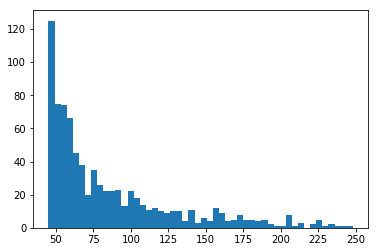

In [953]:
visual_estimate(final_4_with_huge[1])

Total num clusters is 1381
Hugest clusters have [18620 10525  8365  6995  3517  3315  2977  2693]
More than 250 galaxies have 146 clusters
Less than 50 galaxies have 197 clusters


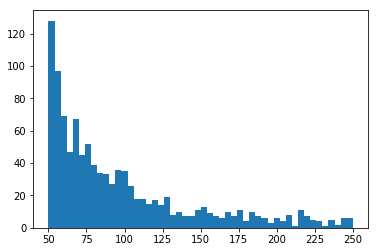

In [899]:
final_3_with_huge = final_res(xyz_subareas_5, result_3, 45, False)

#sil, cal_har, dav_bol = estimate_res(final_3_with_huge[0], final_3_with_huge[1])
#print(sil, cal_har, dav_bol)
visual_estimate(final_3_with_huge[1]);




subarea_BB 0 !!!
expected clusters 39
eps = 0.00087  num_neighbors = 36.0
time: 0.32581281661987305
122.755281818 9.0625 0 

num clusters = 44 num without dropping = 56
131.817781818
------------------------------------------

eps = 0.00141  num_neighbors = 11.0
time: 0.6016542911529541
204322.6464 646.0 0 

num clusters = 1 num without dropping = 2
204968.6464
------------------------------------------

eps = 0.00209  num_neighbors = 16.0
time: 0.6886012554168701
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00289  num_neighbors = 37.0
time: 1.2013144493103027
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00278  num_neighbors = 10.0
time: 1.0993683338165283
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00183  num_neighbors = 24.0
time: 0

eps = 0.00071  num_neighbors = 24.0
time: 0.27785539627075195
103.116486957 18.8125 0 

num clusters = 46 num without dropping = 88
121.928986957
------------------------------------------

eps = 0.00108  num_neighbors = 21.0
time: 0.38180088996887207
5457.99092 261.0 0 

num clusters = 15 num without dropping = 27
5718.99092
------------------------------------------

eps = 0.00092  num_neighbors = 16.0
time: 0.3408203125
2150.04134545 132.8125 0 

num clusters = 22 num without dropping = 47
2282.85384545
------------------------------------------

eps = 0.00139  num_neighbors = 32.0
time: 0.47574591636657715
14634.3955143 460.0 0 

num clusters = 7 num without dropping = 10
15094.3955143
------------------------------------------

eps = 0.00168  num_neighbors = 17.0
time: 0.5536961555480957
204477.6866 646.0 0 

num clusters = 1 num without dropping = 2
205123.6866
------------------------------------------

eps = 0.00095  num_neighbors = 34.0
time: 0.33380556106567383
172.554531915 

eps = 0.00090  num_neighbors = 39.0
time: 0.37078356742858887
124.176163636 9.0625 0 

num clusters = 44 num without dropping = 50
133.238663636
------------------------------------------

eps = 0.00115  num_neighbors = 38.0
time: 0.4277522563934326
714.508630303 18.0 0 

num clusters = 33 num without dropping = 39
732.508630303
------------------------------------------

eps = 0.00115  num_neighbors = 27.0
time: 0.42975354194641113
3439.15352 165.0625 0 

num clusters = 20 num without dropping = 29
3604.21602
------------------------------------------

eps = 0.00063  num_neighbors = 35.0
time: 0.2668459415435791
135.275705882 220.0 0 

num clusters = 17 num without dropping = 23
355.275705882
------------------------------------------

eps = 0.00086  num_neighbors = 36.0
time: 0.330808162689209
121.794981395 5.5 0 

num clusters = 43 num without dropping = 49
127.294981395
------------------------------------------

eps = 0.00085  num_neighbors = 39.0
time: 0.33180665969848633
130.567

eps = 0.00087  num_neighbors = 20.0
time: 0.3228142261505127
330.882095455 9.0625 0 

num clusters = 44 num without dropping = 81
339.944595455
------------------------------------------

eps = 0.00076  num_neighbors = 3.0
time: 0.3128187656402588
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00037  num_neighbors = 7.0
time: 0.20787882804870605
84.27932 38.8125 0 

num clusters = 30 num without dropping = 366
123.09182
------------------------------------------

eps = 0.00070  num_neighbors = 17.0
time: 0.28583621978759766
113.167932075 80.5 0 

num clusters = 53 num without dropping = 117
193.667932075
------------------------------------------

eps = 0.00035  num_neighbors = 5.0
time: 0.20487689971923828
78.9851290323 31.0 0 

num clusters = 31 num without dropping = 633
109.985129032
------------------------------------------

eps = 0.00045  num_neighbors = 12.0
time: 0.21587920188903809
96.33516 91.0

eps = 0.00035  num_neighbors = 36.0
time: 0.18789196014404297
11.8112666667 580.5 0 

num clusters = 3 num without dropping = 4
592.311266667
------------------------------------------

eps = 0.00033  num_neighbors = 5.0
time: 0.2068789005279541
81.2010285714 57.0625 0 

num clusters = 28 num without dropping = 643
138.263528571
------------------------------------------

eps = 0.00061  num_neighbors = 20.0
time: 0.26184988021850586
77.6160095238 2.8125 0 

num clusters = 42 num without dropping = 98
80.4285095238
------------------------------------------

eps = 0.00052  num_neighbors = 14.0
time: 0.23586559295654297
67.873572093 5.5 0 

num clusters = 43 num without dropping = 154
73.373572093
------------------------------------------

eps = 0.00032  num_neighbors = 32.0
time: 0.18721485137939453
11.6416 612.8125 0 

num clusters = 2 num without dropping = 5
624.4541
------------------------------------------

eps = 0.00063  num_neighbors = 12.0
time: 0.2708446979522705
97.027865517

eps = 0.00253  num_neighbors = 16.0
time: 0.42777323722839355
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00002  num_neighbors = 8.0
time: 0.07597184181213379
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00064  num_neighbors = 28.0
time: 0.1359233856201172
43.7852 31.0 0 

num clusters = 14 num without dropping = 20
74.7852
------------------------------------------

eps = 0.00223  num_neighbors = 25.0
time: 0.5077083110809326
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00286  num_neighbors = 20.0
time: 0.472747802734375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00142  num_neighbors = 36.0
time: 0.24487853050231934
18026.8732 165.0625 0 

num clusters

eps = 0.00294  num_neighbors = 3.0
time: 0.4917335510253906
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00120  num_neighbors = 13.0
time: 0.2168717384338379
64381.1434 200.8125 0 

num clusters = 1 num without dropping = 2
64581.9559
------------------------------------------

eps = 0.00106  num_neighbors = 34.0
time: 0.19588637351989746
825.1518 12.8125 0 

num clusters = 17 num without dropping = 21
837.9643
------------------------------------------

eps = 0.00065  num_neighbors = 25.0
time: 0.13593626022338867
48.2036625 18.0 0 

num clusters = 16 num without dropping = 26
66.2036625
------------------------------------------

eps = 0.00050  num_neighbors = 37.0
time: 0.12394332885742188
4.61736 132.8125 0 

num clusters = 5 num without dropping = 7
137.42986
------------------------------------------

eps = 0.00100  num_neighbors = 36.0
time: 0.17791271209716797
304.460147826 0.0625 0 

num cluste

eps = 0.00057  num_neighbors = 16.0
time: 0.13193750381469727
48.5448941176 12.8125 0 

num clusters = 17 num without dropping = 67
61.3573941176
------------------------------------------

eps = 0.00064  num_neighbors = 17.0
time: 0.13892459869384766
58.541625 1.0 0 

num clusters = 24 num without dropping = 61
59.541625
------------------------------------------

eps = 0.00055  num_neighbors = 13.0
time: 0.13093185424804688
35.0777615385 5.5 0 

num clusters = 26 num without dropping = 92
40.5777615385
------------------------------------------

eps = 0.00058  num_neighbors = 13.0
time: 0.13292431831359863
40.3654275862 18.8125 0 

num clusters = 29 num without dropping = 85
59.1779275862
------------------------------------------

eps = 0.00072  num_neighbors = 18.0
time: 0.15091562271118164
100.520358621 18.8125 0 

num clusters = 29 num without dropping = 50
119.332858621
------------------------------------------

eps = 0.00081  num_neighbors = 15.0
time: 0.1678922176361084
986.1

eps = 0.00044  num_neighbors = 7.0
time: 0.1269223690032959
43.7014 5.0625 0 

num clusters = 19 num without dropping = 210
48.7639
------------------------------------------

eps = 0.00037  num_neighbors = 32.0
time: 0.10195708274841309
6.2416 200.8125 0 

num clusters = 1 num without dropping = 1
207.0541
------------------------------------------

eps = 0.00032  num_neighbors = 11.0
time: 0.1099395751953125
5.332 104.0625 0 

num clusters = 7 num without dropping = 49
109.3945
------------------------------------------

eps = 0.00047  num_neighbors = 12.0
time: 0.12194395065307617
43.0866 31.0 0 

num clusters = 14 num without dropping = 106
74.0866
------------------------------------------

eps = 0.00039  num_neighbors = 5.0
time: 0.11591506004333496
35.5596222222 8.5 0 

num clusters = 18 num without dropping = 340
44.0596222222
------------------------------------------

eps = 0.00048  num_neighbors = 16.0
time: 0.11594700813293457
26.54425 47.5 0 

num clusters = 12 num without

eps = 0.00045  num_neighbors = 31.0
time: 0.12392950057983398
4.6878 165.0625 0 

num clusters = 3 num without dropping = 7
169.7503
------------------------------------------

eps = 0.00037  num_neighbors = 23.0
time: 0.10194206237792969
3.9433 182.5 0 

num clusters = 2 num without dropping = 7
186.4433
------------------------------------------

eps = 0.00058  num_neighbors = 14.0
time: 0.14092016220092773
40.8500416667 1.0 0 

num clusters = 24 num without dropping = 79
41.8500416667
------------------------------------------

eps = 0.00066  num_neighbors = 18.0
time: 0.2588515281677246
63.060656 2.8125 0 

num clusters = 25 num without dropping = 59
65.873156
------------------------------------------

eps = 0.00064  num_neighbors = 17.0
time: 0.14191794395446777
54.056096 2.8125 0 

num clusters = 25 num without dropping = 63
56.868596
------------------------------------------

eps = 0.00058  num_neighbors = 14.0
time: 0.13292551040649414
40.8500416667 1.0 0 

num clusters = 24 

eps = 0.00235  num_neighbors = 14.0
time: 0.36180901527404785
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00158  num_neighbors = 40.0
time: 0.2368638515472412
40301.3296 118.0 0 

num clusters = 1 num without dropping = 2
40419.3296
------------------------------------------

eps = 0.00291  num_neighbors = 28.0
time: 0.41576147079467773
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00136  num_neighbors = 10.0
time: 0.22786855697631836
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00003  num_neighbors = 12.0
time: 0.05696845054626465
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00254  num_neighbors = 36.0
time: 0.36978936195373535
5000000.0 5000000.0 0 

num

eps = 0.00076  num_neighbors = 8.0
time: 0.14292693138122559
19500.0593 104.0625 0 

num clusters = 2 num without dropping = 4
19604.1218
------------------------------------------

eps = 0.00080  num_neighbors = 12.0
time: 0.1349351406097412
11619.019 91.0 0 

num clusters = 3 num without dropping = 11
11710.019
------------------------------------------

eps = 0.00042  num_neighbors = 38.0
time: 0.09296298027038574
5.00072 67.5 0 

num clusters = 5 num without dropping = 5
72.50072
------------------------------------------

eps = 0.00039  num_neighbors = 24.0
time: 0.08494901657104492
24.36095 78.8125 0 

num clusters = 4 num without dropping = 12
103.17345
------------------------------------------

eps = 0.00019  num_neighbors = 7.0
time: 0.06995892524719238
4.5973 104.0625 0 

num clusters = 2 num without dropping = 57
108.6598
------------------------------------------

eps = 0.00018  num_neighbors = 27.0
time: 0.07297110557556152
5000000.0 5000000.0 0 

num clusters = 0 num wit

eps = 0.00043  num_neighbors = 23.0
time: 0.0959477424621582
22.7047333333 31.0 0 

num clusters = 9 num without dropping = 17
53.7047333333
------------------------------------------

eps = 0.00044  num_neighbors = 19.0
time: 0.09394645690917969
21.8191166667 12.8125 0 

num clusters = 12 num without dropping = 20
34.6316166667
------------------------------------------

eps = 0.00036  num_neighbors = 28.0
time: 0.08394551277160645
3.93633333333 91.0 0 

num clusters = 3 num without dropping = 6
94.9363333333
------------------------------------------

eps = 0.00040  num_neighbors = 18.0
time: 0.09093427658081055
22.22574 24.0625 0 

num clusters = 10 num without dropping = 24
46.28824
------------------------------------------

eps = 0.00048  num_neighbors = 5.0
time: 0.10793733596801758
81.1344 18.8125 0 

num clusters = 24 num without dropping = 149
99.9469
------------------------------------------

eps = 0.00058  num_neighbors = 7.0
time: 0.11393404006958008
284.860213333 2.5 0 


eps = 0.00035  num_neighbors = 14.0
time: 0.10793662071228027
21.279825 38.8125 0 

num clusters = 8 num without dropping = 31
60.092325
------------------------------------------

eps = 0.00028  num_neighbors = 8.0
time: 0.10294198989868164
6.94026666667 31.0 0 

num clusters = 9 num without dropping = 84
37.9402666667
------------------------------------------

eps = 0.00024  num_neighbors = 14.0
time: 0.10094165802001953
4.94153333333 91.0 0 

num clusters = 3 num without dropping = 12
95.9415333333
------------------------------------------

eps = 0.00041  num_neighbors = 5.0
time: 0.13392376899719238
36.6783826087 13.5 0 

num clusters = 23 num without dropping = 210
50.1783826087
------------------------------------------

eps = 0.00019  num_neighbors = 3.0
time: 0.08495020866394043
4.28586666667 57.0625 0 

num clusters = 6 num without dropping = 576
61.3483666667
------------------------------------------

eps = 0.00020  num_neighbors = 28.0
time: 0.10893678665161133
5000000.0 

eps = 0.00023  num_neighbors = 24.0
time: 0.0859527587890625
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00021  num_neighbors = 4.0
time: 0.07895565032958984
4.36897142857 47.5 0 

num clusters = 7 num without dropping = 321
51.8689714286
------------------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 0.21588420867919922
46.9260782609 13.5 0 

num clusters = 23 num without dropping = 173
60.4260782609
------------------------------------------

eps = 0.00033  num_neighbors = 7.0
time: 0.08694887161254883
22.8041230769 8.5 0 

num clusters = 13 num without dropping = 150
31.3041230769
------------------------------------------

eps = 0.00025  num_neighbors = 7.0
time: 0.07695651054382324
6.08 47.5 0 

num clusters = 7 num without dropping = 96
53.58
------------------------------------------

eps = 0.00021  num_neighbors = 8.0
time: 0.07695698738098145
3.215 91.0 0 

num clusters = 

eps = 0.00222  num_neighbors = 40.0
time: 0.10295486450195312
149.68048 -5.68434188608e-14 0 

num clusters = 15 num without dropping = 18
149.68048
------------------------------------------

eps = 0.00273  num_neighbors = 12.0
time: 0.12494349479675293
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00104  num_neighbors = 27.0
time: 0.06296181678771973
2.0706 353.5 0 

num clusters = 1 num without dropping = 9
355.5706
------------------------------------------

eps = 0.00251  num_neighbors = 13.0
time: 0.12592482566833496
28002.96 353.5 0 

num clusters = 1 num without dropping = 2
28356.46
------------------------------------------

eps = 0.00178  num_neighbors = 28.0
time: 0.09894442558288574
110.1841125 1.0 0 

num clusters = 16 num without dropping = 22
111.1841125
------------------------------------------

eps = 0.00085  num_neighbors = 20.0
time: 0.06198406219482422
5.2976 353.5 0 

num clusters 

eps = 0.00056  num_neighbors = 34.0
time: 0.054964542388916016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00245  num_neighbors = 26.0
time: 0.11895036697387695
2289.94464 182.5 0 

num clusters = 5 num without dropping = 9
2472.44464
------------------------------------------

eps = 0.00234  num_neighbors = 31.0
time: 0.1159360408782959
472.663690909 31.0 0 

num clusters = 11 num without dropping = 11
503.663690909
------------------------------------------

eps = 0.00134  num_neighbors = 13.0
time: 0.07995176315307617
68.1762526316 25.0 0 

num clusters = 19 num without dropping = 54
93.1762526316
------------------------------------------

eps = 0.00135  num_neighbors = 23.0
time: 0.07395792007446289
5.37842105263 25.0 0 

num clusters = 19 num without dropping = 33
30.3784210526
------------------------------------------

eps = 0.00239  num_neighbors = 25.0
time: 0.11893439292907715
1188.69186667 

eps = 0.00095  num_neighbors = 14.0
time: 0.06796050071716309
4.53548 47.5 0 

num clusters = 10 num without dropping = 46
52.03548
------------------------------------------

eps = 0.00092  num_neighbors = 11.0
time: 0.06696248054504395
4.47592307692 8.5 0 

num clusters = 13 num without dropping = 80
12.9759230769
------------------------------------------

eps = 0.00076  num_neighbors = 5.0
time: 0.06497859954833984
6.16452 -5.68434188608e-14 0 

num clusters = 15 num without dropping = 271
6.16452
------------------------------------------

eps = 0.00095  num_neighbors = 5.0
time: 0.07497525215148926
43.1739222222 13.5 0 

num clusters = 18 num without dropping = 194
56.6739222222
------------------------------------------

eps = 0.00103  num_neighbors = 16.0
time: 0.0659627914428711
4.95035384615 8.5 0 

num clusters = 13 num without dropping = 45
13.4503538462
------------------------------------------

eps = 0.00094  num_neighbors = 13.0
time: 0.06396150588989258
4.79538333333 1

eps = 0.00137  num_neighbors = 24.0
time: 0.07995271682739258
3.57384444444 13.5 0 

num clusters = 18 num without dropping = 30
17.0738444444
------------------------------------------

eps = 0.00075  num_neighbors = 4.0
time: 0.06595492362976074
7.4114 1.0 0 

num clusters = 16 num without dropping = 354
8.4114
------------------------------------------

eps = 0.00115  num_neighbors = 14.0
time: 0.0739588737487793
11.7003625 1.0 0 

num clusters = 16 num without dropping = 63
12.7003625
------------------------------------------

eps = 0.00115  num_neighbors = 15.0
time: 0.07195687294006348
4.81044705882 5.5 0 

num clusters = 17 num without dropping = 54
10.3104470588
------------------------------------------

eps = 0.00104  num_neighbors = 26.0
time: 0.06496691703796387
5.64093333333 261.0 0 

num clusters = 3 num without dropping = 11
266.640933333
------------------------------------------

eps = 0.00094  num_neighbors = 15.0
time: 0.06397795677185059
4.62664444444 67.5 0 

num 

eps = 0.00078  num_neighbors = 6.0
time: 0.06996297836303711
4.51802857143 2.5 0 

num clusters = 14 num without dropping = 210
7.01802857143
------------------------------------------

eps = 0.00124  num_neighbors = 19.0
time: 0.07495570182800293
5.38846 40.0 0 

num clusters = 20 num without dropping = 43
45.38846
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 0.07295775413513184
65.0609777778 13.5 0 

num clusters = 18 num without dropping = 166
78.5609777778
------------------------------------------

eps = 0.00100  num_neighbors = 20.0
time: 0.07097530364990234
5.851925 91.0 0 

num clusters = 8 num without dropping = 15
96.851925
------------------------------------------

eps = 0.00089  num_neighbors = 13.0
time: 0.06396365165710449
4.94762222222 67.5 0 

num clusters = 9 num without dropping = 48
72.4476222222
------------------------------------------

eps = 0.00102  num_neighbors = 12.0
time: 0.06695985794067383
3.80349333333 -5.684341886

eps = 0.00288  num_neighbors = 27.0
time: 0.06098461151123047
6748.2064 67.5 0 

num clusters = 1 num without dropping = 2
6815.7064
------------------------------------------

eps = 0.00089  num_neighbors = 31.0
time: 0.03899502754211426
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00046  num_neighbors = 9.0
time: 0.021982669830322266
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 9
10000000.0
------------------------------------------

eps = 0.00238  num_neighbors = 21.0
time: 0.052971839904785156
6647.9714 67.5 0 

num clusters = 1 num without dropping = 2
6715.4714
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.028981447219848633
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00132  num_neighbors = 6.0
time: 0.0369877815246582
6394.7874 67.5 0 

num clusters = 1

eps = 0.00165  num_neighbors = 38.0
time: 0.03699612617492676
5.82105 1.0 0 

num clusters = 8 num without dropping = 8
6.82105
------------------------------------------

eps = 0.00219  num_neighbors = 33.0
time: 0.053972721099853516
260.0166 8.5 0 

num clusters = 5 num without dropping = 6
268.5166
------------------------------------------

eps = 0.00036  num_neighbors = 37.0
time: 0.022005558013916016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00180  num_neighbors = 31.0
time: 0.04497337341308594
38.3369666667 40.0 0 

num clusters = 12 num without dropping = 14
78.3369666667
------------------------------------------

eps = 0.00047  num_neighbors = 40.0
time: 0.026001930236816406
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00213  num_neighbors = 34.0
time: 0.046990156173706055
66.1961818182 25.0 0 

num clusters

eps = 0.00198  num_neighbors = 22.0
time: 0.04797053337097168
2253.0352 47.5 0 

num clusters = 2 num without dropping = 4
2300.5352
------------------------------------------

eps = 0.00193  num_neighbors = 39.0
time: 0.043993473052978516
15.0413692308 58.5 0 

num clusters = 13 num without dropping = 13
73.5413692308
------------------------------------------

eps = 0.00153  num_neighbors = 14.0
time: 0.039995431900024414
124.075285714 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 13
124.075285714
------------------------------------------

eps = 0.00111  num_neighbors = 16.0
time: 0.03199577331542969
3.330525 1.0 0 

num clusters = 8 num without dropping = 32
4.330525
------------------------------------------

eps = 0.00112  num_neighbors = 28.0
time: 0.031000614166259766
3.7414 47.5 0 

num clusters = 2 num without dropping = 7
51.2414
------------------------------------------

eps = 0.00131  num_neighbors = 33.0
time: 0.03497791290283203
2.88908 8.5 0 

num clus

time: 0.03997611999511719
13.5834833333 40.0 0 

num clusters = 12 num without dropping = 16
53.5834833333
------------------------------------------

eps = 0.00169  num_neighbors = 37.0
time: 0.045990705490112305
7.19766666667 5.5 0 

num clusters = 9 num without dropping = 14
12.6976666667
------------------------------------------

eps = 0.00146  num_neighbors = 34.0
time: 0.03697824478149414
3.7357 1.0 0 

num clusters = 8 num without dropping = 9
4.7357
------------------------------------------

eps = 0.00129  num_neighbors = 28.0
time: 0.03297901153564453
3.50845714286 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 10
3.50845714286
------------------------------------------

eps = 0.00177  num_neighbors = 36.0
time: 0.04199647903442383
12.8442923077 58.5 0 

num clusters = 13 num without dropping = 15
71.3442923077
------------------------------------------

eps = 0.00120  num_neighbors = 19.0
time: 0.03298163414001465
3.76044444444 5.5 0 

num clusters = 9 num w

eps = 0.00141  num_neighbors = 33.0
time: 0.03498101234436035
3.26025714286 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 9
3.26025714286
------------------------------------------

eps = 0.00127  num_neighbors = 27.0
time: 0.037996768951416016
3.7656 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 10
3.7656
------------------------------------------

eps = 0.00142  num_neighbors = 34.0
time: 0.03399968147277832
2.74953333333 2.5 0 

num clusters = 6 num without dropping = 9
5.24953333333
------------------------------------------

eps = 0.00154  num_neighbors = 39.0
time: 0.03697919845581055
3.6528 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 9
3.6528
------------------------------------------

eps = 0.00134  num_neighbors = 30.0
time: 0.033998727798461914
3.69 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 10
3.69
------------------------------------------

eps = 0.00144  num_neighbors = 27.0
time: 0.03399395942687988


eps = 0.00073  num_neighbors = 11.0
time: 0.035980939865112305
22.5404727273 25.0 0 

num clusters = 11 num without dropping = 28
47.5404727273
------------------------------------------

eps = 0.00281  num_neighbors = 18.0
time: 0.09895849227905273
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00036  num_neighbors = 18.0
time: 0.0279695987701416
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00042  num_neighbors = 8.0
time: 0.02798175811767578
5.8433 18.0 0 

num clusters = 4 num without dropping = 55
23.8433
------------------------------------------

eps = 0.00025  num_neighbors = 10.0
time: 0.02398538589477539
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00131  num_neighbors = 37.0
time: 0.04895782470703125
1368.6162 31.0 0 

num cluster

eps = 0.00085  num_neighbors = 17.0
time: 0.04697275161743164
28.3066 13.5 0 

num clusters = 10 num without dropping = 16
41.8066
------------------------------------------

eps = 0.00105  num_neighbors = 34.0
time: 0.06296396255493164
28.1795111111 5.5 0 

num clusters = 9 num without dropping = 11
33.6795111111
------------------------------------------

eps = 0.00085  num_neighbors = 33.0
time: 0.03499865531921387
3.638325 1.0 0 

num clusters = 8 num without dropping = 8
4.638325
------------------------------------------

eps = 0.00090  num_neighbors = 27.0
time: 0.03897738456726074
3.35 25.0 0 

num clusters = 11 num without dropping = 23
28.35
------------------------------------------

eps = 0.00106  num_neighbors = 24.0
time: 0.0419766902923584
519.69225 18.0 0 

num clusters = 4 num without dropping = 6
537.69225
------------------------------------------

eps = 0.00059  num_neighbors = 8.0
time: 0.04297637939453125
4.79709333333 106.0 0 

num clusters = 15 num without dropp

eps = 0.00079  num_neighbors = 38.0
time: 0.06796145439147949
5.09815 18.0 0 

num clusters = 4 num without dropping = 4
23.09815
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.05996370315551758
5.25434545455 25.0 0 

num clusters = 11 num without dropping = 19
30.2543454545
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.042975425720214844
5.25434545455 25.0 0 

num clusters = 11 num without dropping = 19
30.2543454545
------------------------------------------

eps = 0.00101  num_neighbors = 19.0
time: 0.05696845054626465
2117.9113 47.5 0 

num clusters = 2 num without dropping = 5
2165.4113
------------------------------------------

eps = 0.00073  num_neighbors = 28.0
time: 0.04897308349609375
4.594175 1.0 0 

num clusters = 8 num without dropping = 9
5.594175
------------------------------------------

eps = 0.00074  num_neighbors = 22.0
time: 0.03497958183288574
3.25715 1.0 0 

num clusters = 8 num w

eps = 0.00094  num_neighbors = 38.0
time: 0.04397273063659668
3.24025 1.0 0 

num clusters = 8 num without dropping = 8
4.24025
------------------------------------------

eps = 0.00099  num_neighbors = 38.0
time: 0.03599977493286133
3.42693333333 5.5 0 

num clusters = 9 num without dropping = 13
8.92693333333
------------------------------------------

eps = 0.00094  num_neighbors = 37.0
time: 0.035980224609375
3.057775 1.0 0 

num clusters = 8 num without dropping = 10
4.057775
------------------------------------------

eps = 0.00093  num_neighbors = 39.0
time: 0.03499770164489746
2.89085714286 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 8
2.89085714286
------------------------------------------

eps = 0.00093  num_neighbors = 39.0
time: 0.032997846603393555
2.89085714286 -1.42108547152e-14 0 

num clusters = 7 num without dropping = 8
2.89085714286
------------------------------------------

eps = 0.00093  num_neighbors = 39.0
time: 0.03297734260559082
2.8908571

eps = 0.00165  num_neighbors = 23.0
time: 0.051969289779663086
3.68988333333 58.5 0 

num clusters = 12 num without dropping = 20
62.1898833333
------------------------------------------

eps = 0.00160  num_neighbors = 4.0
time: 0.12093043327331543
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00135  num_neighbors = 13.0
time: 0.03997635841369629
4.40931428571 106.0 0 

num clusters = 14 num without dropping = 40
110.409314286
------------------------------------------

eps = 0.00160  num_neighbors = 29.0
time: 0.05096912384033203
2.47466666667 13.5 0 

num clusters = 9 num without dropping = 13
15.9746666667
------------------------------------------

eps = 0.00114  num_neighbors = 11.0
time: 0.03098297119140625
3.69890769231 80.5 0 

num clusters = 13 num without dropping = 44
84.1989076923
------------------------------------------

eps = 0.00117  num_neighbors = 12.0
time: 0.0299832820892334
3.590183

eps = 0.00036  num_neighbors = 18.0
time: 0.021005868911743164
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 28.0
time: 0.02598094940185547
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00220  num_neighbors = 32.0
time: 0.036998748779296875
152.4131 5.5 0 

num clusters = 8 num without dropping = 9
157.9131
------------------------------------------

eps = 0.00211  num_neighbors = 25.0
time: 0.03697538375854492
286.9086 2.5 0 

num clusters = 5 num without dropping = 7
289.4086
------------------------------------------

eps = 0.00183  num_neighbors = 39.0
time: 0.03299522399902344
2.21322222222 13.5 0 

num clusters = 9 num without dropping = 10
15.7132222222
------------------------------------------

eps = 0.00077  num_neighbors = 27.0
time: 0.022971391677856445
5000000.0 5000000.0 0 

num cluster

eps = 0.00181  num_neighbors = 32.0
time: 0.03200101852416992
3.3735 58.5 0 

num clusters = 12 num without dropping = 15
61.8735
------------------------------------------

eps = 0.00202  num_neighbors = 28.0
time: 0.04197883605957031
21.3845666667 58.5 0 

num clusters = 12 num without dropping = 15
79.8845666667
------------------------------------------

eps = 0.00179  num_neighbors = 15.0
time: 0.032998085021972656
435.2571 8.5 0 

num clusters = 4 num without dropping = 9
443.7571
------------------------------------------

eps = 0.00170  num_neighbors = 8.0
time: 0.033998727798461914
4632.5514 47.5 0 

num clusters = 1 num without dropping = 3
4680.0514
------------------------------------------

eps = 0.00155  num_neighbors = 32.0
time: 0.030995845794677734
2.13 5.5 0 

num clusters = 8 num without dropping = 9
7.63
------------------------------------------

eps = 0.00192  num_neighbors = 34.0
time: 0.033983469009399414
3.57685454545 40.0 0 

num clusters = 11 num without drop

eps = 0.00163  num_neighbors = 37.0
time: 0.0339808464050293
2.2923 5.5 0 

num clusters = 8 num without dropping = 9
7.7923
------------------------------------------

eps = 0.00161  num_neighbors = 38.0
time: 0.038996219635009766
1.841 1.0 0 

num clusters = 7 num without dropping = 7
2.841
------------------------------------------

eps = 0.00162  num_neighbors = 33.0
time: 0.032982587814331055
2.49906666667 13.5 0 

num clusters = 9 num without dropping = 10
15.9990666667
------------------------------------------

eps = 0.00139  num_neighbors = 30.0
time: 0.02801060676574707
2.98011428571 1.0 0 

num clusters = 7 num without dropping = 8
3.98011428571
------------------------------------------

eps = 0.00187  num_neighbors = 17.0
time: 0.0359807014465332
490.7545 8.5 0 

num clusters = 4 num without dropping = 8
499.2545
------------------------------------------

eps = 0.00172  num_neighbors = 25.0
time: 0.03299880027770996
4.46967692308 80.5 0 

num clusters = 13 num without dro

eps = 0.00245  num_neighbors = 13.0
time: 0.03997683525085449
3772.9936 47.5 0 

num clusters = 1 num without dropping = 2
3820.4936
------------------------------------------

eps = 0.00084  num_neighbors = 10.0
time: 0.02698493003845215
0.6886 31.0 0 

num clusters = 2 num without dropping = 26
31.6886
------------------------------------------

eps = 0.00164  num_neighbors = 20.0
time: 0.03198361396789551
16.992825 5.5 0 

num clusters = 8 num without dropping = 18
22.492825
------------------------------------------

eps = 0.00127  num_neighbors = 37.0
time: 0.023987293243408203
1.9296 31.0 0 

num clusters = 2 num without dropping = 2
32.9296
------------------------------------------

eps = 0.00037  num_neighbors = 11.0
time: 0.019007444381713867
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00016  num_neighbors = 34.0
time: 0.02098846435546875
5000000.0 5000000.0 0 

num clusters = 0 num without d

eps = 0.00047  num_neighbors = 32.0
time: 0.018008708953857422
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00005  num_neighbors = 20.0
time: 0.022986888885498047
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 36.0
time: 0.023985624313354492
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00175  num_neighbors = 14.0
time: 0.029974937438964844
130.692933333 1.42108547152e-14 0 

num clusters = 6 num without dropping = 9
130.692933333
------------------------------------------

eps = 0.00156  num_neighbors = 13.0
time: 0.02898383140563965
41.8251777778 13.5 0 

num clusters = 9 num without dropping = 20
55.3251777778
------------------------------------------

eps = 0.00217  num_neighbors = 13.0
time: 0.03797769546508789
3

eps = 0.00130  num_neighbors = 21.0
time: 0.02698373794555664
4.2864 2.5 0 

num clusters = 5 num without dropping = 12
6.7864
------------------------------------------

eps = 0.00060  num_neighbors = 17.0
time: 0.02596759796142578
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00104  num_neighbors = 23.0
time: 0.027004241943359375
1.9974 31.0 0 

num clusters = 2 num without dropping = 4
32.9974
------------------------------------------

eps = 0.00119  num_neighbors = 13.0
time: 0.027004718780517578
5.18694285714 1.0 0 

num clusters = 7 num without dropping = 29
6.18694285714
------------------------------------------

eps = 0.00068  num_neighbors = 15.0
time: 0.020992279052734375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00137  num_neighbors = 24.0
time: 0.026999235153198242
4.8902 2.5 0 

num clusters = 5 num with

eps = 0.00116  num_neighbors = 22.0
time: 0.029982805252075195
3.2164 18.0 0 

num clusters = 3 num without dropping = 8
21.2164
------------------------------------------

eps = 0.00119  num_neighbors = 12.0
time: 0.029982328414916992
9.1392 1.42108547152e-14 0 

num clusters = 6 num without dropping = 29
9.1392
------------------------------------------

eps = 0.00144  num_neighbors = 20.0
time: 0.03298163414001465
5.993275 5.5 0 

num clusters = 8 num without dropping = 13
11.493275
------------------------------------------

eps = 0.00120  num_neighbors = 17.0
time: 0.03298234939575195
4.95193333333 1.42108547152e-14 0 

num clusters = 6 num without dropping = 18
4.95193333333
------------------------------------------

eps = 0.00106  num_neighbors = 10.0
time: 0.03497886657714844
5.2273 1.42108547152e-14 0 

num clusters = 6 num without dropping = 44
5.2273
------------------------------------------

eps = 0.00168  num_neighbors = 36.0
time: 0.032981157302856445
5.90328 2.5 0 

nu

eps = 0.00103  num_neighbors = 13.0
time: 0.025005102157592773
4.3955 8.5 0 

num clusters = 4 num without dropping = 25
12.8955
------------------------------------------

eps = 0.00079  num_neighbors = 9.0
time: 0.025984764099121094
0.9501 31.0 0 

num clusters = 2 num without dropping = 28
31.9501
------------------------------------------

eps = 0.00156  num_neighbors = 18.0
time: 0.029996395111083984
15.663 5.5 0 

num clusters = 8 num without dropping = 20
21.163
------------------------------------------

eps = 0.00127  num_neighbors = 21.0
time: 0.025005102157592773
4.97263333333 1.42108547152e-14 0 

num clusters = 6 num without dropping = 13
4.97263333333
------------------------------------------

eps = 0.00118  num_neighbors = 18.0
time: 0.025986433029174805
4.772 2.5 0 

num clusters = 5 num without dropping = 16
7.272
------------------------------------------

eps = 0.00096  num_neighbors = 8.0
time: 0.026005268096923828
5.60997142857 1.0 0 

num clusters = 7 num without

eps = 0.00275  num_neighbors = 10.0
time: 0.06498289108276367
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00207  num_neighbors = 16.0
time: 0.047971487045288086
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00173  num_neighbors = 26.0
time: 0.04199552536010742
3120.8226 31.0 0 

num clusters = 1 num without dropping = 2
3151.8226
------------------------------------------

eps = 0.00145  num_neighbors = 35.0
time: 0.034981727600097656
485.456533333 8.5 0 

num clusters = 3 num without dropping = 5
493.956533333
------------------------------------------

eps = 0.00098  num_neighbors = 36.0
time: 0.026986122131347656
4.634175 13.5 0 

num clusters = 8 num without dropping = 9
18.134175
------------------------------------------

eps = 0.00168  num_neighbors = 32.0
time: 0.043973445892333984
3066.3266 31.0 0 

num clusters

eps = 0.00082  num_neighbors = 33.0
time: 0.026985645294189453
4.50935 2.5 0 

num clusters = 4 num without dropping = 6
7.00935
------------------------------------------

eps = 0.00057  num_neighbors = 36.0
time: 0.030982017517089844
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00118  num_neighbors = 28.0
time: 0.04997062683105469
27.2447714286 5.5 0 

num clusters = 7 num without dropping = 10
32.7447714286
------------------------------------------

eps = 0.00095  num_neighbors = 35.0
time: 0.03498101234436035
4.70254285714 5.5 0 

num clusters = 7 num without dropping = 8
10.2025428571
------------------------------------------

eps = 0.00061  num_neighbors = 37.0
time: 0.02200603485107422
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 34.0
time: 0.02598285675048828
4.338225 13.5 0 

num cluster

eps = 0.00096  num_neighbors = 10.0
time: 0.04297614097595215
1036.2497 18.0 0 

num clusters = 2 num without dropping = 2
1054.2497
------------------------------------------

eps = 0.00090  num_neighbors = 38.0
time: 0.03897595405578613
4.18908 7.1054273576e-15 0 

num clusters = 5 num without dropping = 6
4.18908
------------------------------------------

eps = 0.00087  num_neighbors = 35.0
time: 0.0339813232421875
4.29388 7.1054273576e-15 0 

num clusters = 5 num without dropping = 7
4.29388
------------------------------------------

eps = 0.00091  num_neighbors = 38.0
time: 0.02798318862915039
4.13736 7.1054273576e-15 0 

num clusters = 5 num without dropping = 6
4.13736
------------------------------------------

eps = 0.00092  num_neighbors = 4.0
time: 0.029985904693603516
3148.2506 31.0 0 

num clusters = 1 num without dropping = 2
3179.2506
------------------------------------------

eps = 0.00082  num_neighbors = 30.0
time: 0.0259859561920166
4.85583333333 1.0 0 

num clust

eps = 0.00094  num_neighbors = 33.0
time: 0.035974740982055664
4.898425 13.5 0 

num clusters = 8 num without dropping = 10
18.398425
------------------------------------------

eps = 0.00083  num_neighbors = 36.0
time: 0.0319666862487793
4.00493333333 8.5 0 

num clusters = 3 num without dropping = 5
12.5049333333
------------------------------------------

eps = 0.00093  num_neighbors = 33.0
time: 0.02998185157775879
4.887625 13.5 0 

num clusters = 8 num without dropping = 10
18.387625
------------------------------------------

eps = 0.00086  num_neighbors = 39.0
time: 0.028983592987060547
3.84653333333 8.5 0 

num clusters = 3 num without dropping = 3
12.3465333333
------------------------------------------

eps = 0.00083  num_neighbors = 36.0
time: 0.029983997344970703
3.93266666667 8.5 0 

num clusters = 3 num without dropping = 5
12.4326666667
------------------------------------------

eps = 0.00094  num_neighbors = 39.0
time: 0.0319821834564209
3.77212 7.1054273576e-15 0 

nu

eps = 0.00095  num_neighbors = 38.0
time: 0.031982421875
3.79511428571 5.5 0 

num clusters = 7 num without dropping = 8
9.29511428571
------------------------------------------

eps = 0.00092  num_neighbors = 37.0
time: 0.0339808464050293
3.7098 7.1054273576e-15 0 

num clusters = 5 num without dropping = 7
3.7098
------------------------------------------

eps = 0.00091  num_neighbors = 34.0
time: 0.07095789909362793
3.47626666667 1.0 0 

num clusters = 6 num without dropping = 8
4.47626666667
------------------------------------------

eps = 0.00095  num_neighbors = 37.0
time: 0.056967735290527344
3.31908571429 5.5 0 

num clusters = 7 num without dropping = 8
8.81908571429
------------------------------------------

eps = 0.00095  num_neighbors = 37.0
time: 0.06096458435058594
3.7806 5.5 0 

num clusters = 7 num without dropping = 8
9.2806
------------------------------------------

eps = 0.00083  num_neighbors = 37.0
time: 0.05896639823913574
4.30593333333 8.5 0 

num clusters = 3

eps = 0.00277  num_neighbors = 9.0
time: 0.03897809982299805
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00053  num_neighbors = 6.0
time: 0.01598811149597168
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 33
10000000.0
------------------------------------------

eps = 0.00035  num_neighbors = 11.0
time: 0.014993906021118164
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00172  num_neighbors = 12.0
time: 0.02898430824279785
791.007 8.5 0 

num clusters = 2 num without dropping = 4
799.507
------------------------------------------

eps = 0.00010  num_neighbors = 30.0
time: 0.011992454528808594
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 26.0
time: 0.017991065979003906
5000000.0 5000000.0 0 

num clus

eps = 0.00204  num_neighbors = 17.0
time: 0.02596735954284668
429.2204 2.5 0 

num clusters = 3 num without dropping = 3
431.7204
------------------------------------------

eps = 0.00152  num_neighbors = 25.0
time: 0.02298736572265625
5.79908571429 13.5 0 

num clusters = 7 num without dropping = 12
19.2990857143
------------------------------------------

eps = 0.00050  num_neighbors = 19.0
time: 0.013992547988891602
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00232  num_neighbors = 27.0
time: 0.028996944427490234
401.7588 2.5 0 

num clusters = 3 num without dropping = 3
404.2588
------------------------------------------

eps = 0.00098  num_neighbors = 36.0
time: 0.01700901985168457
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00173  num_neighbors = 19.0
time: 0.023006200790405273
117.744366667 5.5 0 

num clusters 

eps = 0.00105  num_neighbors = 19.0
time: 0.0179901123046875
4.4161 8.5 0 

num clusters = 2 num without dropping = 10
12.9161
------------------------------------------

eps = 0.00112  num_neighbors = 21.0
time: 0.016989946365356445
4.0041 8.5 0 

num clusters = 2 num without dropping = 10
12.5041
------------------------------------------

eps = 0.00134  num_neighbors = 21.0
time: 0.018988847732543945
5.2566 5.5 0 

num clusters = 6 num without dropping = 14
10.7566
------------------------------------------

eps = 0.00135  num_neighbors = 29.0
time: 0.024985790252685547
5.1927 0.0 0 

num clusters = 4 num without dropping = 8
5.1927
------------------------------------------

eps = 0.00110  num_neighbors = 15.0
time: 0.02398514747619629
4.7592 13.5 0 

num clusters = 7 num without dropping = 17
18.2592
------------------------------------------

eps = 0.00135  num_neighbors = 13.0
time: 0.02898430824279785
25.967075 25.0 0 

num clusters = 8 num without dropping = 16
50.967075
-----

eps = 0.00122  num_neighbors = 23.0
time: 0.026982784271240234
5.19505 0.0 0 

num clusters = 4 num without dropping = 11
5.19505
------------------------------------------

eps = 0.00097  num_neighbors = 9.0
time: 0.031980037689208984
5.12006666667 5.5 0 

num clusters = 6 num without dropping = 32
10.6200666667
------------------------------------------

eps = 0.00123  num_neighbors = 22.0
time: 0.02398824691772461
4.61472 1.0 0 

num clusters = 5 num without dropping = 9
5.61472
------------------------------------------

eps = 0.00116  num_neighbors = 20.0
time: 0.024003982543945312
3.1916 2.5 0 

num clusters = 3 num without dropping = 11
5.6916
------------------------------------------

eps = 0.00102  num_neighbors = 13.0
time: 0.023988008499145508
4.94408571429 13.5 0 

num clusters = 7 num without dropping = 17
18.4440857143
------------------------------------------

eps = 0.00124  num_neighbors = 29.0
time: 0.019007444381713867
0.9344 18.0 0 

num clusters = 1 num without dr

eps = 0.00019  num_neighbors = 37.0
time: 0.010014057159423828
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00056  num_neighbors = 28.0
time: 0.010013341903686523
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00216  num_neighbors = 3.0
time: 0.019008636474609375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00028  num_neighbors = 14.0
time: 0.009991884231567383
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00038  num_neighbors = 27.0
time: 0.009012699127197266
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 16.0
time: 0.014989852905273438
1.0506 8.5 0 

num

eps = 0.00120  num_neighbors = 32.0
time: 0.014992713928222656
0.385 8.5 0 

num clusters = 1 num without dropping = 1
8.885
------------------------------------------

eps = 0.00097  num_neighbors = 28.0
time: 0.013993501663208008
7.3954 8.5 0 

num clusters = 1 num without dropping = 2
15.8954
------------------------------------------

eps = 0.00127  num_neighbors = 29.0
time: 0.014992475509643555
2.9546 8.5 0 

num clusters = 1 num without dropping = 3
11.4546
------------------------------------------

eps = 0.00086  num_neighbors = 12.0
time: 0.011991262435913086
0.5226 8.5 0 

num clusters = 1 num without dropping = 15
9.0226
------------------------------------------

eps = 0.00076  num_neighbors = 3.0
time: 0.013992071151733398
5.7258 13.5 0 

num clusters = 6 num without dropping = 109
19.2258
------------------------------------------

eps = 0.00147  num_neighbors = 11.0
time: 0.015990018844604492
64.89912 5.5 0 

num clusters = 5 num without dropping = 10
70.39912
---------

eps = 0.00117  num_neighbors = 16.0
time: 0.013991355895996094
5.87704 5.5 0 

num clusters = 5 num without dropping = 15
11.37704
------------------------------------------

eps = 0.00124  num_neighbors = 13.0
time: 0.01899123191833496
10.84684 5.5 0 

num clusters = 5 num without dropping = 18
16.34684
------------------------------------------

eps = 0.00124  num_neighbors = 21.0
time: 0.017989397048950195
6.70755 1.0 0 

num clusters = 4 num without dropping = 11
7.70755
------------------------------------------

eps = 0.00052  num_neighbors = 13.0
time: 0.012993097305297852
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 17.0
time: 0.014991998672485352
1.1554 8.5 0 

num clusters = 1 num without dropping = 6
9.6554
------------------------------------------

eps = 0.00140  num_neighbors = 16.0
time: 0.016990184783935547
15.6255 1.0 0 

num clusters = 4 num without dropping = 13

eps = 0.00097  num_neighbors = 11.0
time: 0.01598978042602539
6.0476 1.0 0 

num clusters = 4 num without dropping = 26
7.0476
------------------------------------------

eps = 0.00085  num_neighbors = 15.0
time: 0.0199892520904541
-0.0224 8.5 0 

num clusters = 1 num without dropping = 6
8.4776
------------------------------------------

eps = 0.00071  num_neighbors = 28.0
time: 0.012990474700927734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00088  num_neighbors = 7.0
time: 0.012990713119506836
4.91436666667 13.5 0 

num clusters = 6 num without dropping = 40
18.4143666667
------------------------------------------

eps = 0.00104  num_neighbors = 16.0
time: 0.01201486587524414
6.09866666667 0.0 0 

num clusters = 3 num without dropping = 11
6.09866666667
------------------------------------------

eps = 0.00115  num_neighbors = 19.0
time: 0.012012481689453125
6.36735 1.0 0 

num clusters = 4 num with

eps = 0.00237  num_neighbors = 12.0
time: 0.019006967544555664
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00153  num_neighbors = 40.0
time: 0.012012720108032227
7.1306 8.5 0 

num clusters = 1 num without dropping = 3
15.6306
------------------------------------------

eps = 0.00132  num_neighbors = 5.0
time: 0.016989946365356445
266.567333333 0.0 0 

num clusters = 3 num without dropping = 6
266.567333333
------------------------------------------

eps = 0.00085  num_neighbors = 8.0
time: 0.011988639831542969
5.2976 8.5 0 

num clusters = 1 num without dropping = 41
13.7976
------------------------------------------

eps = 0.00095  num_neighbors = 26.0
time: 0.016989946365356445
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 9.0
time: 0.015011310577392578
5000000.0 5000000.0 0 

num clusters = 0 n

num clusters = 2 num without dropping = 2
9.3922
------------------------------------------

eps = 0.00170  num_neighbors = 39.0
time: 0.0179903507232666
2.79453333333 0.0 0 

num clusters = 3 num without dropping = 4
2.79453333333
------------------------------------------

eps = 0.00121  num_neighbors = 26.0
time: 0.013999700546264648
7.3954 8.5 0 

num clusters = 1 num without dropping = 2
15.8954
------------------------------------------

eps = 0.00150  num_neighbors = 18.0
time: 0.016993045806884766
6.9894 5.5 0 

num clusters = 5 num without dropping = 14
12.4894
------------------------------------------

eps = 0.00213  num_neighbors = 7.0
time: 0.026003360748291016
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00167  num_neighbors = 39.0
time: 0.01699066162109375
3.906 0.0 0 

num clusters = 3 num without dropping = 3
3.906
------------------------------------------

eps = 0.00220  num_neighbors

eps = 0.00197  num_neighbors = 38.0
time: 0.014990568161010742
4.97484 5.5 0 

num clusters = 5 num without dropping = 5
10.47484
------------------------------------------

eps = 0.00163  num_neighbors = 39.0
time: 0.0139923095703125
-0.0304 8.5 0 

num clusters = 1 num without dropping = 2
8.4696
------------------------------------------

eps = 0.00154  num_neighbors = 35.0
time: 0.011993169784545898
3.9357 2.5 0 

num clusters = 2 num without dropping = 3
6.4357
------------------------------------------

eps = 0.00153  num_neighbors = 38.0
time: 0.01299142837524414
5.6278 2.5 0 

num clusters = 2 num without dropping = 2
8.1278
------------------------------------------

eps = 0.00174  num_neighbors = 39.0
time: 0.01299285888671875
2.68273333333 0.0 0 

num clusters = 3 num without dropping = 4
2.68273333333
------------------------------------------

eps = 0.00158  num_neighbors = 40.0
time: 0.013990402221679688
0.285 8.5 0 

num clusters = 1 num without dropping = 1
8.785
------

eps = 0.00172  num_neighbors = 37.0
time: 0.017991304397583008
3.7627 1.0 0 

num clusters = 4 num without dropping = 4
4.7627
------------------------------------------

eps = 0.00163  num_neighbors = 38.0
time: 0.017004728317260742
-0.0374 8.5 0 

num clusters = 1 num without dropping = 2
8.4626
------------------------------------------

eps = 0.00174  num_neighbors = 38.0
time: 0.015012979507446289
3.6903 1.0 0 

num clusters = 4 num without dropping = 4
4.6903
------------------------------------------

eps = 0.00212  num_neighbors = 35.0
time: 0.018991708755493164
23.78475 1.0 0 

num clusters = 4 num without dropping = 4
24.78475
------------------------------------------

eps = 0.00165  num_neighbors = 24.0
time: 0.018970012664794922
5.69116666667 13.5 0 

num clusters = 6 num without dropping = 7
19.1911666667
------------------------------------------

eps = 0.00165  num_neighbors = 35.0
time: 0.013011693954467773
3.9408 1.0 0 

num clusters = 4 num without dropping = 4
4.940

eps = 0.00176  num_neighbors = 31.0
time: 0.013009071350097656
4.05428 5.5 0 

num clusters = 5 num without dropping = 6
9.55428
------------------------------------------

eps = 0.00172  num_neighbors = 39.0
time: 0.014008760452270508
2.8742 0.0 0 

num clusters = 3 num without dropping = 4
2.8742
------------------------------------------

eps = 0.00178  num_neighbors = 37.0
time: 0.01398324966430664
2.98725 1.0 0 

num clusters = 4 num without dropping = 4
3.98725
------------------------------------------

eps = 0.00181  num_neighbors = 38.0
time: 0.013988971710205078
3.0624 1.0 0 

num clusters = 4 num without dropping = 4
4.0624
------------------------------------------

eps = 0.00176  num_neighbors = 39.0
time: 0.014991521835327148
3.75515 1.0 0 

num clusters = 4 num without dropping = 4
4.75515
------------------------------------------

eps = 0.00180  num_neighbors = 39.0
time: 0.013991355895996094
3.08365 1.0 0 

num clusters = 4 num without dropping = 4
4.08365
-----------

eps = 0.00112  num_neighbors = 24.0
time: 0.018006324768066406
95.7160666667 0.0 0 

num clusters = 3 num without dropping = 4
95.7160666667
------------------------------------------

eps = 0.00130  num_neighbors = 29.0
time: 0.02498602867126465
109.0988 0.0 0 

num clusters = 3 num without dropping = 3
109.0988
------------------------------------------

eps = 0.00054  num_neighbors = 12.0
time: 0.018993377685546875
5.712 5.5 0 

num clusters = 5 num without dropping = 21
11.212
------------------------------------------

eps = 0.00211  num_neighbors = 18.0
time: 0.02698493003845215
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00110  num_neighbors = 30.0
time: 0.028980493545532227
79.7943333333 0.0 0 

num clusters = 3 num without dropping = 3
79.7943333333
------------------------------------------

eps = 0.00059  num_neighbors = 6.0
time: 0.014992237091064453
21.6241 13.5 0 

num clusters = 6 num wi

eps = 0.00113  num_neighbors = 35.0
time: 0.014009475708007812
31.7121 1.0 0 

num clusters = 4 num without dropping = 5
32.7121
------------------------------------------

eps = 0.00072  num_neighbors = 28.0
time: 0.013011693954467773
5.39506666667 0.0 0 

num clusters = 3 num without dropping = 5
5.39506666667
------------------------------------------

eps = 0.00066  num_neighbors = 27.0
time: 0.010003805160522461
5.6426 8.5 0 

num clusters = 1 num without dropping = 2
14.1426
------------------------------------------

eps = 0.00050  num_neighbors = 27.0
time: 0.009013175964355469
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00059  num_neighbors = 36.0
time: 0.010991334915161133
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00050  num_neighbors = 30.0
time: 0.010013580322265625
5000000.0 5000000.0 0 

num clusters = 

eps = 0.00082  num_neighbors = 37.0
time: 0.011993169784545898
5.50513333333 0.0 0 

num clusters = 3 num without dropping = 5
5.50513333333
------------------------------------------

eps = 0.00087  num_neighbors = 39.0
time: 0.013010025024414062
4.2307 1.0 0 

num clusters = 4 num without dropping = 5
5.2307
------------------------------------------

eps = 0.00083  num_neighbors = 38.0
time: 0.011009454727172852
4.87746666667 0.0 0 

num clusters = 3 num without dropping = 5
4.87746666667
------------------------------------------

eps = 0.00082  num_neighbors = 23.0
time: 0.01099395751953125
0.98832 5.5 0 

num clusters = 5 num without dropping = 9
6.48832
------------------------------------------

eps = 0.00094  num_neighbors = 29.0
time: 0.011992931365966797
1.00168 5.5 0 

num clusters = 5 num without dropping = 8
6.50168
------------------------------------------

eps = 0.00078  num_neighbors = 35.0
time: 0.012015104293823242
6.0321 2.5 0 

num clusters = 2 num without droppin

eps = 0.00089  num_neighbors = 15.0
time: 0.01601099967956543
66.67685 1.0 0 

num clusters = 4 num without dropping = 7
67.67685
------------------------------------------

eps = 0.00079  num_neighbors = 33.0
time: 0.011012792587280273
5.1145 1.0 0 

num clusters = 4 num without dropping = 6
6.1145
------------------------------------------

eps = 0.00087  num_neighbors = 38.0
time: 0.01101231575012207
4.49928 5.5 0 

num clusters = 5 num without dropping = 5
9.99928
------------------------------------------

eps = 0.00087  num_neighbors = 38.0
time: 0.01199650764465332
3.70785 1.0 0 

num clusters = 4 num without dropping = 5
4.70785
------------------------------------------

eps = 0.00087  num_neighbors = 37.0
time: 0.016988754272460938
4.0832 5.5 0 

num clusters = 5 num without dropping = 6
9.5832
------------------------------------------

eps = 0.00074  num_neighbors = 38.0
time: 0.013010501861572266
6.8706 8.5 0 

num clusters = 1 num without dropping = 1
15.3706
------------

eps = 0.00020  num_neighbors = 17.0
time: 0.009994745254516602
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00133  num_neighbors = 24.0
time: 0.009993791580200195
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 3
10000000.0
------------------------------------------

eps = 0.00107  num_neighbors = 6.0
time: 0.010977506637573242
3.5472 13.5 0 

num clusters = 5 num without dropping = 40
17.0472
------------------------------------------

eps = 0.00254  num_neighbors = 37.0
time: 0.0139923095703125
4.7118 25.0 0 

num clusters = 6 num without dropping = 6
29.7118
------------------------------------------

eps = 0.00283  num_neighbors = 34.0
time: 0.013992071151733398
5.49352 13.5 0 

num clusters = 5 num without dropping = 6
18.99352
------------------------------------------

eps = 0.00075  num_neighbors = 22.0
time: 0.008994817733764648
5000000.0 5000000.0 0 

num clusters = 0 num witho

eps = 0.00119  num_neighbors = 14.0
time: 0.00899815559387207
6.1786 1.0 0 

num clusters = 3 num without dropping = 11
7.1786
------------------------------------------

eps = 0.00264  num_neighbors = 34.0
time: 0.015009641647338867
5.13008 13.5 0 

num clusters = 5 num without dropping = 5
18.63008
------------------------------------------

eps = 0.00238  num_neighbors = 33.0
time: 0.013972043991088867
5.09286666667 25.0 0 

num clusters = 6 num without dropping = 6
30.0928666667
------------------------------------------

eps = 0.00139  num_neighbors = 7.0
time: 0.010994672775268555
14.57255 5.5 0 

num clusters = 4 num without dropping = 13
20.07255
------------------------------------------

eps = 0.00158  num_neighbors = 7.0
time: 0.013010501861572266
82.1105333333 1.0 0 

num clusters = 3 num without dropping = 8
83.1105333333
------------------------------------------

eps = 0.00189  num_neighbors = 27.0
time: 0.011012792587280273
3.86344 13.5 0 

num clusters = 5 num without 

eps = 0.00043  num_neighbors = 22.0
time: 0.006014585494995117
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00146  num_neighbors = 31.0
time: 0.011012077331542969
7.3954 2.5 0 

num clusters = 1 num without dropping = 1
9.8954
------------------------------------------

eps = 0.00011  num_neighbors = 22.0
time: 0.006991147994995117
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00192  num_neighbors = 8.0
time: 0.011992216110229492
536.5296 2.5 0 

num clusters = 1 num without dropping = 3
539.0296
------------------------------------------

eps = 0.00163  num_neighbors = 34.0
time: 0.010012626647949219
5.185 2.5 0 

num clusters = 1 num without dropping = 2
7.685
------------------------------------------

eps = 0.00093  num_neighbors = 7.0
time: 0.008013725280761719
5.9505 0.0 0 

num clusters = 2 num without dropping = 3

eps = 0.00102  num_neighbors = 9.0
time: 0.009991168975830078
4.90326666667 1.0 0 

num clusters = 3 num without dropping = 24
5.90326666667
------------------------------------------

eps = 0.00142  num_neighbors = 17.0
time: 0.010992050170898438
3.76255 5.5 0 

num clusters = 4 num without dropping = 10
9.26255
------------------------------------------

eps = 0.00037  num_neighbors = 20.0
time: 0.007015705108642578
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00057  num_neighbors = 37.0
time: 0.007012844085693359
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00163  num_neighbors = 16.0
time: 0.010009527206420898
4.5589 25.0 0 

num clusters = 6 num without dropping = 9
29.5589
------------------------------------------

eps = 0.00101  num_neighbors = 11.0
time: 0.008013010025024414
5000000.0 5000000.0 0 

num clusters 

eps = 0.00126  num_neighbors = 17.0
time: 0.009014368057250977
6.492 0.0 0 

num clusters = 2 num without dropping = 9
6.492
------------------------------------------

eps = 0.00105  num_neighbors = 8.0
time: 0.00999760627746582
3.482 1.0 0 

num clusters = 3 num without dropping = 28
4.482
------------------------------------------

eps = 0.00105  num_neighbors = 8.0
time: 0.009011983871459961
3.482 1.0 0 

num clusters = 3 num without dropping = 28
4.482
------------------------------------------

eps = 0.00105  num_neighbors = 8.0
time: 0.00899505615234375
3.482 1.0 0 

num clusters = 3 num without dropping = 28
4.482
------------------------------------------

expected clusters were 2



subarea_BB 14 !!!
expected clusters 2
eps = 0.00054  num_neighbors = 22.0
time: 0.008013010025024414
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00145  num_neighbors = 34.0
time: 0.014009714126586914
479.1424 2.5 

eps = 0.00198  num_neighbors = 17.0
time: 0.01900935173034668
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00021  num_neighbors = 16.0
time: 0.008015155792236328
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00111  num_neighbors = 8.0
time: 0.011991024017333984
544.5026 2.5 0 

num clusters = 1 num without dropping = 2
547.0026
------------------------------------------

eps = 0.00149  num_neighbors = 34.0
time: 0.013991594314575195
484.5194 2.5 0 

num clusters = 1 num without dropping = 1
487.0194
------------------------------------------

eps = 0.00215  num_neighbors = 21.0
time: 0.021004438400268555
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00018  num_neighbors = 18.0
time: 0.006997346878051758
5000000.0 5000000.0 0 

num clusters 

eps = 0.00106  num_neighbors = 40.0
time: 0.010993719100952148
2.1945 0.0 0 

num clusters = 2 num without dropping = 3
2.1945
------------------------------------------

eps = 0.00078  num_neighbors = 32.0
time: 0.012991905212402344
7.3954 2.5 0 

num clusters = 1 num without dropping = 1
9.8954
------------------------------------------

eps = 0.00006  num_neighbors = 32.0
time: 0.005995512008666992
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00149  num_neighbors = 27.0
time: 0.013992071151733398
499.7346 2.5 0 

num clusters = 1 num without dropping = 2
502.2346
------------------------------------------

eps = 0.00062  num_neighbors = 4.0
time: 0.01199197769165039
20.09765 5.5 0 

num clusters = 4 num without dropping = 13
25.59765
------------------------------------------

eps = 0.00078  num_neighbors = 31.0
time: 0.008993864059448242
7.3954 2.5 0 

num clusters = 1 num without dropping = 1
9.895

eps = 0.00106  num_neighbors = 39.0
time: 0.012002229690551758
3.69453333333 1.0 0 

num clusters = 3 num without dropping = 6
4.69453333333
------------------------------------------

eps = 0.00096  num_neighbors = 35.0
time: 0.01101374626159668
3.2856 0.0 0 

num clusters = 2 num without dropping = 3
3.2856
------------------------------------------

eps = 0.00094  num_neighbors = 34.0
time: 0.011013269424438477
3.8822 0.0 0 

num clusters = 2 num without dropping = 2
3.8822
------------------------------------------

eps = 0.00092  num_neighbors = 32.0
time: 0.011009454727172852
3.399 0.0 0 

num clusters = 2 num without dropping = 4
3.399
------------------------------------------

eps = 0.00114  num_neighbors = 28.0
time: 0.012005090713500977
67.021 0.0 0 

num clusters = 2 num without dropping = 3
67.021
------------------------------------------

eps = 0.00118  num_neighbors = 11.0
time: 0.013012170791625977
543.36 2.5 0 

num clusters = 1 num without dropping = 2
545.86
-------

eps = 0.00106  num_neighbors = 38.0
time: 0.010992765426635742
2.055 0.0 0 

num clusters = 2 num without dropping = 6
2.055
------------------------------------------

eps = 0.00113  num_neighbors = 6.0
time: 0.013992786407470703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 22.0
time: 0.010993003845214844
6.03655 5.5 0 

num clusters = 4 num without dropping = 7
11.53655
------------------------------------------

eps = 0.00104  num_neighbors = 40.0
time: 0.010994195938110352
2.7429 0.0 0 

num clusters = 2 num without dropping = 2
2.7429
------------------------------------------

eps = 0.00114  num_neighbors = 9.0
time: 0.011992931365966797
545.6464 2.5 0 

num clusters = 1 num without dropping = 2
548.1464
------------------------------------------

eps = 0.00092  num_neighbors = 39.0
time: 0.010994195938110352
4.2256 2.5 0 

num clusters = 1 num without dropping = 3
6.7256
--

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.394869590151 40197.8755189 0.713910522048
Total num clusters is 1510
Hugest clusters have [2218 1113 1047 1001  936  912  845  840]
More than 250 galaxies have 140 clusters
Less than 50 galaxies have 216 clusters


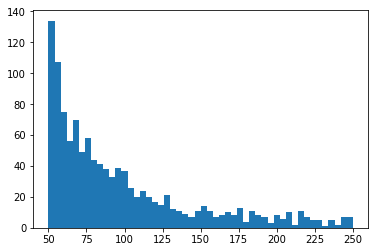

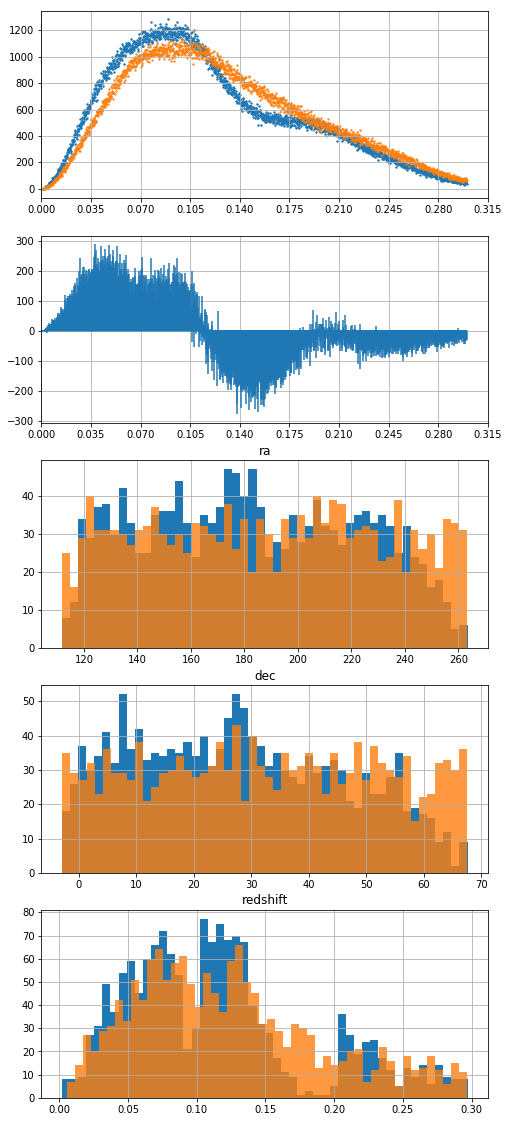

In [901]:
final_3_recounte_huge = final_res(xyz_subareas_5, result_3, 45, True, 15, 700)

result_3_area, result_3_labels = final_3_recounte_huge
result_3_center_clusters = centers_by_labels(result_3_area, result_3_labels)


sil, cal_har, dav_bol = estimate_res(result_3_area, result_3_labels)
print(sil, cal_har, dav_bol)

visual_estimate(result_3_labels);
plot_results(result_3_center_clusters, num_bins=2000, right_edge=0.3, mod_mix=4)


In [886]:
estimate_res(minibatch_arae, minibatch_labeks)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


(0.22613191191646839, 49377.443480533155, 1.1068643873681656)

<IPython.core.display.Javascript object>


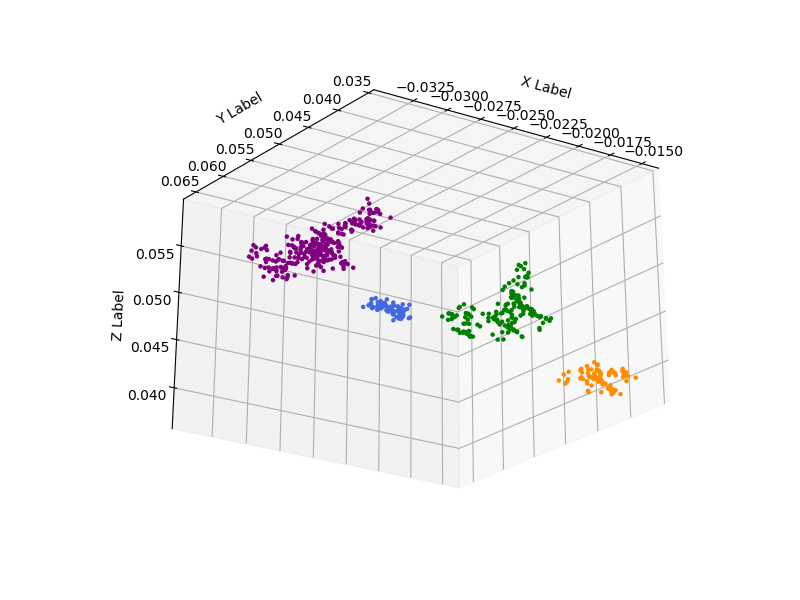

Text(0.5,0,'Z Label')

In [366]:
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*(all_area[labels_no_huge==7]).T, c=colours[0], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==8]).T, c=colours[1], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==11]).T, c=colours[2], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==20]).T, c=colours[3], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [378]:
%matplotlib inline

In [408]:
list_xyz_subareas = list()
subareas_labels = list()
for subarea, res in zip_longest(subareas[1:], result_no_num_clusters):
    eps = res.x[0]
    num_neighbors = round(res.x[1])
    
    xyz_subarea = to_xyz(subarea)
    labels = apply_dbscan(xyz_subarea, eps, num_neighbors)[0]
    
    list_xyz_subareas.append(xyz_subarea)
    subareas_labels.append(labels)

print(list_xyz_subareas)
print(subareas_labels)
    
all_centers = concat_results(list_xyz_subareas, subareas_labels)

    
    

[array([[-0.05335642, -0.00909723,  0.01200446],
       [-0.0379581 , -0.00647189,  0.051932  ],
       [-0.03855985, -0.00657462,  0.05255706],
       ..., 
       [-0.00424495, -0.06283377,  0.08810041],
       [-0.00390255, -0.05840709,  0.07974207],
       [-0.00347735, -0.05471763,  0.07484163]]), array([[-0.06397273,  0.18564973,  0.16120856],
       [-0.03680575,  0.10612574,  0.09266452],
       [-0.06452006,  0.18599404,  0.16134217],
       ..., 
       [-0.12286279, -0.02094328,  0.01641706],
       [-0.13212662, -0.02252354, -0.00700338],
       [-0.15697421, -0.02675984,  0.02007173]]), array([[-0.08270644, -0.01410108,  0.12529289],
       [-0.15370455, -0.02620738,  0.00868712],
       [-0.08911439, -0.01519458,  0.07323634],
       ..., 
       [-0.00492666, -0.0734152 ,  0.10051479],
       [-0.00694039, -0.1040508 ,  0.14418135],
       [-0.00418807, -0.06543937,  0.08977346]])]
[array([-1,  0,  0, ..., -1, -1, -1], dtype=int64), array([    0,     1,     0, ...,    -1

In [91]:
list_c = list()
with open('data/Abell clusters (ra, dec).txt', 'r') as fd:
    for line in fd:
        line = line.split()
        ra =float(line[0])
        dec = float(line[1])
        list_c.append([ra, dec])
        
abell_clusters_ray = np.array(list_c)
left_abell, right_abell = left_right_regions(abell_clusters_ray)


In [192]:
labels_list, num_in_clusters = eval_dif_evol(subareas, result_small_loss)

In [121]:
labels_list, num_in_clusters = eval_dif_evol(subareas, result_no_num_clusters)
xyz_subareas = list()
for subarea in subareas:
    xyz_subareas.append(to_xyz(subarea))

all_area, all_labels = concat_results(xyz_subareas, labels_list)
start_time = time()
sil_coef_2 = silhouette_no_noize(all_area, all_labels)
print(time() - start_time)



3395.203337430954


## Cub structure


In [329]:
bot_edge = 0
top_edge = 12
scale_coef = 0.0087
eps=scale_coef*10e-4
cub_struct = np.zeros(((top_edge-bot_edge)**3, 3))
noize = (np.random.random_sample(size=cub_struct.shape)-0.5) + 1

idx = 0
for i in range(bot_edge, top_edge):
    for j in range(bot_edge, top_edge):
        for k in range(bot_edge, top_edge):
            cub_struct[idx, 0] = i + eps
            cub_struct[idx, 1] = j + eps
            cub_struct[idx, 2] = k + eps
            idx+=1
            
cub_struct = cub_struct * scale_coef * noize

array=to_ra_dec_redshift(cub_struct)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.1) & (array[:,1] < 65.))
cub_struct_cutted = to_xyz(array[mask])

In [330]:
unif_cutted = uniform_distr(cub_struct, False)
array=to_ra_dec_redshift(unif_cutted)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.) & (array[:,1] < 65.))
unif_cutted = to_xyz(array[mask])

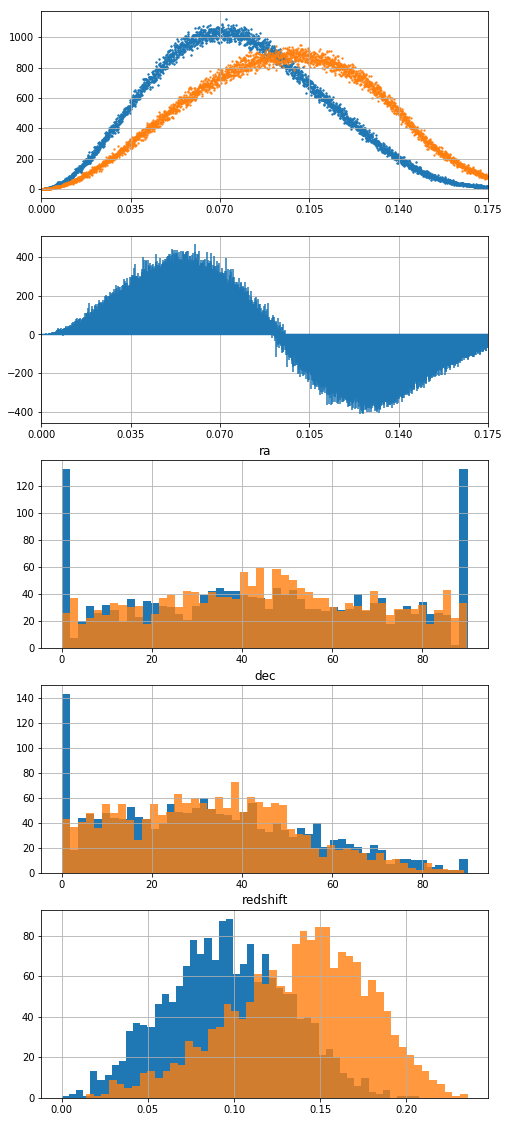

In [331]:
plot_results(cub_struct, 3000, 0.175, mod_mix=5)

In [293]:
min(cub_struct[:, 2]) / 0.035

3.0629190243193575e-05

In [286]:
uniform_distr(cub_struct, in_polar=True)

array([[ 0.11357792,  0.06215384,  0.24247759],
       [ 0.01870737,  0.01229132,  0.05923897],
       [ 0.0086103 ,  0.02576406,  0.06570405],
       ..., 
       [ 0.01953556,  0.01156802,  0.07764621],
       [-0.01038169,  0.00305078,  0.1064924 ],
       [ 0.01049375,  0.00685654,  0.0360866 ]])

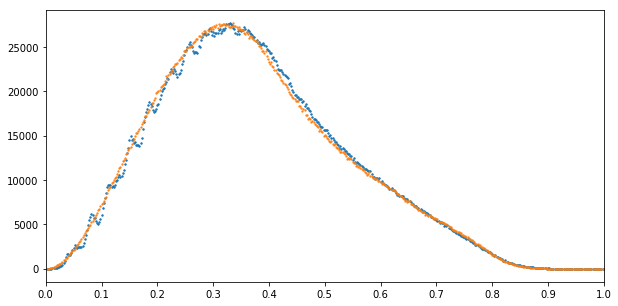

In [304]:
num_bins = 500
right_edge = 1
n1 = get_hist(cub_struct, num_bins, right_edge)           
n2 = get_hist(uniform_distr(cub_struct, in_polar=False), num_bins, right_edge)



fig = plt.figure(figsize=(10, 5))
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))
plt.show()

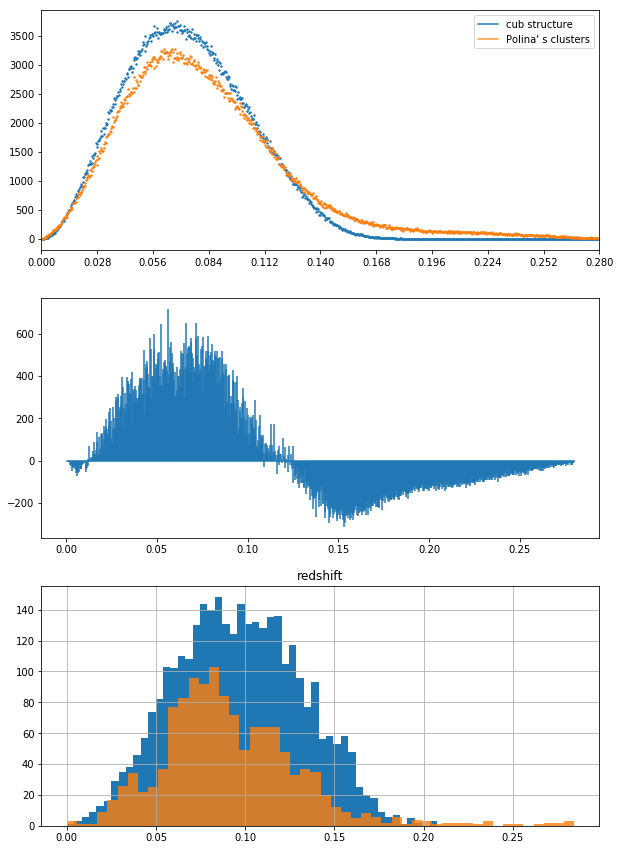

In [223]:
num_bins = 800
right_edge = 0.28
n1 = get_hist(cub_struct_cutted, num_bins, right_edge)  
n3 = get_hist(to_xyz(polina_clusters_left), num_bins, right_edge)  

fig = plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n3[1][1:], n3[0], s=2)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))

cub = mlines.Line2D([], [], color='C0', label='cub structure')
pol = mlines.Line2D([], [], color='C1', alpha=0.8, label="Polina' s clusters")
plt.legend(handles=[cub, pol])

#plt.show()
plt.subplot(312)
plot_distinguish(n1, n3)


plt.subplot(313)
plt.title('redshift')
plt.hist(to_ra_dec_redshift(cub_struct)[:,2], 50)
plt.hist(polina_clusters_left[:,2], 50, alpha=0.8)
plt.grid(True)
plt.show()

## Robert' s clustures


In [43]:
threshold_cone_with_cluster = 120
abell_ray = left_abell
area = left_area

list_cones = list()
list_no_clusters = list()
no_cluster_here = 0
for ra_dec in abell_ray:
    ra, dec = ra_dec[0], ra_dec[1]
    cone_with_cluster = (get_cone(area, ra, dec))
    if cone_with_cluster.shape[0] < threshold_cone_with_cluster:
        no_cluster_here += 1
        list_no_clusters.append(ra_dec)
    else:
        list_cones.append(cone_with_cluster)

        
for cone in list_cones:
    plt.hist(cone[:,2], 12, [0, 0.3])
    plt.xticks(np.linspace(0, 0.3, 11))
    plt.show()
    

In [19]:
left_rob, right_rob = left_right_regions(robert_cl)

In [30]:
left_rob = left_rob[left_rob[:,2]>10e-4]

In [32]:
left_rob[left_rob[:,2]<0.3].shape

(9034, 3)

In [35]:
?plot_results

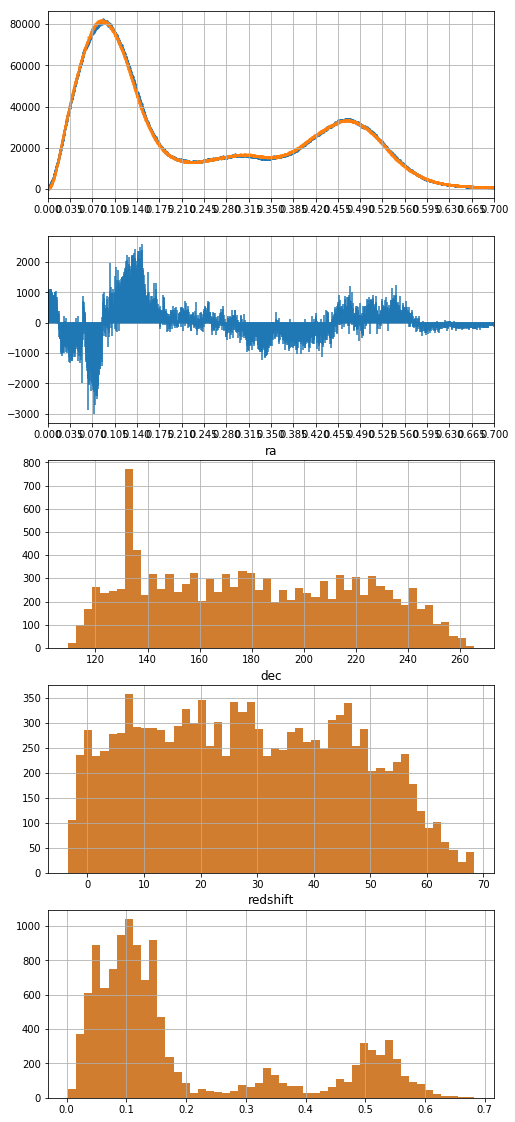

In [55]:
plot_results(to_xyz(left_rob), 3000, 0.7, mod_mix=2)

## Polina' s clusters

In [8]:
polina_clusters = reader('data/Clusters Polina.txt', commos2points=True)
mask_na = np.any(np.isnan(polina_clusters), axis=1)
polina_clusters = polina_clusters[~mask_na]
polina_clusters_left, _ = left_right_regions(polina_clusters)

In [ ]:
plot_results(to_xyz(...), 1500, 0.3, mod_mix=4, save=False, name='uniform xyz')

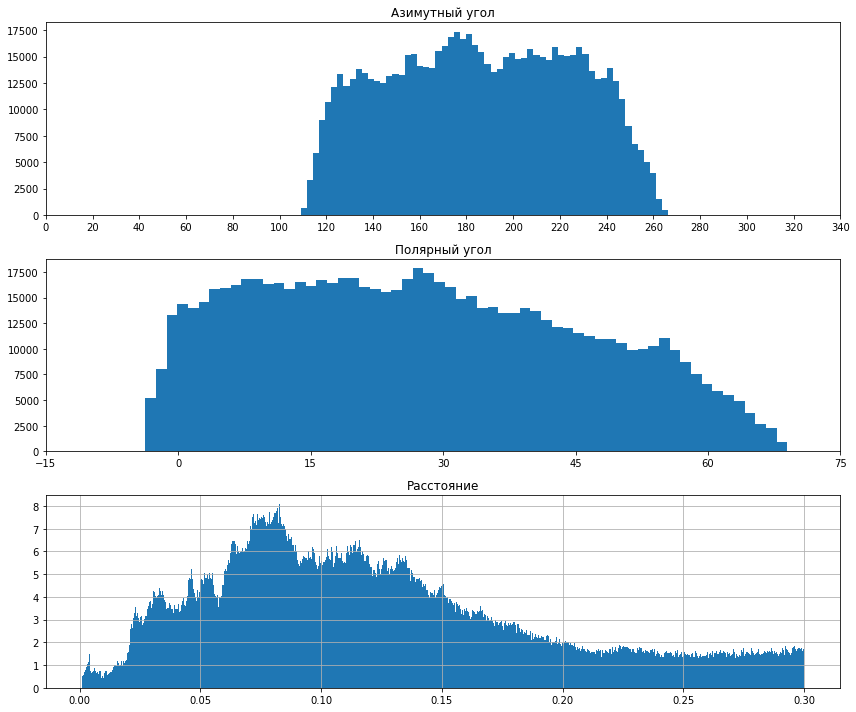

In [962]:
fig = plt.figure(figsize=(12, 10))

data = left_area

ax = plt.subplot(3, 1, 1)
ax.set_title('Азимутный угол')
plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 20))

ax = plt.subplot(3, 1, 2)
ax.set_title('Полярный угол')
plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 15))

ax = plt.subplot(3, 1, 3)
plt.hist(data[:,2], bins=1000, density=True)
ax.set_title('Расстояние')


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

plt.savefig('distrib.pdf')

In [668]:
a = distr_red_shift()
a.pdf(0.2)

2.0

In [674]:
left_area[(0.02 < left_area[:,2]) & (left_area[:,2]<0.2)].shape

(620087, 3)

In [675]:
left_area.shape

(751945, 3)

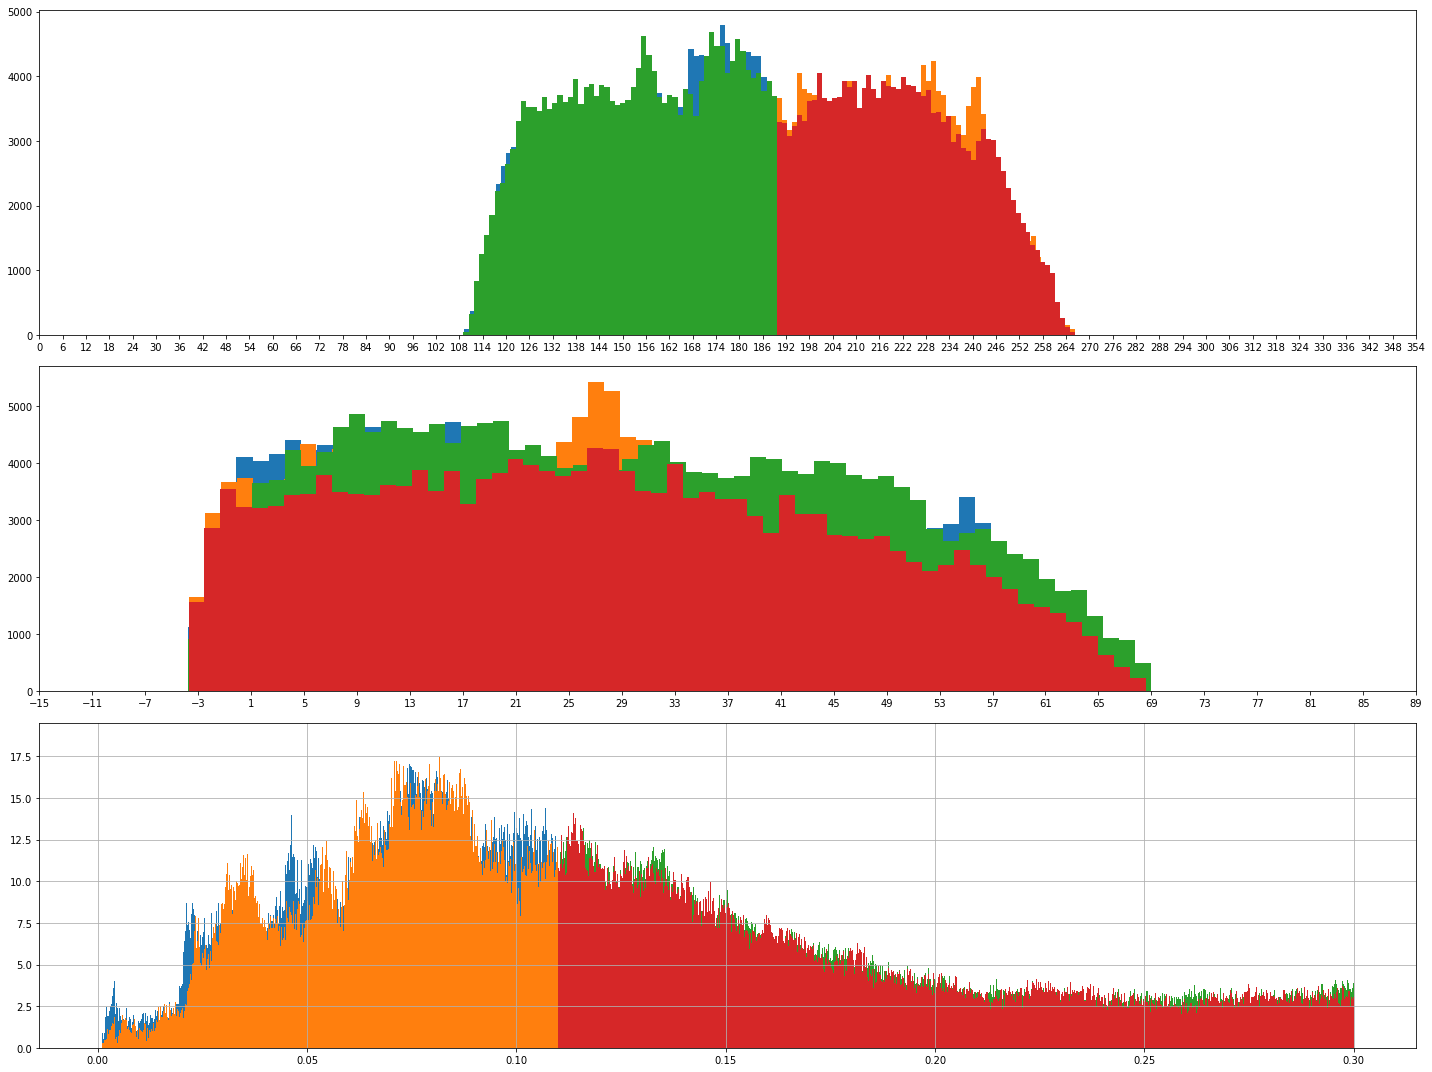

In [241]:
fig = plt.figure(figsize=(20, 15))


data_some = subareas
ax = plt.subplot(3, 1, 1)
for data in data_some:
    plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
for data in data_some:
    plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
for data in data_some:
    plt.hist(data[:,2], bins=1000, density=True)


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

In [14]:
def do_scan_reg(points_xyz, eps, n_neighbors,
                c_very_small=20, c_small=50, c_huge=300):
    dbscan_model = DBSCAN(eps=eps, min_samples=n_neighbors+1, metric='euclidean', algorithm='ball_tree')
    res = dbscan_model.fit_predict(points_xyz)
    lab, counts = np.unique(res, return_counts=True)
    
    noize = counts[0]
    counts = counts[1:]
    very_small = counts[counts<c_very_small].shape[0]
    small = counts[counts<c_small].shape[0] - very_small
    good = counts[(counts<c_huge) & (counts>c_small)].shape[0]
    huge = counts[counts>c_huge].shape[0]
    
    print('noize/all = {0:.3f}'.format(noize/points_xyz.shape[0]))
    print('under {0}: {1}'.format(c_very_small, very_small))
    print('under {0}: {1}'.format(c_small, small))
    print('more {0}: {1}'.format(c_huge, huge))      
    print('bigest cluster: {0}'.format(max(counts)))
    print('good clusters: {0}'.format(good))
    return res, lab, counts
    

(455, 3)
max = 1332.073
mediana = 270.73776954646416
for label 0 there are 276 galaxies
for label 2 there are 60 galaxies
for label 4 there are 35 galaxies
noize num :  (24, 3)


<IPython.core.display.Javascript object>


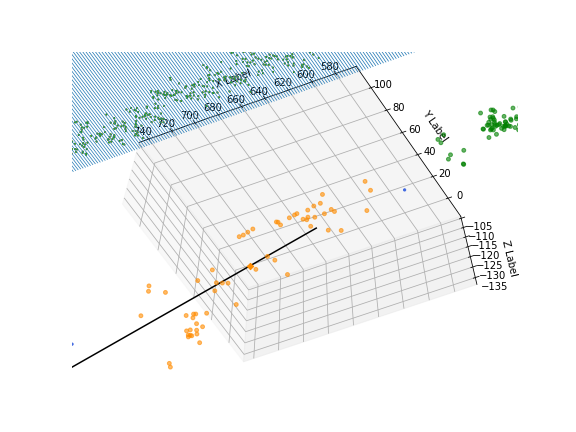

0
1
2


In [574]:
#dir_path = 'data/Abell less 0.3 chosen/'
#name_file = 'Abell_9 less 0.3 chosen.txt'

dir_path = 'data/Abell less 0.3/'
name_file = 'Abell_g_less_0.3 8.txt'

full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)


pair_dist = pairwise_distances(points_xyz)
not_zero_pair = np.triu(pair_dist)
print("max = {0:.3f}".format(np.max(not_zero_pair[not_zero_pair!=0])))

med = np.median(not_zero_pair[not_zero_pair!=0])
print("mediana = {0}".format(med))

clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med/8, verbose=True)
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(0, 0, 0, c='black', s=20)
ax.plot([ray[0]/2, ray[0]], [ray[1]/2, ray[1]], [ray[2]/2, ray[2]], c='black')
for i, cluster in enumerate(clusters):
    print(i)
    if i >= 3:
        break
    ax.scatter(*(cluster.T), c=colours[i+1], s=15, alpha=0.6)
    ax.scatter((*cen_clusters[i]), c=colours[i+1], s=20, marker='D') 
ax.scatter(*(noize.T), c=colours[0], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zticks([])
#plt.xticks([], [])
#plt.yticks([], [])

plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.set_zlim(10, 500)
plt.grid('True')
plt.show()


In [45]:
def analyze_seria(list_cones, verbose=False):
    '''
    seria of less chosen files
    
    '''
    coef_hugest_cluster = 0.4
    coef_2_clusters = 0.3
    coef_1st_to_2nd = 0.25
    many_galaxies = 500

    all_clusters = list()
    not_big = 0
    two_small = 0
    not_big_70 = 0
    bad_alg = 0
    two_clusters = 0
    bad_cluster = 0 
    
    all_clusters = list()
    
    for cone in list_cones:
        points_xyz = to_xyz(cone)
        num_galaxies = points_xyz.shape[0]
        pair_dist = pairwise_distances(points_xyz)
        not_zero_pair = np.triu(pair_dist)
        med = np.median(not_zero_pair[not_zero_pair!=0])
        
        if num_galaxies > many_galaxies:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med*0.2)
        else:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=3, eps=med*0.3)
        
        num_bigest = clusters[0].shape[0]
        if len(clusters) == 1:
            num_second = 0
        else:
            num_second = clusters[1].shape[0]
        
        if num_galaxies > many_galaxies:
            if (num_bigest-num_second)/num_bigest < coef_1st_to_2nd:
                if num_bigest > coef_2_clusters:
                    all_clusters.append(cen_clusters[0])
                    all_clusters.append(cen_clusters[1])
                    two_clusters += 1
                else:
                     two_small += 1
            elif num_bigest/num_galaxies > coef_hugest_cluster:
                all_clusters.append(cen_clusters[0])
        
            else:
                not_big += 1
    
        elif num_bigest/num_galaxies > coef_hugest_cluster:
            all_clusters.append(cen_clusters[0])  
        else:
            not_big_70 += 1
    
    if verbose:
        print(not_big, two_small, two_clusters, not_big_70)
    arr_clusters = np.array(all_clusters)
    return arr_clusters 

def pairwise_dist(points_xyz):
    MAX_MEM = 295000000
    #MAX_MEM = 1
    batch_size = round(MAX_MEM/points_xyz.shape[0]) - 10
    num_batches = (points_xyz.shape[0]+1)//batch_size
    print(points_xyz.shape[0], batch_size, num_batches)
    dataset_avg = 0.
    for i in range(1, num_batches):
        
        batch = points_xyz[(i-1)*batch_size : i*batch_size]
        d_avg = pairwise_distances(batch, points_xyz).mean(axis=1).sum()
        if i % 10==0:
            print(i, d_avg/batch_size)
        dataset_avg += d_avg
    return dataset_avg/points_xyz.shape[0]
     

<IPython.core.display.Javascript object>


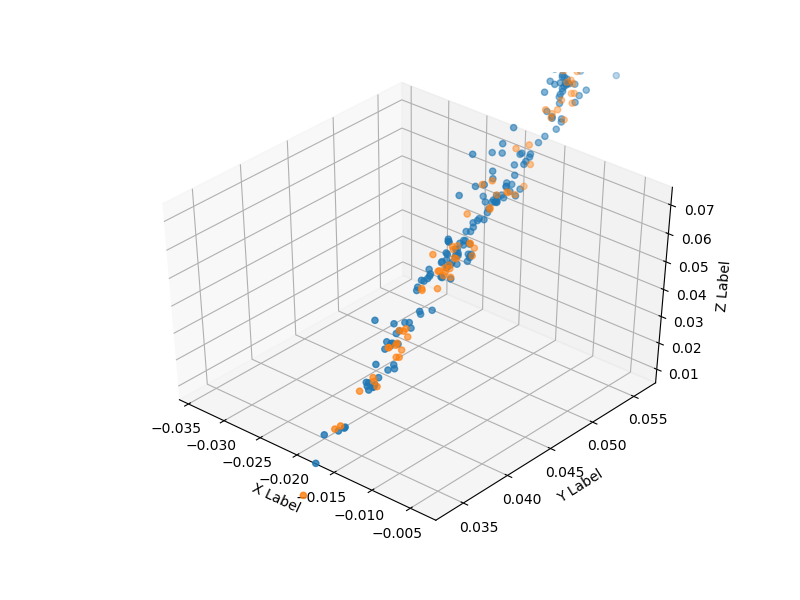

(-0.036809947143851822,
 -0.0011843875667747921,
 0.0032893065994873366,
 0.086339568433905056)

In [350]:
x